# Machine Learning for prediction of progression in Parkinson's disease

### Importing packages

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from datetime import datetime
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier, Pool

import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap
import subprocess
import umap
# from gap_statistic import OptimalK
# import cudf

Some useful variables for DataViz that will be used later

In [ ]:
color_azure = '#0097B2'
color_orange = '#F35000' 
color_blue = '#263985' 
color_red = '#B00000'

## Data Pre-processing

### Exploring the data

In [2]:
path = "data/Results_UPDATED.csv"
# Using the subprocesses library to directly get the memory available in linux
available_memory = int(subprocess.getoutput("grep MemTotal /proc/meminfo | awk '{print $2}'"))
memory_per_row = 100 
target_memory_usage = 0.75 * available_memory
chunk_size = int(target_memory_usage / memory_per_row)

Original df that contains notes info (Takes about 3 minutes)

In [3]:
# Actual way to read large CSV files
chunk = pd.read_csv(path, chunksize=chunk_size, dtype={'dose_unit_source_value': str}) #Raises a DtypeWarning: Columns (11) have mixed types when it is not specified
# The original df contains information regarding all drug and notes information
df = pd.concat(chunk)

In [4]:
df.head()

person_id                                  drug_source_value  quantity  \
0     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   
1     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   
2     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   
3     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   
4     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   

   dose_source_value dose_unit_source_value  \
0              100.0                  mL/hr   
1              100.0                  mL/hr   
2              100.0                  mL/hr   
3              100.0                  mL/hr   
4              100.0                  mL/hr   

                                           note_text        note_datetime  
0  Department of Internal Medicine  History and P...  2015-06-30 17:48:00  
1  "Neurology Admission Note  Subspecialty Servic...  2017-12-13 21:07:00  
2  "SUBJECTIVE:  Mr. [**NAME**] presents today fo...  2016-05-06 11:02:00  
3  "Department of General Surgery  Pre-Op Interva...  2017-11-01 11:51:00  
4  "Department of Surgery  Acute Care Surgery    ...  2021-04-10 08:02:00

In [5]:
# Number of total Parkinson's in-hospital patients in our dataset
df['person_id'].nunique() # -> 1456

1456

Actual len of the whole dataset. It has more than 4 Million rows

In [6]:
len(df)

4466776

In [7]:
# Setting the note_datetime to the right format
df['note_datetime'] = pd.to_datetime(df["note_datetime"], format='%Y-%m-%d')

DataFrame with drug_exposure info

In [8]:
# TRY.csv contains information regarding drug_exposure, visit_occurrence_id and visit_detail_id.
# The SQL query to get this table involved looking at the drug_exposure_start_datetime for each PD drug for each PD patient. 
# Therefore, the table contains more specific information regarding administration of PD drugs.
# Later on, drug_exposure is used to calculate the LED
# Update: This dataset contains relevant information regarding PD drugs and only PD drugs.
drug_exposure = pd.read_csv('data/TRY_NEW.csv')

In [9]:
drug_exposure['person_id'].nunique()

1424

In [10]:
drug_exposure.head()

person_id drug_exposure_start_datetime  \
0     261006          2021-04-11 10:53:00   
1     261006          2021-04-11 14:58:00   
2     261006          2021-04-11 17:32:00   
3     261006          2021-04-11 21:31:00   
4     261006          2021-04-12 02:52:00   

                                   drug_source_value  dose_source_value  \
0  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   

  dose_unit_source_value route_source_value  visit_occurrence_id  \
0                 tablet               ORAL             40422623   
1                 tablet               ORAL             40422623   
2                 tablet               ORAL             40422623   
3                 tablet               ORAL             40422623   
4                 tablet               ORAL             40422623   

   visit_detail_id  
0        9880783.0  
1        9880783.0  
2        9880783.0  
3        9880783.0  
4        9880783.0

Loading demographic info

In [11]:
# TODO: For PD patients, check only those pts that are in the orignal df
demographics = pd.read_csv('data/DEMOGRAPHICS.csv') # Demographic information for PD patients only
demographics_all = pd.read_csv('data/DEMOGRAPHICS_ALL.csv') # Demographics info for all the patients

Calculating patients age

In [12]:
# Converting the "birth_datetime" column to a datetime format 
demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"], format='%Y-%m-%d')
demographics_all["birth_datetime"] = pd.to_datetime(demographics_all["birth_datetime"], format='%Y-%m-%d')

# Calculating the age by substracting the current date with the date in the dataframe
demographics["age"] = (pd.Timestamp('now') - demographics["birth_datetime"]).astype('timedelta64[Y]')
demographics_all["age"] = (pd.Timestamp('now') - demographics_all["birth_datetime"]).astype('timedelta64[Y]')

# Converting age to integer
demographics["age"]  = pd.to_numeric(demographics["age"], downcast='integer')
demographics_all["age"]  = pd.to_numeric(demographics_all["age"], downcast='integer')

# Dropping the birth_datetime (it's useless at this point) 
demographics = demographics.drop("birth_datetime", axis=1)
demographics_all = demographics_all.drop("birth_datetime", axis=1)

# Re-arranging the order of the columns
demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
demographics_all = demographics_all[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]

demographics

person_id  age gender_source_value race_source_value  \
0           136   72              FEMALE             BLACK   
1           668   75                MALE             WHITE   
2           820   86                MALE             WHITE   
3           916   75                MALE             WHITE   
4           936   88                MALE             WHITE   
...         ...  ...                 ...               ...   
2719     260953   72              FEMALE             WHITE   
2720     260956   88              FEMALE             WHITE   
2721     260994   65                MALE             WHITE   
2722     260996   77              FEMALE             WHITE   
2723     261006   74                MALE             WHITE   

     ethnicity_source_value  
0              NOT HISPANIC  
1              NOT HISPANIC  
2              NOT HISPANIC  
3              NOT HISPANIC  
4              NOT HISPANIC  
...                     ...  
2719           NOT HISPANIC  
2720           NOT HISPANIC  
2721           NOT HISPANIC  
2722           NOT HISPANIC  
2723           NOT HISPANIC  

[2724 rows x 5 columns]

#### Dealing with the drug_source_value column

Because the drug_source_value column contains elements as json, we convert them into a dict so that we can use their original keys:

In [13]:
drug_source_value = df['drug_source_value'].apply(lambda x: json.loads(x))

In [14]:
drug_source_value[:500]

0      {'med_display_name': '0.9 % NaCl + potassium c...
1      {'med_display_name': '0.9 % NaCl + potassium c...
2      {'med_display_name': '0.9 % NaCl + potassium c...
3      {'med_display_name': '0.9 % NaCl + potassium c...
4      {'med_display_name': '0.9 % NaCl + potassium c...
                             ...                        
495    {'med_display_name': '0.9 % NaCl infusion', 'r...
496    {'med_display_name': '0.9 % NaCl infusion', 'r...
497    {'med_display_name': '0.9 % NaCl infusion', 'r...
498    {'med_display_name': '0.9 % NaCl infusion', 'r...
499    {'med_display_name': '0.9 % NaCl infusion', 'r...
Name: drug_source_value, Length: 500, dtype: object

We do the same for the `drug_source_value` column in the drug_exposure database

In [15]:
dsv_drug_exposure = drug_exposure['drug_source_value'].apply(lambda x: json.loads(x))

drug_exposure and dsv_drug_exposure  has already been filtered through SQL and contains Parkinson's drugs

In [16]:
print(len(drug_source_value),len(dsv_drug_exposure) )

4466776 79366


In [17]:
dsv_drug_exposure

0        {'med_display_name': 'carbidopa-levodopa (SINE...
1        {'med_display_name': 'carbidopa-levodopa (SINE...
2        {'med_display_name': 'carbidopa-levodopa (SINE...
3        {'med_display_name': 'carbidopa-levodopa (SINE...
4        {'med_display_name': 'carbidopa-levodopa (SINE...
                               ...                        
79361    {'med_display_name': 'carbidopa-levodopa (SINE...
79362    {'med_display_name': 'carbidopa-levodopa (SINE...
79363    {'med_display_name': 'carbidopa-levodopa (SINE...
79364    {'med_display_name': 'carbidopa-levodopa (SINE...
79365    {'med_display_name': 'carbidopa-levodopa (SINE...
Name: drug_source_value, Length: 79366, dtype: object

In [18]:
drug_exposure['person_id'].nunique()

1424

drug_source_value has the same len as the original df. The positions of the dictionary are the rows in the original df 

In [19]:
drug_source_value[12] == json.loads(df.iloc[12]['drug_source_value'])

True

The keys of the dictionary are those used in the drug_source_value column

In [20]:
drug_source_value[0].keys()

dict_keys(['med_display_name', 'rxnorm_concat', 'med_dose_unit_desc', 'mar_action', 'med_order_desc'])

In [21]:
drug_source_value[12]

{'med_display_name': '0.9 % NaCl + potassium chloride 20 mEq/L infusion ',
 'rxnorm_concat': '| 637551 |',
 'med_dose_unit_desc': 'ml/hr',
 'mar_action': 'NEW BAG',
 'med_order_desc': 'POTASSIUM CHLORIDE IN NACL 20-0.9 MEQ/L-% IV SOLN'}

Current medication used for the treatment of Parkinson's disease

In [351]:
# Defining the generic name of drugs used to treat Parkinson's disease
pd_medication = ["levodopa", "pramipexole", "ropinirole", "rotigotine", "bromocriptine", "cabergoline", "pergolide", "lisuride", "apomorphine", "selegiline", "rasagiline", "safinamide", "entacapone", "tolcapone", "opicapone", "amantadine", "trihexyphenidyl", "benztropine", "istradefylline", "benserazide", "carbidopa"]
pd_medication_drug_type = {
    "DA Precursors": pd_medication[0],
    "DA Agonists": pd_medication[1:9], 
    "MAO-B Inhibitors": pd_medication[9:12],
    "COMT Inhibitors": pd_medication[12:15],
    "NMDA Receptor Antagonists": pd_medication[15],
    "Anticholinergics": pd_medication[16:18],
    "Adenosine A2A Antagonists": pd_medication[17],
    "DOPA Decarboxylase Inhibitor": pd_medication[-2:]
}

In [352]:
pd_medication_drug_type

{'DA Precursors': 'levodopa',
 'DA Agonists': ['pramipexole',
  'ropinirole',
  'rotigotine',
  'bromocriptine',
  'cabergoline',
  'pergolide',
  'lisuride',
  'apomorphine'],
 'MAO-B Inhibitors': ['selegiline', 'rasagiline', 'safinamide'],
 'COMT Inhibitors': ['entacapone', 'tolcapone', 'opicapone'],
 'NMDA Receptor Antagonists': 'amantadine',
 'Anticholinergics': ['trihexyphenidyl', 'benztropine'],
 'Adenosine A2A Antagonists': 'benztropine',
 'DOPA Decarboxylase Inhibitor': ['benserazide', 'carbidopa']}

In [339]:
pd_medication[10:13]

['rasagiline', 'safinamide', 'entacapone']

We look for instances of the Parkinson's drugs contained in the pd_medication array in drug_source_value so that we can focus on the medical notes relating to Parkinson's.

In [23]:
# Loops over all the elements in the drug_source_value column and checks if the generic name of the drug is in the list of PD drugs
# Saves the new drug names in the pd_drug_info dictionary in the same index as the drug_source_value
pd_drug_info = {}
for i in range(len(drug_source_value)):
    med_display_name = drug_source_value[i]['med_display_name']
    # Some values in the new DB appear as nan. Here we check the type ("float") and value (nan) and ommitt them
    if isinstance(med_display_name, (float, np.floating)) and np.isnan(med_display_name):
          break
    for item in pd_medication:
        if item in med_display_name:
            pd_drug_info[i] = med_display_name #2959984

In [24]:
len(pd_drug_info)

22863

Something similar (extracting the med_display_name and using that instead of the whole json)

In [25]:
drug_info_drug_source_value = {}
for i, drug in enumerate(dsv_drug_exposure):
    drug_info_drug_source_value[i] = drug['med_display_name'] # I could have also passed the whole dictionary

In [26]:
# The len of drug_info_drug_source_value is higher because in the SQL query the drug_exposure table was filtered to get specically time of admnistration for PD drugs (drug_exposre_start_datetime)
print(len(pd_drug_info), len(drug_info_drug_source_value))

22863 79366


Only 22K+ rows have information regarding medication for Parkinson's

In [27]:
drug_info_drug_source_value

{0: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 2: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 3: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 4: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 5: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 6: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 7: 'amantadine (SYMMETREL) capsule 100 mg',
 8: 'amantadine (SYMMETREL) capsule 100 mg',
 9: 'amantadine (SYMMETREL) capsule 100 mg',
 10: 'amantadine (SYMMETREL) capsule 100 mg',
 11: 'amantadine (SYMMETREL) capsule 100 mg',
 12: 'amantadine (SYMMETREL) capsule 100 mg',
 13: 'amantadine (SYMMETREL) capsule 100 mg',
 14: 'amantadine (SYMMETREL) capsule 100 mg',
 15: 'amantadine (SYMMETREL) capsule 100 mg',
 16: 'amantadine (SYMMETREL) capsule 100 mg',
 17: 'amantadine (SYMMETREL) capsule 100 mg',
 18: 'amantadine (SYMMETREL) capsul

In [28]:
pd_drug_info

{1682: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1683: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1684: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1685: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1686: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1687: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1688: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1689: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1690: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1691: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1692: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1693: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1694: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1695: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1696: 'carbidopa-levodopa (SINEME

In [29]:
len(pd_drug_info)

22863

The keys of this new array are the indices or rows in the original DataFrame. These rows contain information regarding Parkinson's medication 

In [30]:
pd_drug_info.keys()

dict_keys([1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925, 9926, 9927, 9928, 9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964,

pd_drug_info is a subset of drug_source_value that contains the name of drugs related to PD

In [31]:
drug_source_value[1682]

{'med_display_name': 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 'rxnorm_concat': '| 197444 |',
 'med_dose_unit_desc': 'tablet',
 'mar_action': 'GIVEN',
 'med_order_desc': 'CARBIDOPA-LEVODOPA 25-100 MG PO TABS'}

Here's our new database. df_pd is a subset of the original dataset that only contains patients that are taking medication for Parkinson's

In [32]:
pd_drug_info

{1682: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1683: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1684: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1685: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1686: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1687: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1688: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1689: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1690: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1691: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1692: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1693: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1694: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1695: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1696: 'carbidopa-levodopa (SINEME

In [33]:
df_pd = df.iloc[list(pd_drug_info.keys())]
df_pd.sample(10)

person_id                                  drug_source_value  \
2664554      97066  {"med_display_name": "carbidopa-levodopa (SINE...   
564276      254666  {"med_display_name": "carbidopa-levodopa (SINE...   
917581      234048  {"med_display_name": "carbidopa-levodopa (SINE...   
2156200     118106  {"med_display_name": "benztropine (COGENTIN) t...   
1168073     220073  {"med_display_name": "carbidopa-levodopa (SINE...   
2318347     109467  {"med_display_name": "carbidopa-levodopa (SINE...   
2683534      96816  {"med_display_name": "entacapone (COMTAN) tabl...   
30122       260102  {"med_display_name": "pramipexole (MIRAPEX) ta...   
839392      241559  {"med_display_name": "carbidopa-levodopa (SINE...   
1645844     201909  {"med_display_name": "carbidopa-levodopa (SINE...   

         quantity  dose_source_value dose_unit_source_value  \
2664554       1.0                1.0                 tablet   
564276        1.0                1.0                 tablet   
917581        2.0                2.0                 tablet   
2156200       1.0                1.0                     mg   
1168073       0.0                0.0                 tablet   
2318347       1.0                1.0                 tablet   
2683534       1.0              200.0                     mg   
30122         1.5                1.5                     mg   
839392        0.0                0.0                 tablet   
1645844       0.0                0.0                 tablet   

                                                 note_text       note_datetime  
2664554  Department of Medicine  Division of Pulmonary,... 2018-05-23 05:09:00  
564276   "Department of Medicine  Hospitalist Service  ... 2012-10-19 20:33:00  
917581   "Department of Surgery        Admission Date a... 2015-10-18 19:37:00  
2156200  "PATIENT NAME:  [**NAME**]  MRN:   [**ID**]  D... 2015-12-31 01:46:00  
1168073  Department of Internal Medicine  History and P... 2015-05-05 16:10:00  
2318347  Interval History and Physical Note    Chief Co... 2013-06-18 09:29:00  
2683534  "Hospitalist Service  History and Physical    ... 2017-01-11 14:08:00  
30122    54 y.o. Male with FIT positive     Procedure: ... 2019-03-14 13:03:00  
839392   Vascular Neurology H&P    Chief Complaint: R F... 2019-07-07 12:36:00  
1645844  "Neurology Admission Note  Subspecialty Servic... 2017-07-25 21:08:00

In [34]:
df_pd


person_id                                  drug_source_value  \
1682        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1683        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1684        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1685        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1686        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
...            ...                                                ...   
2959823      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959824      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959825      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959826      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959827      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   

         quantity  dose_source_value dose_unit_source_value  \
1682          2.0                2.0                 tablet   
1683          2.0                2.0                 tablet   
1684          2.0                2.0                 tablet   
1685          2.0                2.0                 tablet   
1686          2.0                2.0                 tablet   
...           ...                ...                    ...   
2959823       1.0                1.0                  patch   
2959824       1.0                1.0                  patch   
2959825       1.0                1.0                  patch   
2959826       1.0                1.0                  patch   
2959827       1.0                1.0                  patch   

                                                 note_text       note_datetime  
1682     "Department of Surgery  Division of Colorectal... 2019-02-20 12:17:00  
1683     "SUBJECTIVE:  Mr. [**NAME**] presents today fo... 2016-05-06 11:02:00  
1684     "Neurology Admission Note  Subspecialty Servic... 2017-12-13 21:07:00  
1685     "Department of Internal Medicine  History and ... 2018-05-10 14:27:00  
1686     "CHIEF COMPLAINT : anal lesions      HISTORY O... 2012-07-13 13:48:00  
...                                                    ...                 ...  
2959823  63 yo male with history of CAD s/p CABG and PC... 2014-05-15 07:36:00  
2959824  Department of Internal Medicine   Division of ... 2016-03-07 12:28:00  
2959825  Department of Internal Medicine   Division of ... 2016-03-07 12:28:00  
2959826  "Deparment of Cardiology  Cardiology Critical ... 2016-02-21 17:52:00  
2959827  Department of Internal Medicine  History and P... 2018-09-23 16:47:00  

[22863 rows x 7 columns]

Inserting the column drug_info into the pd dataset

In [35]:
# TODO: Add drug_info_drug_source_value to df_pd look if that is what you wanted to do
df_pd.insert(loc=2, column="drug_info", value=pd_drug_info)

In [36]:
df_pd.sample(5)

person_id                                  drug_source_value  \
2489388     105653  {"med_display_name": "carbidopa-levodopa-entac...   
2394589     106450  {"med_display_name": "benztropine (COGENTIN) t...   
1832344     180806  {"med_display_name": "trihexyphenidyl (ARTANE)...   
95487       258078  {"med_display_name": "carbidopa-levodopa (SINE...   
552960      254942  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  quantity  \
2489388  carbidopa-levodopa-entacapone (STALEVO) 37.5-1...       1.0   
2394589                 benztropine (COGENTIN) tablet 1 mg       0.0   
1832344             trihexyphenidyl (ARTANE) tablet 2.5 mg       0.5   
95487    carbidopa-levodopa (SINEMET) 25-250 MG per tab...       1.0   
552960   carbidopa-levodopa (SINEMET) 25-100 MG per tab...       0.0   

         dose_source_value dose_unit_source_value  \
2489388                1.0                 tablet   
2394589                0.0                     mg   
1832344                2.5                     mg   
95487                  1.0                 tablet   
552960                 0.0                 tablet   

                                                 note_text       note_datetime  
2489388  Department of Neurosurgery  Pre-Op Interval Hi... 2019-04-04 07:11:00  
2394589  "PATIENT NAME: [**NAME**]   MRN:  [**ID**]  DA... 2012-11-06 22:19:00  
1832344  I saw and evaluated [**NAME**] on rounds [**DA... 2012-02-14 09:56:00  
95487    "Department of Urology  H+P      Chief Complai... 2020-06-29 06:40:00  
552960   Department of Radiology  Special Procedures   ... 2012-07-05 14:38:00

In [37]:
df_pd.iloc[955]

person_id                                                            258855
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                 carbidopa-levodopa (SINEMET CR) 25-100 MG per ...
quantity                                                                1.0
dose_source_value                                                       1.0
dose_unit_source_value                                               tablet
note_text                 "Neurosurgery History and Physical    Chief Co...
note_datetime                                           2013-10-02 18:09:00
Name: 63106, dtype: object

Let's take a look at the drugs actually used in the dataset. **Note**: vscode truncakes the ouput so it could be that you won't see all the drugs. i.e: Cabergoline (1299166).

In [38]:
pd_drug_info

{1682: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1683: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1684: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1685: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1686: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1687: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1688: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1689: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1690: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1691: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1692: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1693: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1694: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1695: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1696: 'carbidopa-levodopa (SINEME

In [40]:
# pd_drugs_used is just the list version of lowercase values in pd_drug_info
pd_drugs_used = [item.lower() for item in pd_drug_info.values()]
# Takes the unique values and sorts them to finally be saved in an array
pd_drugs_used_unique = sorted(set(pd_drugs_used))

In [42]:
pd_drugs_used_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**inv ipx203 carbidopa-levodopa (ipx203-b16-03) 52.5-210 mg er capsule 4 capsule (patient supplied)**',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*amantadine er (gocovri) extended release capsule 274 mg patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*rotigotine (neupro) 4 mg/24hr patch 1 patch - patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 200 mg',
 'amantadine (symmetrel) solution 50 mg',
 'amantadine (symmetrel) syrup 100 mg',
 'a

We do the same for the drugs in dsv_drug_exposure

In [41]:
drugs_used_drug_exposure = [item.lower() for item in drug_info_drug_source_value.values()]
drugs_used_drug_exposure_unique = sorted(set(drugs_used_drug_exposure))

In [43]:
drugs_used_drug_exposure_unique

['* carbidopa-levodopa-entacapone (stalevo) 37.5-150-200 mg 1 tablet - patient home med',
 '* patient supplied carbidopa-levodopa-entacapone (stalevo) 37.5-150-200 mg 1 tablet',
 '* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '* selegiline (eldepryl) 5 mg capsule (patient own medication)',
 '****patient supplied medication - carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**inv ipx203 carbidopa-levodopa (ipx203-b16-03) 52.5-210 mg er capsule 4 capsule (patient supplied)**',
 '**rasagiline mesylate (azilect) tablet 1 mg, patient supplied medication',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*amantadine er (gocovri) extended release capsule 274 mg patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied

**Note:** 1700 is **NOT** the position in the array but rather the key that contains the element. The len for both structures in 16040  

In [44]:
pd_drug_info[1700]

'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet'

The position in the list that contains item with the key 1299166

In [45]:
list(pd_drug_info.keys()).index(1700)

18

Using a ***Regex*** to get the drug_name, generic_name and dosage from pd_drugs_used

In [47]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names = []
brand_names = []
dosages = []

# Extract information and populate the lists
for string in pd_drugs_used:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names.append(generic_name)

        if brand_name:
            brand_names.append(brand_name)
        else:
            brand_names.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages.append(dosage_match[0])
        else:
            dosages.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names.append(np.nan)


# Create DataFrame
pd_data = pd.DataFrame({
    "generic_name": generic_names,
    "brand_name": brand_names,
    "dosage": dosages
})

*Regex* for drug_exposure

In [46]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names_de = []
brand_names_de = []
dosages_de = []

# Extract information and populate the lists
for string in drugs_used_drug_exposure:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names_de.append(generic_name)

        if brand_name:
            brand_names_de.append(brand_name)
        else:
            brand_names_de.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages_de.append(dosage_match[0])
        else:
            dosages_de.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names_de.append(np.nan)


# Create DataFrame
pd_data_drug_exposure = pd.DataFrame({
    "generic_name": generic_names_de,
    "brand_name": brand_names_de,
    "dosage": dosages_de
})

In [48]:
pd_data.sample(5)

generic_name  brand_name         dosage
21728             carbidopa-levodopa     sinemet      25-100 mg
14684             carbidopa-levodopa     sinemet      25-100 mg
353               carbidopa-levodopa     sinemet      25-250 mg
17676             carbidopa-levodopa  sinemet cr      50-200 mg
18546  carbidopa-levodopa-entacapone     stalevo  25-100-200 mg

In [49]:
pd_data_drug_exposure.sample(5)

generic_name  brand_name      dosage
40129  carbidopa-levodopa  sinemet cr   25-100 mg
59617  carbidopa-levodopa  sinemet cr   25-100 mg
11490         pramipexole     mirapex     0.75 mg
78506  carbidopa-levodopa     sinemet  12.5-50 mg
23216  carbidopa-levodopa     sinemet   25-100 mg

Error or inconsistency. I might look into this later

In [50]:
# There's an inconsistency with this. The RxCUI code associated with it (885205) actually shows 1 mg not 0.5. See: https://mor.nlm.nih.gov/RxNav/search?searchBy=RXCUI&searchTerm=885205
df_pd['drug_source_value'].iloc[3013]

'{"med_display_name": "carbidopa-levodopa (SINEMET) 10-100 MG per tablet 1 tablet", "rxnorm_concat": "| 197443 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 10-100 MG PO TABS"}'

In [51]:
pd_data.iloc[3013]

generic_name    carbidopa-levodopa
brand_name                 sinemet
dosage                   10-100 mg
Name: 3013, dtype: object

In [52]:
df_pd['person_id'].nunique()

631

In [53]:
# Notice that for selegiline the generic_name still contains the dosage and form of administration. This is because, for selegiline, the name string doesn't contain the brand name   
pd_data.iloc[13628]

generic_name    carbidopa-levodopa
brand_name                 sinemet
dosage                   25-100 mg
Name: 13628, dtype: object

#### Dealing with missing data

In [54]:
# Taking a look at the rows where there are missing values 
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name         dosage
3538           carbidopa and levodopa er capsules        NaN   61.25-245 mg
4367                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4368                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4369                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4370                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4371                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4372                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4373                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4374                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4375                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4376                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4377                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4378        

In [55]:
missing_info_index = pd_data[pd_data.isnull().any(axis=1)].index

In [56]:
for i in range(len(missing_info_index)):
    print(df_pd.iloc[missing_info_index[i]]['drug_source_value'])

{"med_display_name": "Carbidopa and levodopa ER capsules 61.25-245 mg **Patient Own Med**", "rxnorm_concat": NaN, "med_dose_unit_desc": "capsule", "mar_action": "GIVEN", "med_order_desc": "Carbidopa and levodopa ER capsules 61.25-245 mg **Patient Own Med**"}
{"med_display_name": "**carbidopa-levodopa 4.63-20 mg/mL (DUOPA) suspension** PT SUPPLIED MED", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ml", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 4.63-20 MG/ML EN SUSP"}
{"med_display_name": "**carbidopa-levodopa 4.63-20 mg/mL (DUOPA) suspension** PT SUPPLIED MED", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ml", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 4.63-20 MG/ML EN SUSP"}
{"med_display_name": "**carbidopa-levodopa 4.63-20 mg/mL (DUOPA) suspension** PT SUPPLIED MED", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ml", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 4.63-20 MG/ML E

Using the pd_drugs_used_unique and pd_drugs_used list to fill missing values

In [57]:
# Here we realize that the brand name for the drug is actualy duopa
pd_drugs_used[4367:4383]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidop

In [58]:
# # Regex couldn't catch the brand name because it was in a different position, so we add it manually
# # Patient is taking LCIG (Levodopa-cabidopa intestinal gel), most likely it is duopa (this is an assumption) -> It's actually true
# # TODO: Maybe replace this with Dopamine Replacement Therapy (Listen again to Dr. K's audio)
# condition = (pd_data['generic_name'] == 'carbidopa-levodopa') & (pd_data['dosage'] == '4.63-20 mg/ml')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'duopa'

In [59]:
# condition = (pd_data['generic_name'] == 'inv levodopa-carbidopa intestinal gel') & (pd_data['dosage'] == '20-5mg/ml')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'duopa' 
#     pd_data.loc[condition, 'dosage'] = '5-20 mg/ml'

In [60]:
# Duopa is a carbodipa-levodopa intestinal gel used for PD
df_pd.iloc[5607]['drug_source_value']

'{"med_display_name": "Inv levodopa-carbidopa intestinal gel pump stop", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "each", "mar_action": "GIVEN BY OTHER", "med_order_desc": "INV LEVODOPA-CARBIDOPA INTESTINAL GEL PUMP STOP"}'

In [61]:
# condition = (pd_data['generic_name'] == 'inv levodopa-carbidopa intestinal gel pump')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'duopa' 
#     pd_data.loc[condition, 'dosage'] = '4.63-20 mg/ml'

In [62]:
# condition = (pd_data['generic_name'] == 'selegiline tablet 5 mg')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'eldepryl' 
#     pd_data.loc[condition, 'generic_name'] = 'selegiline'

In [63]:
df_pd.iloc[18460]['drug_source_value']

'{"med_display_name": "inv istradefylline/placebo (KYOWA 014) tablet 2 Tablet", "rxnorm_concat": NaN, "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "INV ISTRADEFYLLINE (KYOWA 014) PO TABS JX"}'

In [64]:
# # med_display name shows KYOWA who is the manufacturer of istradefylline. The actual brand name is Nourianz. It comes on 20 and 40mg
# condition = (pd_data['generic_name'] == 'inv')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'nourianz'
#     pd_data.loc[condition, 'dosage'] = '40 mg'
#     pd_data.loc[condition, 'generic_name'] = 'istradefylline'

In [65]:
# condition = (pd_data['generic_name'] == 'carbidopa and levodopa er capsules')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'rytary'

In [66]:
# # Look if it should be 0.5 or 1mg
# condition = (pd_data['generic_name'] == 'inv rasagiline or placebo 1 mg')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'azilect'
#     pd_data.loc[condition, 'generic_name'] = 'rasagiline'

In [67]:
pd_data[pd_data['generic_name'] == 'rasagiline']

generic_name brand_name  dosage
16081   rasagiline    azilect  0.5 mg
16082   rasagiline    azilect  0.5 mg
16083   rasagiline    azilect  0.5 mg
16084   rasagiline    azilect  0.5 mg
18465   rasagiline    azilect  0.5 mg
18466   rasagiline    azilect  0.5 mg
18467   rasagiline    azilect  0.5 mg
18468   rasagiline    azilect  0.5 mg
18469   rasagiline    azilect  0.5 mg

In [68]:
# Define conditions
conditions = {
    'duopa_1': (
        (pd_data['generic_name'] == 'inv levodopa-carbidopa intestinal gel') &
        (pd_data['dosage'] == '20-5mg/ml')
    ),
    'duopa_2': (
        (pd_data['generic_name'] == 'carbidopa-levodopa') &
        (pd_data['dosage'] == '4.63-20 mg/ml')
    ),
    'duopa_3': (
        (pd_data['generic_name'] == 'inv levodopa-carbidopa intestinal gel pump')
    ),
    'eldepryl': (pd_data['generic_name'] == 'selegiline tablet 5 mg'),
    'nourianz': ((pd_data['generic_name'] == 'inv') | (pd_data['brand_name'] == 'nourianz') & (pd_data['dosage'] == '40 mg')),
    'rytary': (pd_data['generic_name'] == 'carbidopa and levodopa er capsules'),
    'azilect': (pd_data['generic_name'] == 'inv rasagiline or placebo 1 mg')
}

# Apply changes in a single loc operation for each condition
for brand, condition in conditions.items():
    if condition.any():
        if brand == 'nourianz':
            pd_data.loc[condition, ['brand_name', 'dosage', 'generic_name']] = 'nourianz', '40 mg', 'istradefylline'
        elif brand.startswith('duopa'):
            # Split 'duopa' into two cases
            if brand == 'duopa_1':
                pd_data.loc[condition, ['brand_name', 'dosage']] = 'duopa', '5-20 mg/ml'
            elif (brand == 'duopa_2' ) | (brand == 'duopa_3'):
                pd_data.loc[condition, ['brand_name', 'dosage']] = 'duopa', '4.63-20 mg/ml'
        else:
            pd_data.loc[condition, 'brand_name'] = brand

No more empty rows in pd_data

In [69]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


Let's keep preprocessing

In [70]:
pd_data['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'entacapone',
       'rasagiline mesylate', 'pramipexole', 'benztropine mesylate',
       'selegiline', 'carbidopa-levodopa-entacapone', 'trihexyphenidyl',
       'carbidopa', 'rotigotine', 'carbidopa-levodopa er',
       'carbidopa and levodopa er capsules', 'apomorphine',
       'amantadine er', ' rasagiline mesylate',
       'inv levodopa-carbidopa intestinal gel',
       'inv levodopa-carbidopa intestinal gel pump',
       'inv rasagiline or placebo 1 mg', 'cabergoline',
       'inv ipx203 carbidopa-levodopa', 'ropinirole', 'bromocriptine',
       'selegiline tablet 5 mg', 'tolcapone', 'rasagiline',
       'istradefylline'], dtype=object)

In [71]:
pd_data['brand_name'].unique()

array(['sinemet', 'symmetrel', 'cogentin', 'sinemet cr', 'comtan',
       'azilect', 'mirapex', 'eldepryl', 'stalevo', 'artane', 'lodosyn',
       'neupro', 'rytary', 'apokyn', 'gocovri', 'duopa', 'dostinex',
       'parcopa', 'ipx203-b16-03', 'requip', 'parlodel', 'tasmar',
       ' rytary ', 'nourianz', 'requip xl'], dtype=object)

In [72]:
replacements = {
    'carbidopa and levodopa er capsules': 'carbidopa-levodopa er',
    'inv levodopa-carbidopa intestinal gel pump': 'inv levodopa-carbidopa intestinal gel',
    'inv ipx203 carbidopa-levodopa': 'carbidopa-levodopa',
    'rasagiline mesylate': 'rasagiline',
    ' rasagiline mesylate': 'rasagiline',
    'benztropine mesylate': 'benztropine',
    'inv rasagiline or placebo 1 mg' : 'rasagiline',
    'inv' : 'istradefylline',
    'selegiline tablet 5 mg' : 'selegiline',
}

pd_data['generic_name'].replace(replacements, inplace=True)
pd_data['brand_name'].replace('ipx203-b16-03', 'IPX203', inplace=True)

In [73]:
# TODO: IPX203 is a new drug that is not in the list of PD drugs. It is a carbidopa-levodopa extended release capsule.
# See: https://clinicaltrials.gov/study/NCT03670953
pd_drugs_used[6326]

'**inv ipx203 carbidopa-levodopa (ipx203-b16-03) 52.5-210 mg er capsule 4 capsule (patient supplied)**'

In [74]:
len(pd_data)

22863

In [75]:
# Inserting generic_name, brand_name and dosage into the original dataframe
df_pd.insert(loc=3, column="generic_name", value=pd_data['generic_name'].to_list())
df_pd.insert(loc=4, column="brand_name", value=pd_data['brand_name'].to_list())
df_pd.insert(loc=5, column="dosage", value=pd_data['dosage'].to_list())

### Dealing with missing data for pd_data_drug_exposure 

In [77]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name          brand_name         dosage
2035                          pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                       carbidopa-levodopa er                 NaN   48.75-195 mg


In [78]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'entacapone',
       'rasagiline mesylate', 'pramipexole', 'ropinirole',
       'benztropine mesylate', 'selegiline', 'carbidopa-levodopa er',
       'carbidopa-levodopa-entacapone', 'trihexyphenidyl',
       'pramipexole dihydrochloride tb24 1', 'carbidopa', 'rotigotine',
       'carbidopa-levodopa patient own', 'amantadine hcl er tb24 129',
       'carbidopa and levodopa er capsules',
       'non-formulary carbidopa-levodopa er', 'apomorphine',
       'amantadine er', ' rasagiline mesylate',
       'inv levodopa-carbidopa intestinal gel',
       'inv levodopa-carbidopa intestinal gel pump',
       'inv rasagiline or placebo 1 mg', 'nf selegiline 5 mg',
       'cabergoline',
       'carbidopa-levadopa 25-100 mg orally disintegrating tablet',
       'inv ipx203 carbidopa-levodopa', 'ropinirole hcl tb24 12',
       'pramipexole dihydrochloride tb24', 'pramipexole er',
       'rasagiline 1mg tablet-', 'ropinirole hcl',
       'rop

In [79]:
# Define conditions
conditions = {
    'mirapex er': (pd_data_drug_exposure['generic_name'].str.startswith('pramipexole ', na=False)),
    'rytary': (pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa er') | (pd_data_drug_exposure['generic_name'] == 'carbidopa and levodopa er capsules') | (pd_data_drug_exposure['generic_name'] == 'non-formulary carbidopa-levodopa er') | (pd_data_drug_exposure['generic_name'] == 'patient supplied medication - carbidopa-levodopa er'), # Rytary comes in dosages of 48.75-195 mg, 23.75-95 mg, and 36.25-145 mg
    'sinemet': (pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa') | (pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa patient own') | (pd_data_drug_exposure['generic_name'] == 'inv levodopa-carbidopa or placebo') | (pd_data_drug_exposure['generic_name'] == 'carbidopa'),
    'oxmolex er': (pd_data_drug_exposure['generic_name'] == 'amantadine hcl er tb24 129'),
    'duopa_1': (
        (pd_data_drug_exposure['generic_name'] == 'inv levodopa-carbidopa intestinal gel') &
        (pd_data_drug_exposure['dosage'] == '20-5mg/ml')   
    ),
    'duopa_2': (
        (pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa') &
        (pd_data_drug_exposure['dosage'] == '4.63-20 mg/ml')
    ),
    'duopa_3': (
        (pd_data_drug_exposure['generic_name'] == 'levodopa-carbidopa intestinal') | (pd_data_drug_exposure['generic_name'] == 'inv levodopa-carbidopa intestinal gel pump') | (pd_data_drug_exposure['generic_name'] == 'inv levodopa-carbidopa intestinal gel pump stop') | 
        (pd_data_drug_exposure['generic_name'] == 'inv levodopa-carbidopa or placebo intestinal gel') | (pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa enteral suspension susp 100') | 
        (pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa enteral suspension') | (pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa enteral suspension susp 20')
    ),
    'requip xl': (pd_data_drug_exposure['generic_name'] == 'ropinirole') & pd.isna(pd_data_drug_exposure['dosage']) | 
                (pd_data_drug_exposure['generic_name'] == 'ropinirole hcl tb24 24') |
                (pd_data_drug_exposure['generic_name'] == 'ropinirole hcl tb24 12') |
                (pd_data_drug_exposure['generic_name'] == 'ropinirole hcl tb24 6') |
                (pd_data_drug_exposure['generic_name'] == 'ropinirole hcl tb24 1') |
                (pd_data_drug_exposure['generic_name'] == 'requip xl 12 mg'),
    'azilect': (pd_data_drug_exposure['generic_name'] == 'inv rasagiline or placebo 1 mg') | (pd_data_drug_exposure['generic_name'] == 'rasagiline 1mg tablet-'),
    'eldepryl': (pd_data_drug_exposure['generic_name'] == 'nf selegiline 5 mg') | (pd_data_drug_exposure['generic_name'] == 'selegiline tablet 5 mg') | 
                (pd_data_drug_exposure['generic_name'] == 'non-formulary selegiline 5 mg cap    pts own') | (pd_data_drug_exposure['generic_name'] == 'selegiline 5mg') |
                (pd_data_drug_exposure['generic_name'] == 'selegiline'),
    'parcopa': (pd_data_drug_exposure['generic_name'] == 'carbidopa-levadopa 25-100 mg orally disintegrating tablet') | (pd_data_drug_exposure['generic_name'] == 'parcopa 25-100 tablet'),
    'xadago': (pd_data_drug_exposure['generic_name'].str.startswith('safinamide ', na=False)) | (pd_data_drug_exposure['generic_name'].str.startswith('safinamide', na=False)),
    'symmetrel': pd_data_drug_exposure['generic_name'].str.startswith('amantadine hcl tabs', na=False),
    'nourianz': ((pd_data_drug_exposure['generic_name'] == 'inv') | (pd_data_drug_exposure['brand_name'] == 'nourianz') & (pd_data_drug_exposure['dosage'] == '40 mg')),
}

# Apply changes in a single loc operation for each condition
for brand, condition in conditions.items():
    if condition.any():
        if brand == 'mirapex er':
            pd_data_drug_exposure.loc[condition & (pd_data_drug_exposure['generic_name'] == 'pramipexole dihydrochloride tb24 1'), ['brand_name', 'generic_name', 'dosage']] = brand, 'pramipexole', '12 mg'
        if brand == 'requip xl':
            pd_data_drug_exposure.loc[condition & (pd_data_drug_exposure['generic_name'] == 'ropinirole hcl tb24 24'), ['brand_name', 'generic_name', 'dosage']] = brand, 'ropinirole', '24 mg'
            pd_data_drug_exposure.loc[condition & (pd_data_drug_exposure['generic_name'] == 'ropinirole hcl tb24 12'), ['brand_name', 'generic_name', 'dosage']] = brand, 'ropinirole', '12 mg'
            pd_data_drug_exposure.loc[condition & (pd_data_drug_exposure['generic_name'] == 'ropinirole hcl tb24 6'), ['brand_name', 'generic_name', 'dosage']] = brand, 'ropinirole', '6 mg'
            pd_data_drug_exposure.loc[condition & (pd_data_drug_exposure['generic_name'] == 'ropinirole hcl tb24 1'), ['brand_name', 'generic_name', 'dosage']] = brand, 'ropinirole', '1 mg'
            pd_data_drug_exposure.loc[condition & (pd_data_drug_exposure['generic_name'] == 'requip xl 12 mg'), ['brand_name', 'generic_name', 'dosage']] = brand, 'ropinirole', '12 mg'
            pd_data_drug_exposure.loc[condition & ~(pd_data_drug_exposure['generic_name'].isin(['ropinirole hcl tb24 12', 'ropinirole hcl tb24 6'])), ['brand_name', 'generic_name', 'dosage']] = brand, 'ropinirole', '4 mg'
        if brand == 'sinemet':
            pd_data_drug_exposure.loc[condition, ['brand_name', 'dosage']] = brand, '25-100 mg',
        if brand == 'oxmolex er':
            pd_data_drug_exposure.loc[condition, ['generic_name', 'brand_name', 'dosage']] = 'amantadine er', brand, '129 mg',
        if brand == 'azilect':
            pd_data_drug_exposure.loc[condition, ['brand_name', 'dosage']] = brand, '5 mg',
        if brand == 'parcopa':
            pd_data_drug_exposure.loc[condition, ['brand_name', 'dosage']] = brand, '25-100 mg',
        if brand == 'xadago':
            pd_data_drug_exposure.loc[condition, ['generic_name', 'brand_name', 'dosage']] = 'safinamide', brand, '100 mg',
        if brand == 'symmetrel':
            pd_data_drug_exposure.loc[condition, ['generic_name', 'brand_name', 'dosage']] = 'amantadine', brand, '100 mg',
        if brand == 'nourianz':
            pd_data_drug_exposure.loc[condition, ['brand_name', 'dosage', 'generic_name']] = 'nourianz', '40 mg', 'istradefylline'
        if brand == 'eldepryl':
            pd_data_drug_exposure.loc[condition, ['brand_name', 'dosage', 'generic_name']] = brand, '5 mg', 'selegiline'
        elif brand.startswith('duopa'):
            # Split 'duopa' into two cases
            if brand == 'duopa_1':
                pd_data_drug_exposure.loc[condition, ['brand_name', 'dosage']] = 'duopa', '5-20 mg/ml'
            elif (brand == 'duopa_2' ) | (brand == 'duopa_3'):
                pd_data_drug_exposure.loc[condition, ['brand_name', 'dosage']] = 'duopa', '4.63-20 mg/ml'     
        else:
            pd_data_drug_exposure.loc[condition, 'brand_name'] = brand

In [80]:
# The rnnorm code for NF Selegiline 5 mg tab doesn't exist
# Carbidopa-Levadopa 25-100 mg Orally Disintegrating Tablet is parcopa
# In the DB the brand_name for pramipexole and its variants is mirapex er. What changes is the dosage. 
# inv levodopa-carbidopa intestinal gel pump stop OG sinemet
# nOURIANZ IS NEW (47133)
# 56508
# drug_exposure.iloc[32578]['drug_source_value'] # I will fix this later
# drug_exposure.iloc[32579]['drug_source_value'] # I will fix this later
drug_exposure.iloc[28467]['drug_source_value']

'{"med_display_name": "Inv levodopa-carbidopa or placebo 100/25mg cap ", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "capsule", "mar_action": "GIVEN BY OTHER", "med_order_desc": "INV LEVODOPA-CARBIDOPA OR PLACEBO 100/25MG ORAL CAPSULE"}'

In [81]:
def fix_pramipexole():
    pramipexole = list(pd_data_drug_exposure[pd_data_drug_exposure['generic_name'].str.startswith('pramipexole ', na=False)].index)
    pramipexole_dict = drug_exposure.iloc[pramipexole]['drug_source_value'].apply(lambda x: json.loads(x))
    pramipexole_dict = [int(re.search(r'\d+', pramipexole_dict[i]['rxnorm_concat']).group()) for i in pramipexole]
    pramipexole_mapping = {901550: '1.5 mg', 901546: '0.75 mg', 1114479: '2.25 mg', 901555: '3 mg'}
    
    for index, code in zip(pramipexole, pramipexole_dict):
        if code in pramipexole_mapping:
            pd_data_drug_exposure.loc[index, 'dosage'] = pramipexole_mapping[code]
            pd_data_drug_exposure.loc[index, 'generic_name'] = 'pramipexole er'
            
fix_pramipexole()

Some drugs more challenging to deal with:

In [82]:
pd_data_drug_exposure.loc[32609, ['generic_name', 'brand_name', 'dosage']] = ['ropinirole', 'requip', '8 mg']
pd_data_drug_exposure.loc[33285, ['generic_name', 'brand_name', 'dosage']] = ['ropinirole', 'requip xl', '4 mg']
pd_data_drug_exposure.loc[33286, ['generic_name', 'brand_name', 'dosage']] = ['ropinirole', 'requip xl', '4 mg']
# pd_data_drug_exposure.loc[34011, ['generic_name', 'brand_name', 'dosage']] = ['amantadine', 'symmetrel', '100 mg'] Cases fixed
# pd_data_drug_exposure.loc[34012, ['generic_name', 'brand_name', 'dosage']] = ['amantadine', 'symmetrel', '100 mg'] Cases fixed
pd_data_drug_exposure.loc[46809, ['generic_name', 'brand_name', 'dosage']] = ['rotigotine', 'neupro', '2 mg']

In [83]:

replacements = {
    'pramipexole dihydrochloride tb24 1': 'pramipexole',
    'amantadine hcl er tb24 129': 'amantadine er',
    'carbidopa and levodopa er capsules': 'carbidopa-levodopa er', # Case already covered
    'non-formulary carbidopa-levodopa er': 'carbidopa-levodopa er',
    'inv levodopa-carbidopa intestinal gel pump': 'inv levodopa-carbidopa intestinal gel',
    'inv levodopa-carbidopa intestinal gel pump stop': 'inv levodopa-carbidopa intestinal gel',
    'inv levodopa-carbidopa or placebo intestinal gel': 'inv levodopa-carbidopa intestinal gel',
    'levodopa-carbidopa intestinal': 'inv levodopa-carbidopa intestinal gel',
    'inv rasagiline or placebo 1 mg' : 'rasagiline',
    ' selegiline': 'selegiline',
    'ropinirole hcl': 'ropinirole',
    'benztropine mesylate': 'benztropine',
    'carbidopa': 'carbidopa-levodopa',
    'rasagiline mesylate': 'rasagiline',
    ' rasagiline mesylate': 'rasagiline',
    'carbidopa-levodopa patient own': 'carbidopa-levodopa',
    'inv levodopa-carbidopa or placebo': 'carbidopa-levodopa',
    'carbidopa-levadopa 25-100 mg orally disintegrating tablet': 'carbidopa-levodopa',
    'inv ipx203 carbidopa-levodopa': 'carbidopa-levodopa',
    'carbidopa-levodopa enteral suspension susp 100': 'carbidopa-levodopa',
    'carbidopa-levodopa enteral suspension': 'carbidopa-levodopa',
    'nf amantadine er': 'amantadine er',
    'nf carbidopa-levodopa': 'carbidopa-levodopa',
    'nf carbidopa-levodopa er': 'carbidopa-levodopa er',
    'nf rasagiline': 'rasagiline',
    ' carbidopa-levodopa-entacapone': 'carbidopa-levodopa-entacapone',
    ' patient supplied carbidopa-levodopa-entacapone': 'carbidopa-levodopa-entacapone',
    'nonformulary rotigotine': 'rotigotine',
    'non-formulary rotigiotine': 'rotigotine',
    'patient supplied medication - carbidopa-levodopa er': 'carbidopa-levodopa er',
    'carbidopa-levodopa enteral suspension susp 20': 'carbidopa-levodopa',
    'parcopa 25-100 tablet': 'carbidopa-levodopa',
    'rasagiline 1mg tablet-': 'rasagiline',
    'apomorphine hcl': 'apomorphine',
}

pd_data_drug_exposure['generic_name'].replace(replacements, inplace=True)
pd_data_drug_exposure['brand_name'].replace('ipx203-b16-03', 'ipx203', inplace=True)

For carbidopa-levodopa er (extended release) the dose strength definitely matches with that of Rytary; we will update the brand name as is

Once we take a look at the original array we see that the regex couldn't catch the brand_name (duopa). We will update this manually

Duopa is also used as an intestinal gel. We will update this columns accordingly

Duopa is presented most of the times as either 4.63-20mg/ml or 5-20mg/ml. I'm gonna blindfully assume that the conncentration is 5-20 

Parcopa matches the description of orally disintegrating tablet with strength 25-100mg

Rxnorm 901550 is actually 24 HR pramipexole dihydrochloride 1.5 MG Extended Release Oral Tablet ...

Looking at the rxnorm codes for ropinirole (824959, 799056) we find out that the drug strength is 12 and 4 mg 

Rxnorm code 197444 shows that the drug is Carbidopa-Levodopa 25-100 mg. We will update that drug accordingly

Using the original drug_exposure to fill in the blanks ... drug_exposure will be later on be used to calculate the LED

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [84]:
corpus_raw = list(df_pd["note_text"])

#### Removing words that don't contain much meaning from our notes

In [85]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

#### Taking each word from the cleaned corpus and making it lowercase

In [86]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'"  below information copied from dr. \'s h&p obtained in clinic yesterday.    i have  and examined the patient and there have been no interval changes. she has had nothing to eat or drink since midnight but is requesting some bicitra.    ,       encounter date:    reason for visit: surgical referral for possible bti and ablation   history of present illness: ms.  is a 35 y.o. female, p0 with a history of dystonia (dyt-1, dominant genetic disorder), osa, distal dvt while on ocps (), depression who is referred from  for surgical evaluation for possible bti and endometrial ablation. she saw  on  and she ed heavy, painful cycles and declines iud.   she would like an ablation as well as a bti because of other medical co-morbidities.   she states that she was supposed to have a tubal 5 years ago but since she was doing well on ocps (for birth control and for decreasing pain during menses) she just stayed on them but then developed a dvt.   she has tried depo-provera in the past which initia

#### Adding the pre-processed version of the notes to the DataFrame

In [87]:
df_pd.loc[:, "note_text"] = corpus
df_pd


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


person_id                                  drug_source_value  \
1682        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1683        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1684        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1685        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1686        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
...            ...                                                ...   
2959823      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959824      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959825      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959826      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959827      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   

                                                 drug_info  \
1682     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1683     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1684     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1685     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1686     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
...                                                    ...   
2959823  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
2959824  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
2959825  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
2959826  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
2959827  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   

               generic_name brand_name     dosage  quantity  \
1682     carbidopa-levodopa    sinemet  25-100 mg       2.0   
1683     carbidopa-levodopa    sinemet  25-100 mg       2.0   
1684     carbidopa-levodopa    sinemet  25-100 mg       2.0   
1685     carbidopa-levodopa    sinemet  25-100 mg       2.0   
1686     carbidopa-levodopa    sinemet  25-100 mg       2.0   
...                     ...        ...        ...       ...   
2959823          rotigotine     neupro       8 mg       1.0   
2959824          rotigotine     neupro       8 mg       1.0   
2959825          rotigotine     neupro       8 mg       1.0   
2959826          rotigotine     neupro       8 mg       1.0   
2959827          rotigotine     neupro       8 mg       1.0   

         dose_source_value dose_unit_source_value  \
1682                   2.0                 tablet   
1683                   2.0                 tablet   
1684                   2.0                 tablet   
1685                   2.0                 tablet   
1686                   2.0                 tablet   
...                    ...                    ...   
2959823                1.0                  patch   
2959824                1.0                  patch   
2959825                1.0                  patch   
2959826                1.0                  patch   
2959827                1.0                  patch   

                                                 note_text       note_datetime  
1682     "department of surgery  division of colorectal... 2019-02-20 12:17:00  
1683     "subjective:  mr.  presents today for follow-u... 2016-05-06 11:02:00  
1684     "neurology admission note  subspecialty servic... 2017-12-13 21:07:00  
1685     "department of internal medicine  history and ... 2018-05-10 14:27:00  
1686     "chief complaint : anal lesions      history o... 2012-07-13 13:48:00  
...                                                    ...                 ...  
2959823  63 yo male with history of cad s/p cabg and pc... 2014-05-15 07:36:00  
2959824  department of internal medicine   division of ... 2016-03-07 12:28:00  
2959825  department of internal medicine   division of ... 2016-03-07 12:28:00  
2959826  "deparment of cardiology  cardiology critical ... 2016-02-21 17:52:00  
2959827  department of internal medicine  history and p... 2018-09-23 16:47:00  

[22863 rows x 11 col

Looking for ocurrences of the word "updrs"or "motor scale" in the database

In [88]:
keywords = ['updrs', 'motor scale total', 'motor examination']
indexes = []
for i, item in enumerate(corpus):
    for word in keywords:
        if word in item:
            indexes.append(i)    

In [89]:
indexes

[6507,
 6510,
 6517,
 6519,
 6525,
 6526,
 6532,
 6537,
 6541,
 6545,
 6549,
 6554,
 6557,
 6594,
 6598,
 11733,
 11734,
 11735,
 11736,
 17598,
 17598,
 17600,
 17600,
 17830,
 17831,
 17832,
 17833]

Filtering out those rows

In [90]:
df_pd.iloc[indexes]

person_id                                  drug_source_value  \
935243      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935246      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935253      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935255      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935261      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935262      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935268      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935273      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935277      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935529      228784  {"med_display_name": "pramipexole (MIRAPEX) ta...   
935533      228784  {"med_display_name": "pramipexole (MIRAPEX) ta...   
935538      228784  {"med_display_name": "pramipexole (MIRAPEX) ta...   
935541      228784  {"med_display_name": "pramipexole (MIRAPEX) ta...   
936431      227459  {"med_display_name": "carbidopa-levodopa (SINE...   
936435      227459  {"med_display_name": "carbidopa-levodopa (SINE...   
1781727     187928  {"med_display_name": "carbidopa-levodopa (SINE...   
1781728     187928  {"med_display_name": "carbidopa-levodopa (SINE...   
1781729     187928  {"med_display_name": "carbidopa-levodopa (SINE...   
1781730     187928  {"med_display_name": "carbidopa-levodopa (SINE...   
2510773     105495  {"med_display_name": "rasagiline mesylate (AZI...   
2510773     105495  {"med_display_name": "rasagiline mesylate (AZI...   
2510775     105495  {"med_display_name": "rasagiline mesylate (AZI...   
2510775     105495  {"med_display_name": "rasagiline mesylate (AZI...   
2534610     104337  {"med_display_name": "carbidopa-levodopa (SINE...   
2534611     104337  {"med_display_name": "carbidopa-levodopa (SINE...   
2534612     104337  {"med_display_name": "carbidopa-levodopa (SINE...   
2534613     104337  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  \
935243   carbidopa-levodopa (SINEMET CR) 25-100 MG per ...   
935246   carbidopa-levodopa (SINEMET CR) 25-100 MG per ...   
935253   carbidopa-levodopa (SINEMET CR) 50-200 MG per ...   
935255   carbidopa-levodopa (SINEMET CR) 50-200 MG per ...   
935261   carbidopa-levodopa (SINEMET CR) 50-200 MG per ...   
935262   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
935268   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
935273   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
935277   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
935529                pramipexole (MIRAPEX) tablet 0.25 mg   
935533               pramipexole (MIRAPEX) tablet 0.375 mg   
935538                pramipexole (MIRAPEX) tablet 0.75 mg   
935541                pramipexole (MIRAPEX) tablet 0.75 mg   
936431   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
936435   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1781727  carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
1781728  carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
1781729  carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
1781730  carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
2510773          rasagiline mesylate (AZILECT) tablet 1 mg   
2510773          rasagiline mesylate (AZILECT) tablet 1 mg   
2510775          rasagiline mesylate (AZILECT) tablet 1 mg   
2510775          rasagiline mesylate (AZILECT) tablet 1 mg   
2534610  carbidopa-levodopa (SINEMET CR) 25-100 MG per ...   
2534611  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2534612  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2534613  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   

               generic_name  brand_name     dosage  quantity  \
935243   carbidopa-levodopa  sinemet cr  25-100 mg     1.000   
935246   carbidopa-levodopa  sinemet cr  25-100 mg     0.000   
935253   carbidopa-levodopa  sineme

Only in 4 patients there's mention of the updrs and/or motor scale 

In [91]:
df_pd.iloc[indexes]['person_id'].unique()

array([228784, 227459, 187928, 105495, 104337])

Seeing info regarding rows where updrs and motor scale are mentioned

In [92]:
# TODO: Come back here and read the whole thing
df_pd.iloc[indexes]['note_text']

935243     neurology attending:  i personally saw and exa...
935246     neurology attending:  i personally saw and exa...
935253     neurology attending:  i personally saw and exa...
935255     neurology attending:  i personally saw and exa...
935261     neurology attending:  i personally saw and exa...
935262     neurology attending:  i personally saw and exa...
935268     neurology attending:  i personally saw and exa...
935273     neurology attending:  i personally saw and exa...
935277     neurology attending:  i personally saw and exa...
935529     neurology attending:  i personally saw and exa...
935533     neurology attending:  i personally saw and exa...
935538     neurology attending:  i personally saw and exa...
935541     neurology attending:  i personally saw and exa...
936431     "expand all collapse all   hide copied text   ...
936435     "expand all collapse all   hide copied text   ...
1781727    "  neurosurgery h&p  neurosurgery on call sche...
1781728    "  neurosurge

In [93]:
demographics.sample(5)

person_id  age gender_source_value race_source_value  \
2061     203744   90                MALE             WHITE   
929       95947   68                MALE             WHITE   
423       59956   73              FEMALE             WHITE   
2366     243103   75                MALE             WHITE   
1819     169413   76              FEMALE             BLACK   

     ethnicity_source_value  
2061           NOT HISPANIC  
929            NOT HISPANIC  
423            NOT HISPANIC  
2366           NOT HISPANIC  
1819           NOT HISPANIC

In [94]:
demographics_all.sample(5)

person_id  age gender_source_value race_source_value  \
127383     127384   77                MALE             BLACK   
57988       57989   23                MALE             BLACK   
11349       11350   76              FEMALE             WHITE   
149980     149981   64                MALE             WHITE   
24464       24465   60                MALE             BLACK   

       ethnicity_source_value  
127383           NOT HISPANIC  
57988            NOT HISPANIC  
11349            NOT HISPANIC  
149980           NOT HISPANIC  
24464            NOT HISPANIC

We merge df_pd with demographics based in the person_id. This is because, initially, df_pd only contains drug information, not patient information

In [95]:
df_pd = df_pd.merge(demographics, on='person_id', how='left')
# df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'sig', 'route_source_value', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]
df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]

In [96]:
df_pd

person_id  age gender_source_value race_source_value  \
0         261006   74                MALE             WHITE   
1         261006   74                MALE             WHITE   
2         261006   74                MALE             WHITE   
3         261006   74                MALE             WHITE   
4         261006   74                MALE             WHITE   
...          ...  ...                 ...               ...   
22858      83371   73                MALE             WHITE   
22859      83371   73                MALE             WHITE   
22860      83371   73                MALE             WHITE   
22861      83371   73                MALE             WHITE   
22862      83371   73                MALE             WHITE   

      ethnicity_source_value  \
0               NOT HISPANIC   
1               NOT HISPANIC   
2               NOT HISPANIC   
3               NOT HISPANIC   
4               NOT HISPANIC   
...                      ...   
22858           NOT HISPANIC   
22859           NOT HISPANIC   
22860           NOT HISPANIC   
22861           NOT HISPANIC   
22862           NOT HISPANIC   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
22858  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22859  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22860  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22861  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22862  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
22858  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22859  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22860  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22861  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22862  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   

      brand_name     dosage  quantity  dose_source_value  \
0        sinemet  25-100 mg       2.0                2.0   
1        sinemet  25-100 mg       2.0                2.0   
2        sinemet  25-100 mg       2.0                2.0   
3        sinemet  25-100 mg       2.0                2.0   
4        sinemet  25-100 mg       2.0                2.0   
...          ...        ...       ...                ...   
22858     neupro       8 mg       1.0                1.0   
22859     neupro       8 mg       1.0                1.0   
22860     neupro       8 mg       1.0                1.0   
22861     neupro       8 mg       1.0                1.0   
22862     neupro       8 mg       1.0                1.0   

      dose_unit_source_value  \
0                     tablet   
1                     tablet   
2                     tablet   
3                     tablet   
4                     tablet   
...                      ...   
22858                  patch   
22859                  patch   
22860                  patch   
22861                  patch   
22862                  patch   

                                               note_text  
0      "department

### Some statistics

In [97]:
df_pd['age'].describe()

count    22863.000000
mean        76.103442
std         11.003130
min         32.000000
25%         69.000000
50%         77.000000
75%         83.000000
max        103.000000
Name: age, dtype: float64

In [98]:
demographics_all['age'].describe()

count    261154.000000
mean         59.664887
std          17.994627
min          21.000000
25%          45.000000
50%          62.000000
75%          73.000000
max         122.000000
Name: age, dtype: float64

In [99]:
pd_data.describe()

generic_name brand_name     dosage
count                22863      22863      22863
unique                  20         25         46
top     carbidopa-levodopa    sinemet  25-100 mg
freq                 16374      13683      12608

In [100]:
demographics.columns.values

array(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value'], dtype=object)

## Plots and statistics

In [101]:
demographics_all[demographics_all['gender_source_value'] == 'UNKNOWN']

person_id  age gender_source_value race_source_value  \
227803     227804   34             UNKNOWN             OTHER   

       ethnicity_source_value  
227803               HISPANIC

In [102]:
demographics_all['gender_source_value'].value_counts(normalize=True)

FEMALE     0.554956
MALE       0.445040
UNKNOWN    0.000004
Name: gender_source_value, dtype: float64

In [103]:
demographics['gender_source_value'].value_counts(normalize=True)

MALE      0.621512
FEMALE    0.378488
Name: gender_source_value, dtype: float64

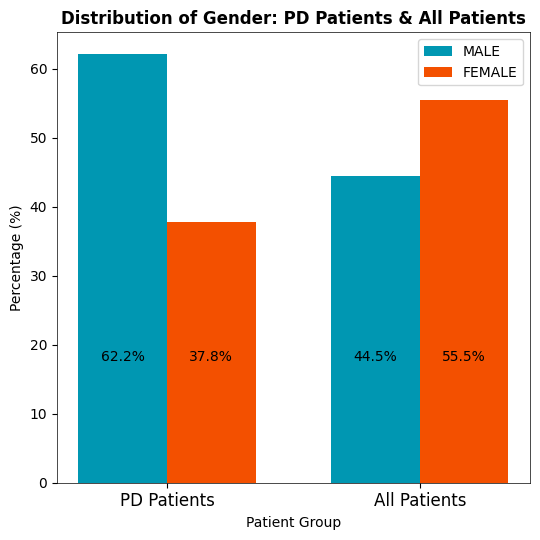

In [104]:
# Plotting the distribution of gender for PD patients vs. all patients
gender_counts = demographics['gender_source_value'].value_counts(normalize=True) * 100
gender_counts_all = demographics_all['gender_source_value'].value_counts(normalize=True)[:2] * 100 # Leaves out 'UNKNOWN' only 1 patient

# Combine percentages into a single DataFrame
combined_percentages = pd.DataFrame({
    "PD Patients": gender_counts,
    "All Patients": gender_counts_all
}).fillna(0)  # Fill NaN values with 0 in case some genders are missing in either group

combined_percentages= combined_percentages.T
# Plotting the percentage distribution of gender for both groups side by side
fig, ax = plt.subplots(figsize=(5.5, 5.5),  dpi=100)
# Color map for the bar chart
colors = plt.cm.tab20.colors

# Calculate the width for each bar group
bar_width = 0.35

# Create the x positions for the bars
x = range(len(combined_percentages.index))

# Plot bars for Parkinson's patients
parkinsons_bars = ax.bar(x, combined_percentages["MALE"], width=bar_width, label="MALE", color=color_azure)

# Plot bars for all patients (shifted by bar_width)
all_patients_bars = ax.bar([i + bar_width for i in x], combined_percentages["FEMALE"], width=bar_width, label="FEMALE", color=color_orange)

# Set plot title and labels
ax.set_title("Distribution of Gender: PD Patients & All Patients", fontsize=12, fontweight='bold')
ax.set_xlabel('Patient Group')
ax.set_ylabel('Percentage (%)')
ax.legend()

# Set the x-axis ticks to be at the center of the bars
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(combined_percentages.index, fontsize=12)

# Calculate the maximum height of the bars
max_height = max(max(parkinsons_bars[i].get_height() for i in range(len(parkinsons_bars))),
                 max(all_patients_bars[i].get_height() for i in range(len(all_patients_bars))))

# Add the percentage values at the same height for both bars
for bar1, bar2 in zip(parkinsons_bars, all_patients_bars):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width() / 2, max_height-45, f"{height1:.1f}%", ha='center', va='bottom', fontsize=10) # This is totallt hardcoded
    ax.text(bar2.get_x() + bar2.get_width() / 2, max_height-45, f"{height2:.1f}%", ha='center', va='bottom', fontsize=10)# This is totallt hardcoded

# Add the percentage values inside each bar
# for bar1, bar2 in zip(parkinsons_bars, all_patients_bars):
#     height1 = bar1.get_height()
#     height2 = bar2.get_height()
#     ax.text(bar1.get_x() + bar1.get_width() / 2, height1 / 2, f"{height1:.1f}%", ha='center', va='center')
#     ax.text(bar2.get_x() + bar2.get_width() / 2, height1 / 2, f"{height2:.1f}%", ha='center', va='center')

plt.xticks()
plt.yticks()
plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['left'].set_color('black')
plt.tight_layout()
plt.savefig('Gender distribution.svg', transparent=True)
plt.show()

In [106]:
demographics['gender_source_value'].value_counts(normalize=False) 

MALE      1693
FEMALE    1031
Name: gender_source_value, dtype: int64

In [107]:
demographics_all['gender_source_value'].value_counts(normalize=False) 

FEMALE     144929
MALE       116224
UNKNOWN         1
Name: gender_source_value, dtype: int64

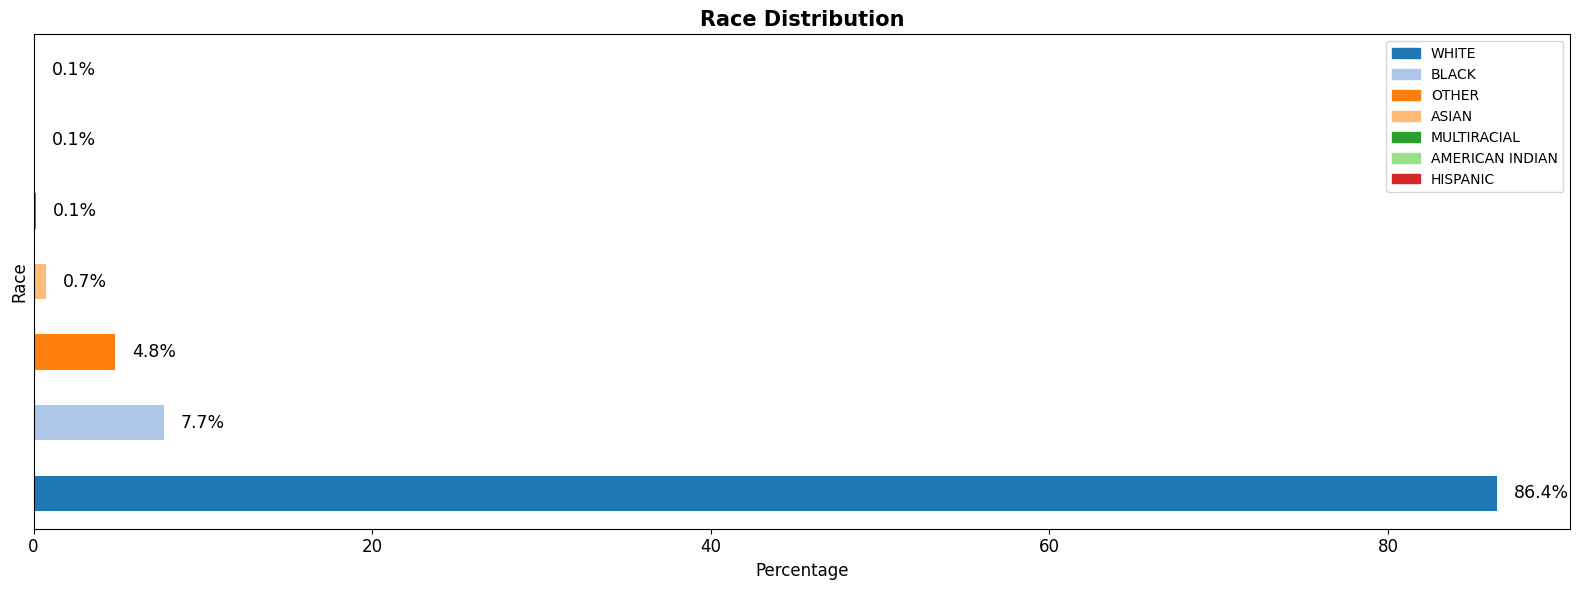

In [108]:
# Sample data (replace this with your actual data from the DataFrame)
race_counts = demographics['race_source_value'].value_counts(normalize=True) * 100

# Create a DataFrame from the data
race_df = pd.DataFrame({'Percentage': race_counts})

# Sort the DataFrame by percentage in descending order
race_df = race_df.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = race_df['Percentage'].plot(kind='barh', figsize=(16, 6), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title('Race Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Race', fontsize=12)

# Add labels to the right of each bar
for i, v in enumerate(race_df['Percentage']):
    plt.text(v + 1, i, f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels
plt.yticks([])
plt.xticks(fontsize=12)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, race_counts.index)]

# Show the custom legend
plt.legend(handles=legend_patches, loc='best')

plt.tight_layout()
plt.show()

In [109]:
demographics['ethnicity_source_value'].value_counts()

NOT HISPANIC    2575
HISPANIC         125
Name: ethnicity_source_value, dtype: int64

In [110]:
race_counts

WHITE              86.437546
BLACK               7.686622
OTHER               4.804139
ASIAN               0.739098
MULTIRACIAL         0.147820
AMERICAN INDIAN     0.110865
HISPANIC            0.073910
Name: race_source_value, dtype: float64

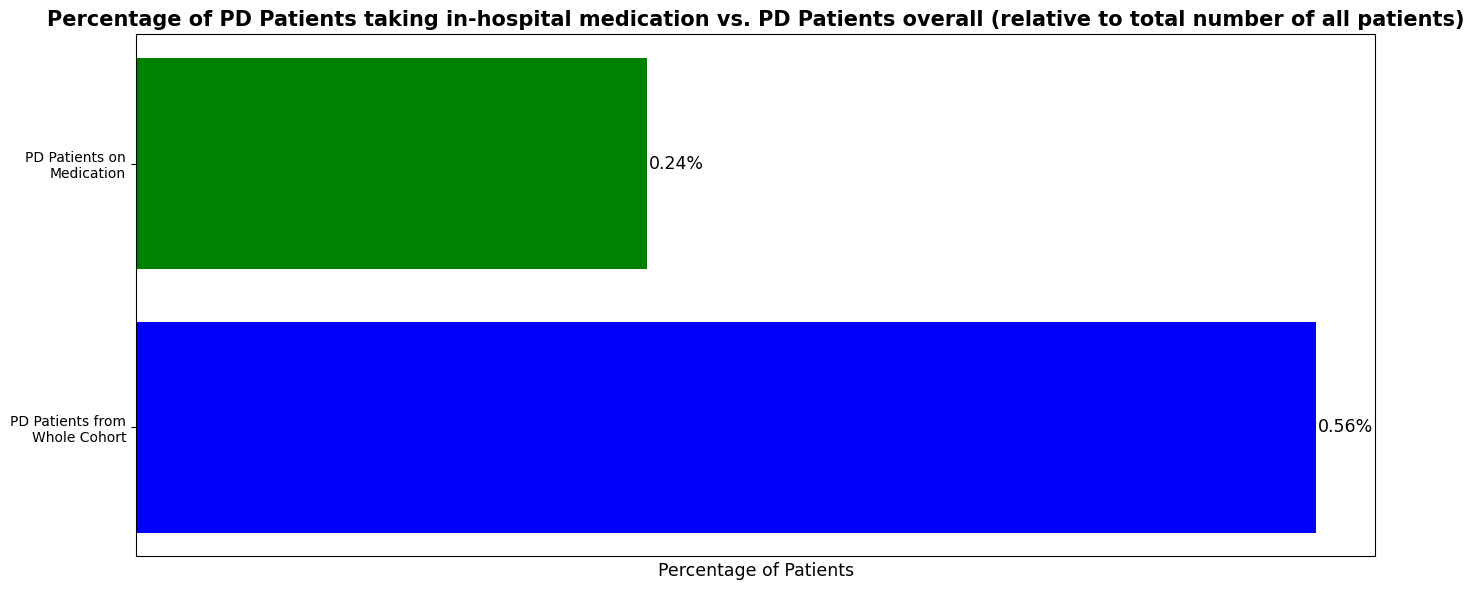

In [111]:
# Calculate the total number of patients in each dataset
total_patients_df = len(df['person_id'].unique())
total_patients_df_pd = len(df_pd['person_id'].unique())
total_patients_demographics_all = len(demographics_all['person_id'].unique())

# Calculate the percentage of PD patients from the whole cohort and PD patients on medication
percentage_pd_patients_df = (total_patients_df / total_patients_demographics_all) * 100
percentage_pd_patients = (total_patients_df_pd / total_patients_demographics_all) * 100

# Create the data for the horizontal bar plot
categories = ['PD Patients from\nWhole Cohort', 'PD Patients on\nMedication']
values = [percentage_pd_patients_df, percentage_pd_patients]

# Set the figure size for the horizontal bar plot
plt.figure(figsize=(14, 6))

# Plot the horizontal bar plot
plt.barh(categories, values, color=['blue', 'green'])
plt.xlabel('Percentage of Patients', fontsize=12.5)
plt.title('Percentage of PD Patients taking in-hospital medication vs. PD Patients overall (relative to total number of all patients)', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks([])

# Display the percentage values inside the bars
for i, v in enumerate(values):
    plt.text(v + 0.0005, i, f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Display the plot
plt.tight_layout()
plt.show()

In [112]:
percentage_pd_patients_df

0.5575254447567336

In [113]:
demographics['person_id'].nunique()

2724

In [114]:
demographics.describe()

person_id          age
count    2724.000000  2724.000000
mean   135025.557636    75.678047
std     74467.138216    10.593838
min       136.000000    22.000000
25%     81478.250000    70.000000
50%    116914.000000    77.000000
75%    202128.000000    83.000000
max    261006.000000   103.000000

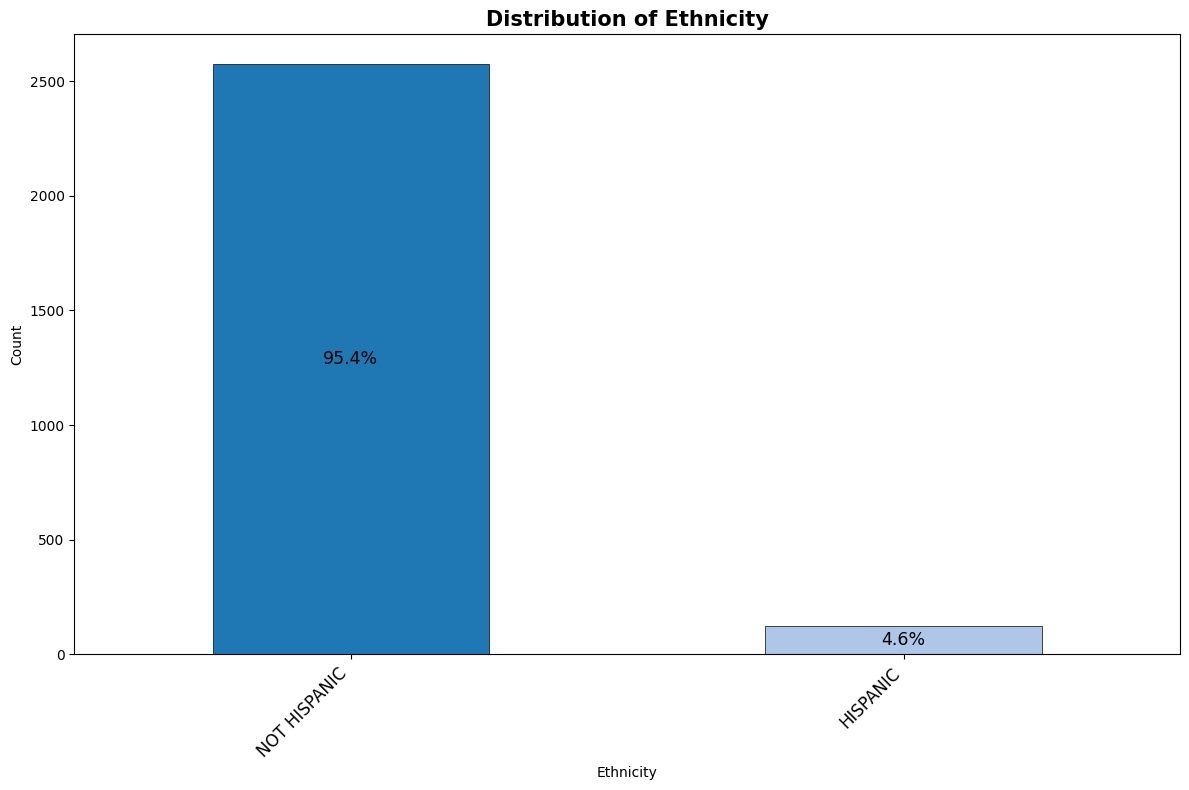

In [115]:
# Plotting value counts of race with percentages
ethnicity = demographics['ethnicity_source_value'].value_counts()
plt.figure(figsize=(12, 8))  # Adjust the values as per your desired size
labels = ethnicity.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = ethnicity.plot(kind='bar', color=colors, edgecolor='black', linewidth=0.5)

# Calculate the percentages
total_count = ethnicity.sum()
percentages = [(count / total_count) * 100 for count in ethnicity]

# Display the percentages inside the bars
ax.bar_label(ax.containers[0], labels=[f"{percentage:.1f}%" for percentage in percentages], label_type='center', fontsize=12.5)

plt.title('Distribution of Ethnicity', fontsize=15, fontweight='bold')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

Actual actual way to deal with this lol

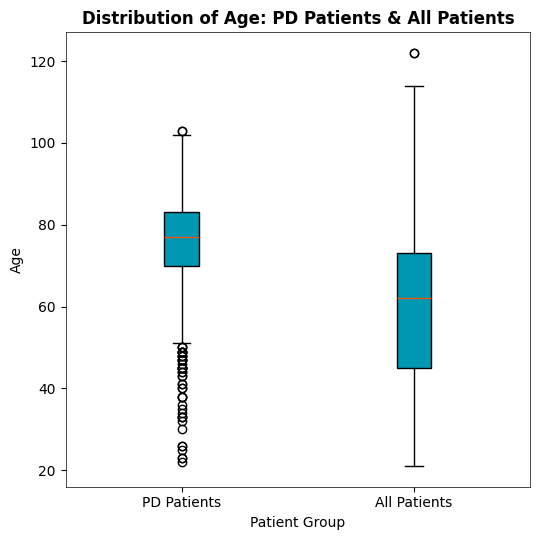

In [116]:
# Plotting the distribution of age for both groups using a box plot
fig, ax = plt.subplots(figsize=(5.5, 5.5),  dpi=100)

# Plot the box plot
ax.boxplot([demographics['age'], demographics_all['age']], labels=["PD Patients", "All Patients"], patch_artist=True, boxprops=dict(facecolor=color_azure), medianprops=dict(color=color_orange))

# Set plot title and labels
ax.set_title("Distribution of Age: PD Patients & All Patients", fontsize=12, fontweight='bold')
ax.set_xlabel('Patient Group')
ax.set_ylabel('Age')
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(0.5)  # Reduce line width
plt.savefig('Age distribution.svg', transparent=True)
plt.show()

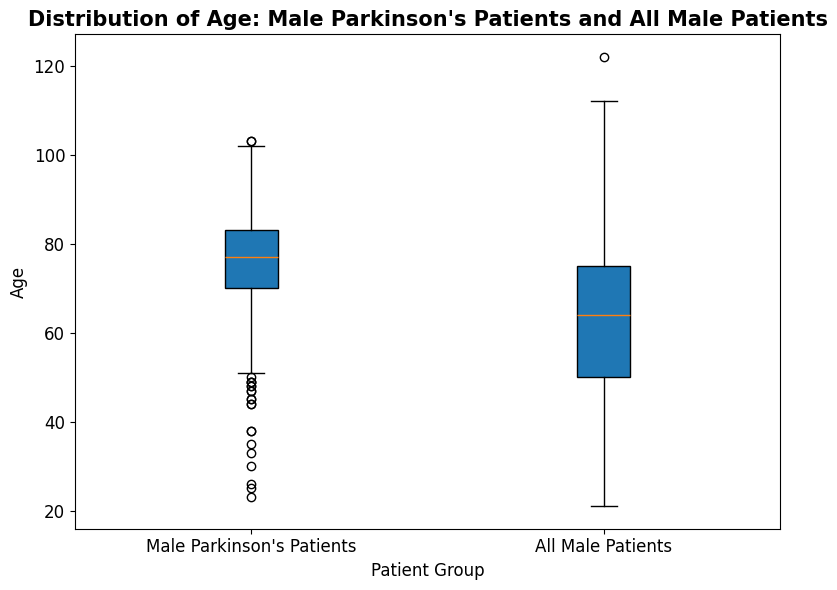

In [117]:
male_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'MALE']['age']
male_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'MALE']['age']# Plotting the distribution of age for both groups using a box plot

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, male_pd_patients_by_age_all], labels=["Male Parkinson's Patients", "All Male Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male Parkinson's Patients and All Male Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

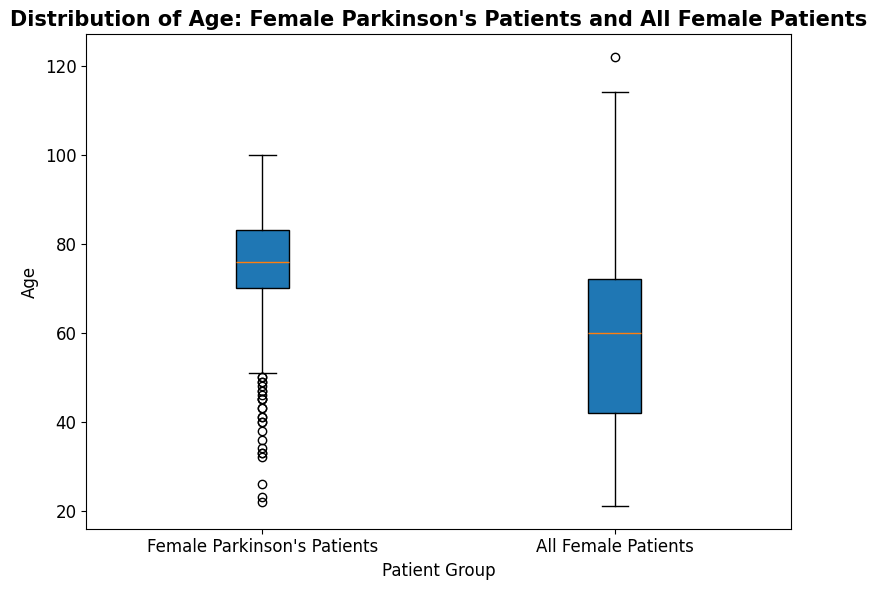

In [118]:
female_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'FEMALE']['age']
female_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'FEMALE']['age']

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([female_pd_patients_by_age, female_pd_patients_by_age_all], labels=["Female Parkinson's Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Female Parkinson's Patients and All Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

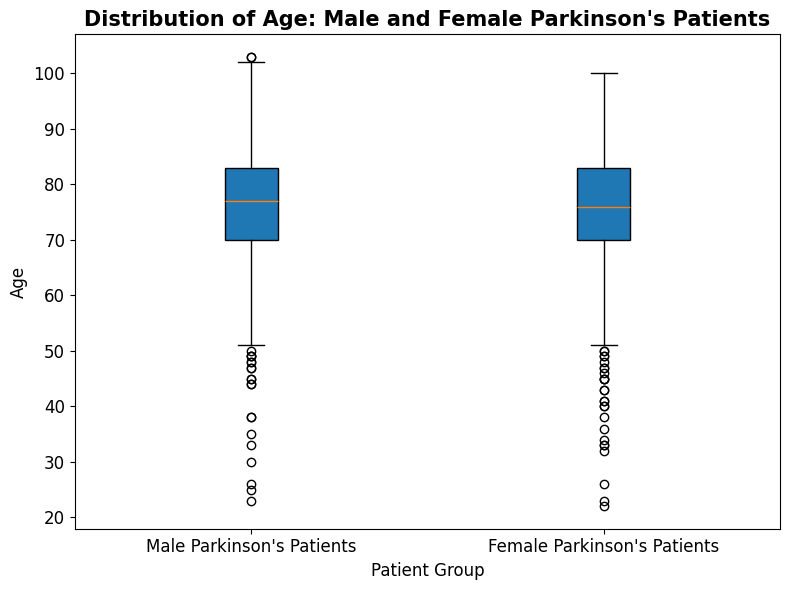

In [119]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, female_pd_patients_by_age], labels=["Male Parkinson's Patients", "Female Parkinson's Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Parkinson's Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

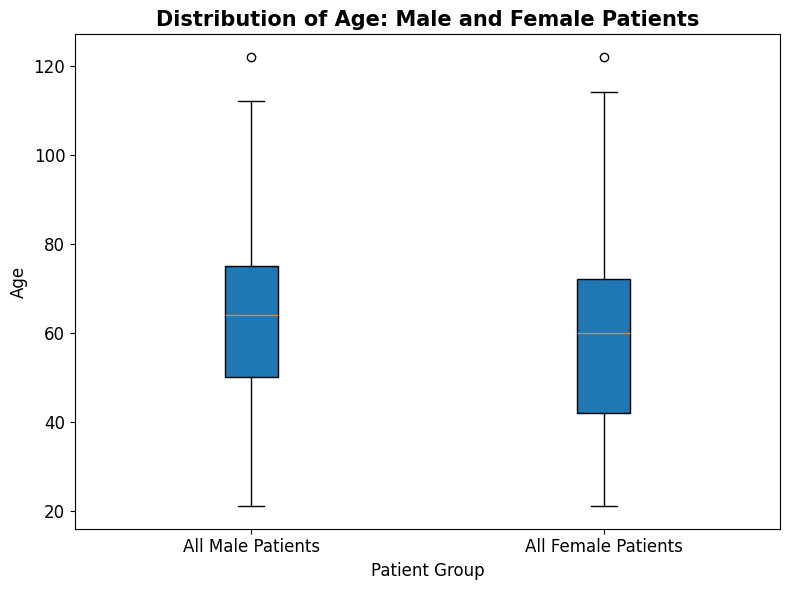

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age_all, female_pd_patients_by_age_all], labels=["All Male Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [121]:
pd_data.value_counts(normalize=True)

generic_name                   brand_name  dosage        
carbidopa-levodopa             sinemet     25-100 mg         0.477759
                               sinemet cr  25-100 mg         0.070507
                               sinemet     12.5-50 mg        0.051743
benztropine                    cogentin    1 mg              0.047544
carbidopa-levodopa             sinemet cr  50-200 mg         0.042689
                                                               ...   
carbidopa-levodopa-entacapone  stalevo     12.5-50-200 mg    0.000175
carbidopa-levodopa er           rytary     95 mg             0.000087
carbidopa                      lodosyn     12.5 mg           0.000087
tolcapone                      tasmar      100 mg            0.000087
amantadine er                  gocovri     274 mg            0.000087
Length: 73, dtype: float64

In [122]:
pd_data['brand_name'].value_counts(normalize=True)

sinemet       0.598478
sinemet cr    0.113196
cogentin      0.079561
mirapex       0.067095
symmetrel     0.038359
comtan        0.034860
artane        0.011022
azilect       0.010629
neupro        0.009972
requip        0.009185
stalevo       0.005336
eldepryl      0.004374
parcopa       0.003543
duopa         0.003543
lodosyn       0.003455
parlodel      0.001881
gocovri       0.001837
rytary        0.001531
tasmar        0.000700
dostinex      0.000350
apokyn        0.000306
IPX203        0.000262
nourianz      0.000219
requip xl     0.000219
 rytary       0.000087
Name: brand_name, dtype: float64

## Distribution of drugs

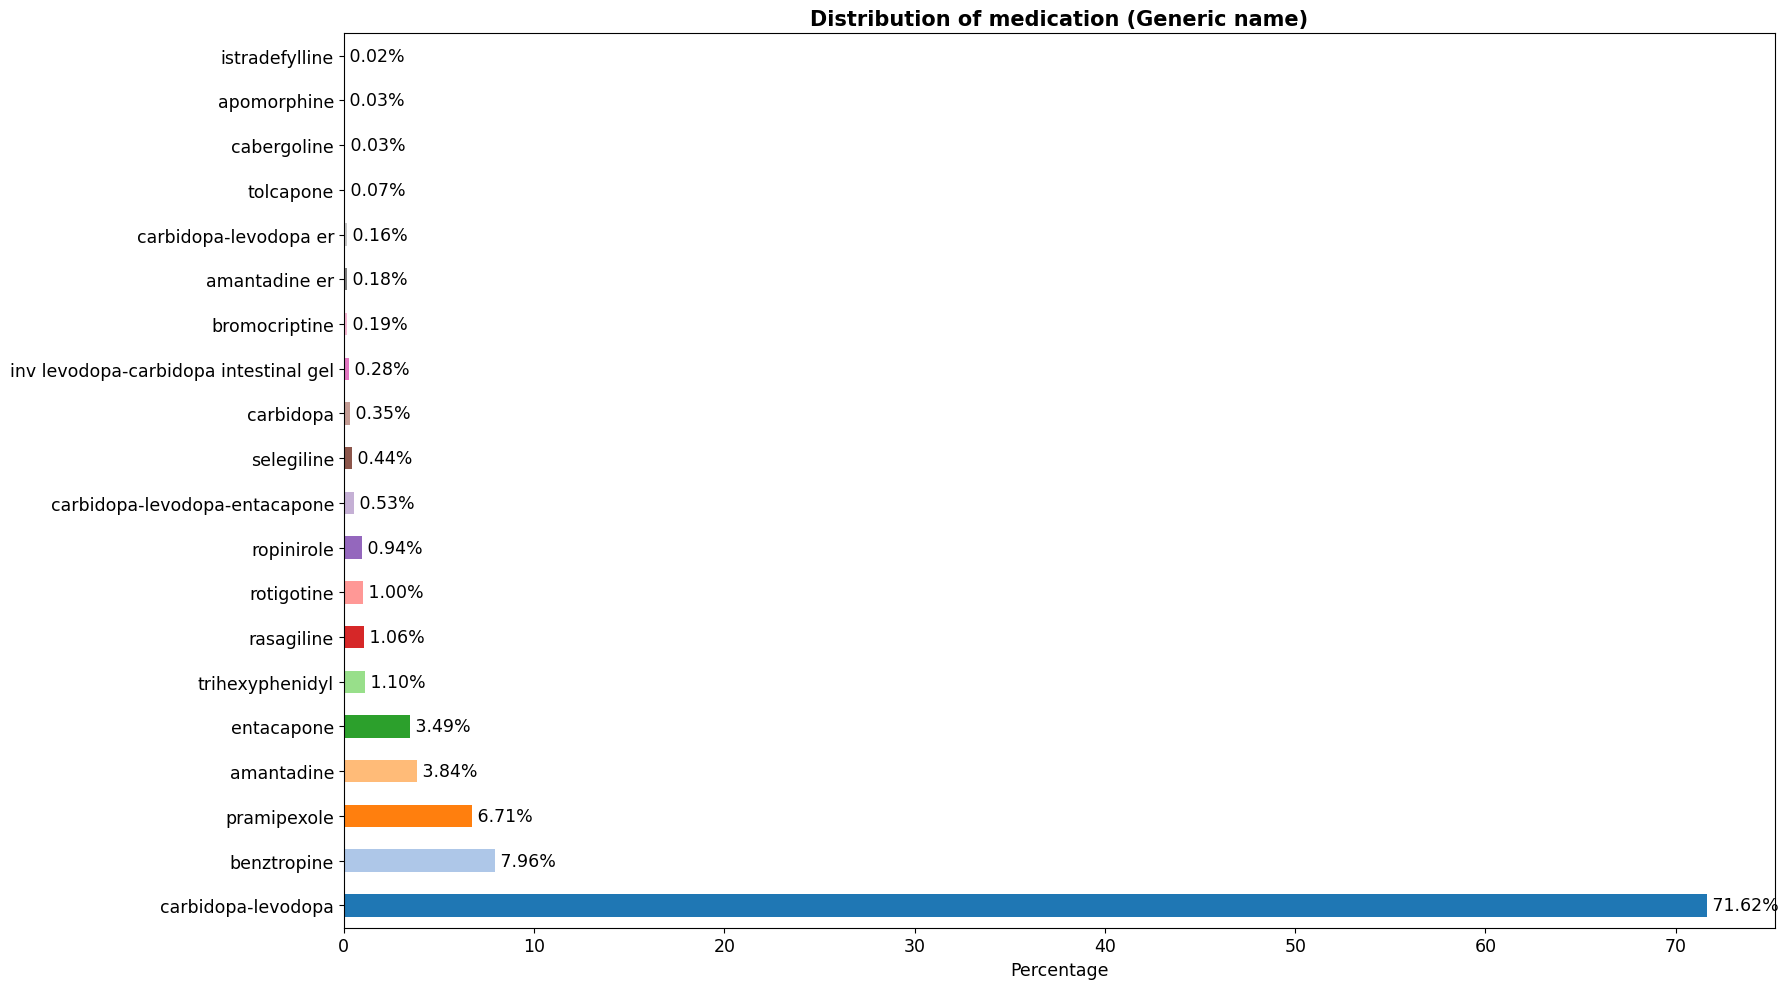

In [123]:
drug_distribution_count = df_pd['generic_name'].value_counts(normalize=True) * 100
drug_distribution = pd.DataFrame({'Percentage': drug_distribution_count})

# Sort the DataFrame by percentage in descending order
drug_distribution = drug_distribution.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_distribution['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Distribution of medication (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_distribution['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_distribution)), drug_distribution.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_distribution.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [124]:
len(pd_data) == len(df_pd)

True

In [125]:
df_pd.iloc[5187]

person_id                                                            248403
age                                                                      72
gender_source_value                                                  FEMALE
race_source_value                                                     BLACK
ethnicity_source_value                                         NOT HISPANIC
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                 carbidopa-levodopa (SINEMET) 25-100 MG per tab...
generic_name                                             carbidopa-levodopa
brand_name                                                          sinemet
dosage                                                            25-100 mg
quantity                                                                1.0
dose_source_value                                                       1.0
dose_unit_source_value                                               tablet
note_text   

In [126]:
pd_data.iloc[5187]

generic_name    carbidopa-levodopa
brand_name                 sinemet
dosage                   25-100 mg
Name: 5187, dtype: object

In [127]:
len(pd_data[pd_data['brand_name'] == 'duopa']) == len(df_pd[df_pd['brand_name'] == 'duopa'])

True

<Axes: >

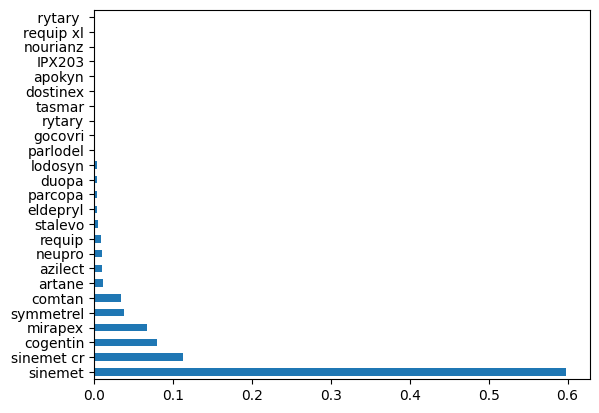

In [128]:
# vlalue_counts: Number of times each unique elements appears
medication_data = pd_data['brand_name'].value_counts(normalize=True)
medication_data.plot(kind='barh')

In [129]:
df_pd.groupby('brand_name')['person_id'].nunique()

brand_name
 rytary         1
IPX203          1
apokyn          1
artane         19
azilect        38
cogentin       42
comtan         29
dostinex        1
duopa           3
eldepryl       13
gocovri         2
lodosyn         8
mirapex        65
neupro         22
nourianz        1
parcopa         5
parlodel        3
requip          8
requip xl       1
rytary          6
sinemet       526
sinemet cr    183
stalevo        11
symmetrel      72
tasmar          2
Name: person_id, dtype: int64

In [130]:
df_pd['brand_name'].nunique()

25

In [131]:
df_pd.columns

Index(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value', 'drug_source_value', 'drug_info',
       'generic_name', 'brand_name', 'dosage', 'quantity', 'dose_source_value',
       'dose_unit_source_value', 'note_text'],
      dtype='object')

In [132]:
# Drug usage per patient
drug_percentage = df_pd.groupby('race_source_value')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_percentage.sort_values(ascending=False)
# drug_percentage

race_source_value
WHITE          0.833597
BLACK          0.099842
OTHER          0.053883
ASIAN          0.007924
MULTIRACIAL    0.001585
Name: person_id, dtype: float64

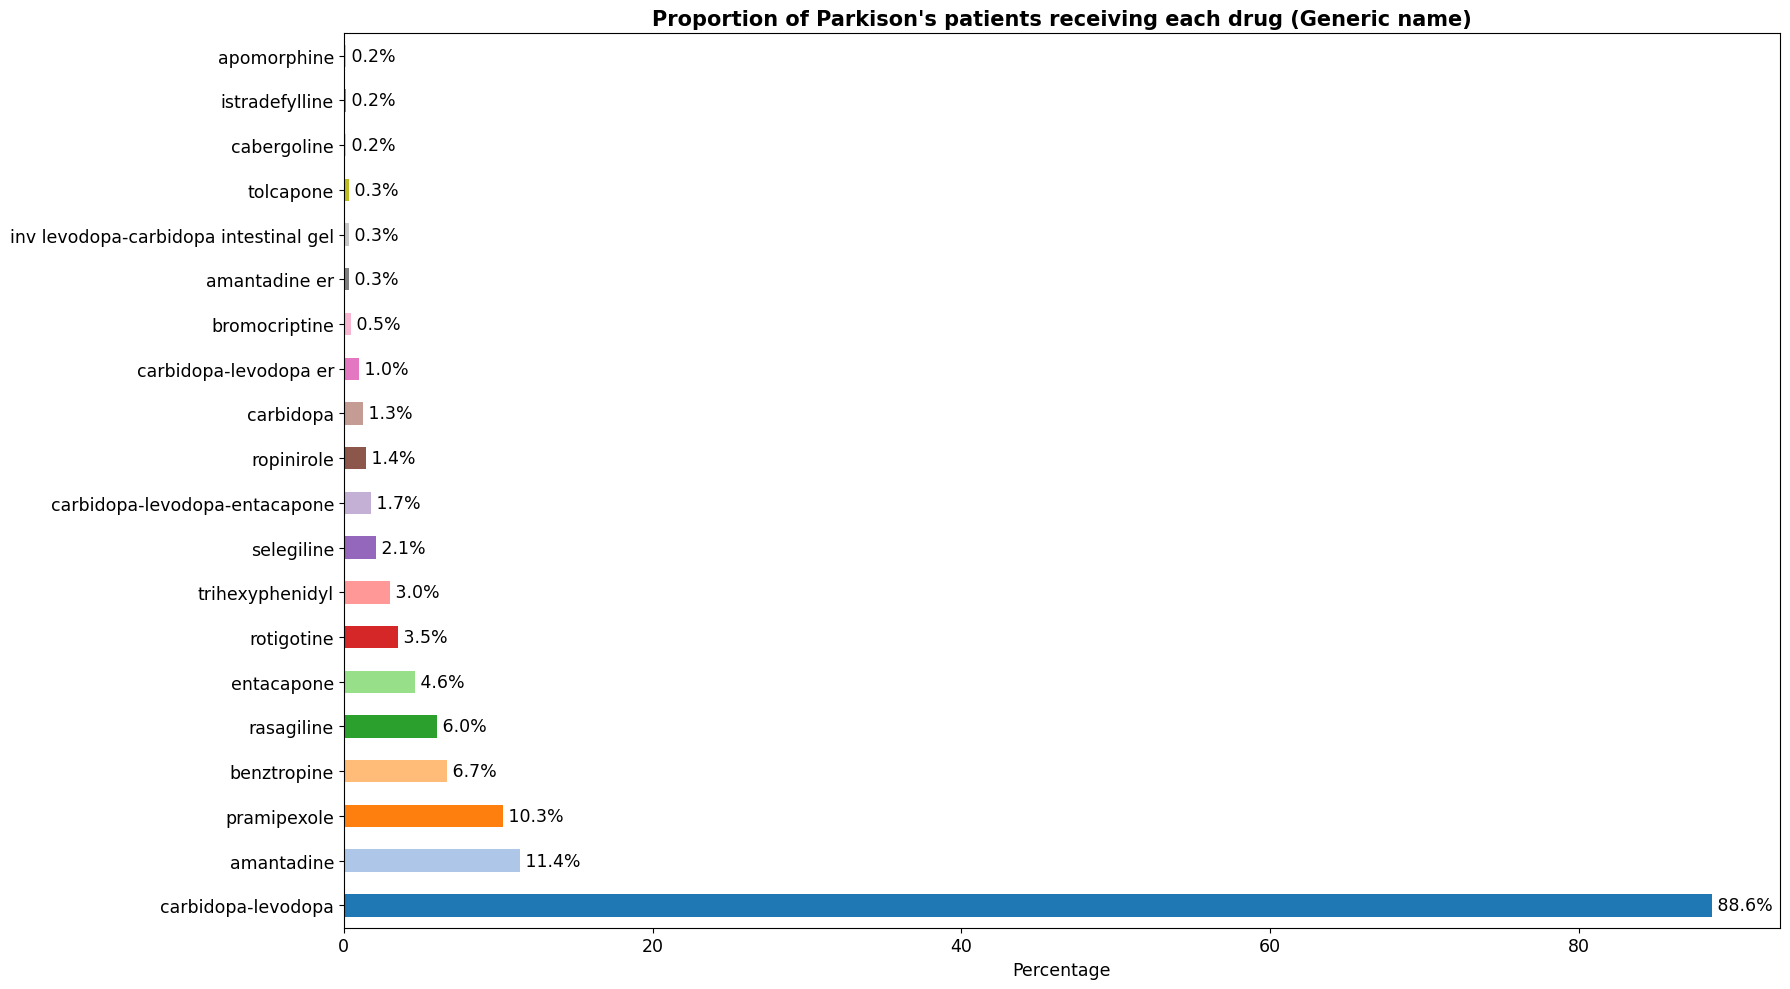

In [133]:
drug_percentage = df_pd.groupby('generic_name')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_popularity_count = drug_percentage * 100
drug_popularity = pd.DataFrame({'Percentage': drug_popularity_count})

# Sort the DataFrame by percentage in descending order
drug_popularity = drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Parkison's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_popularity)), drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


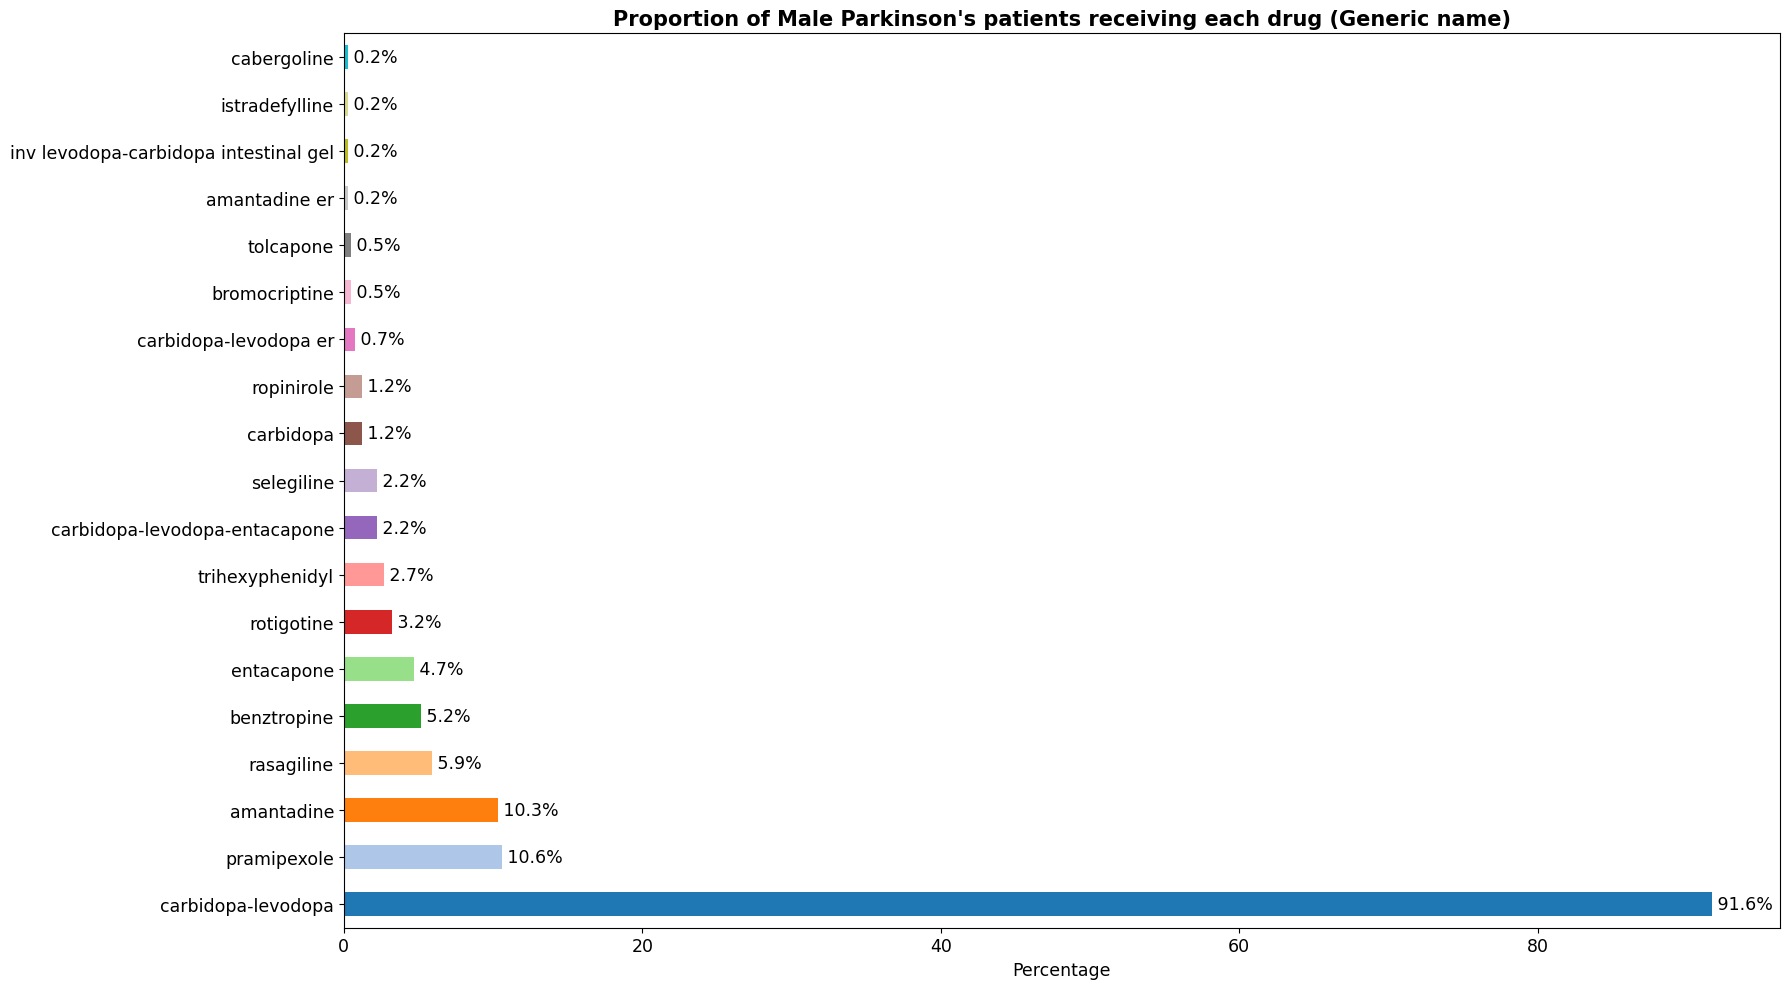

In [134]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
male_pd = df_pd[df_pd['gender_source_value'] == 'MALE']

# Calculate the drug percentage for males
male_drug_percentage = male_pd.groupby('generic_name')['person_id'].nunique() / male_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
male_drug_popularity_count = male_drug_percentage * 100
male_drug_popularity = pd.DataFrame({'Percentage': male_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
male_drug_popularity = male_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = male_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Male Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(male_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(male_drug_popularity)), male_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, male_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


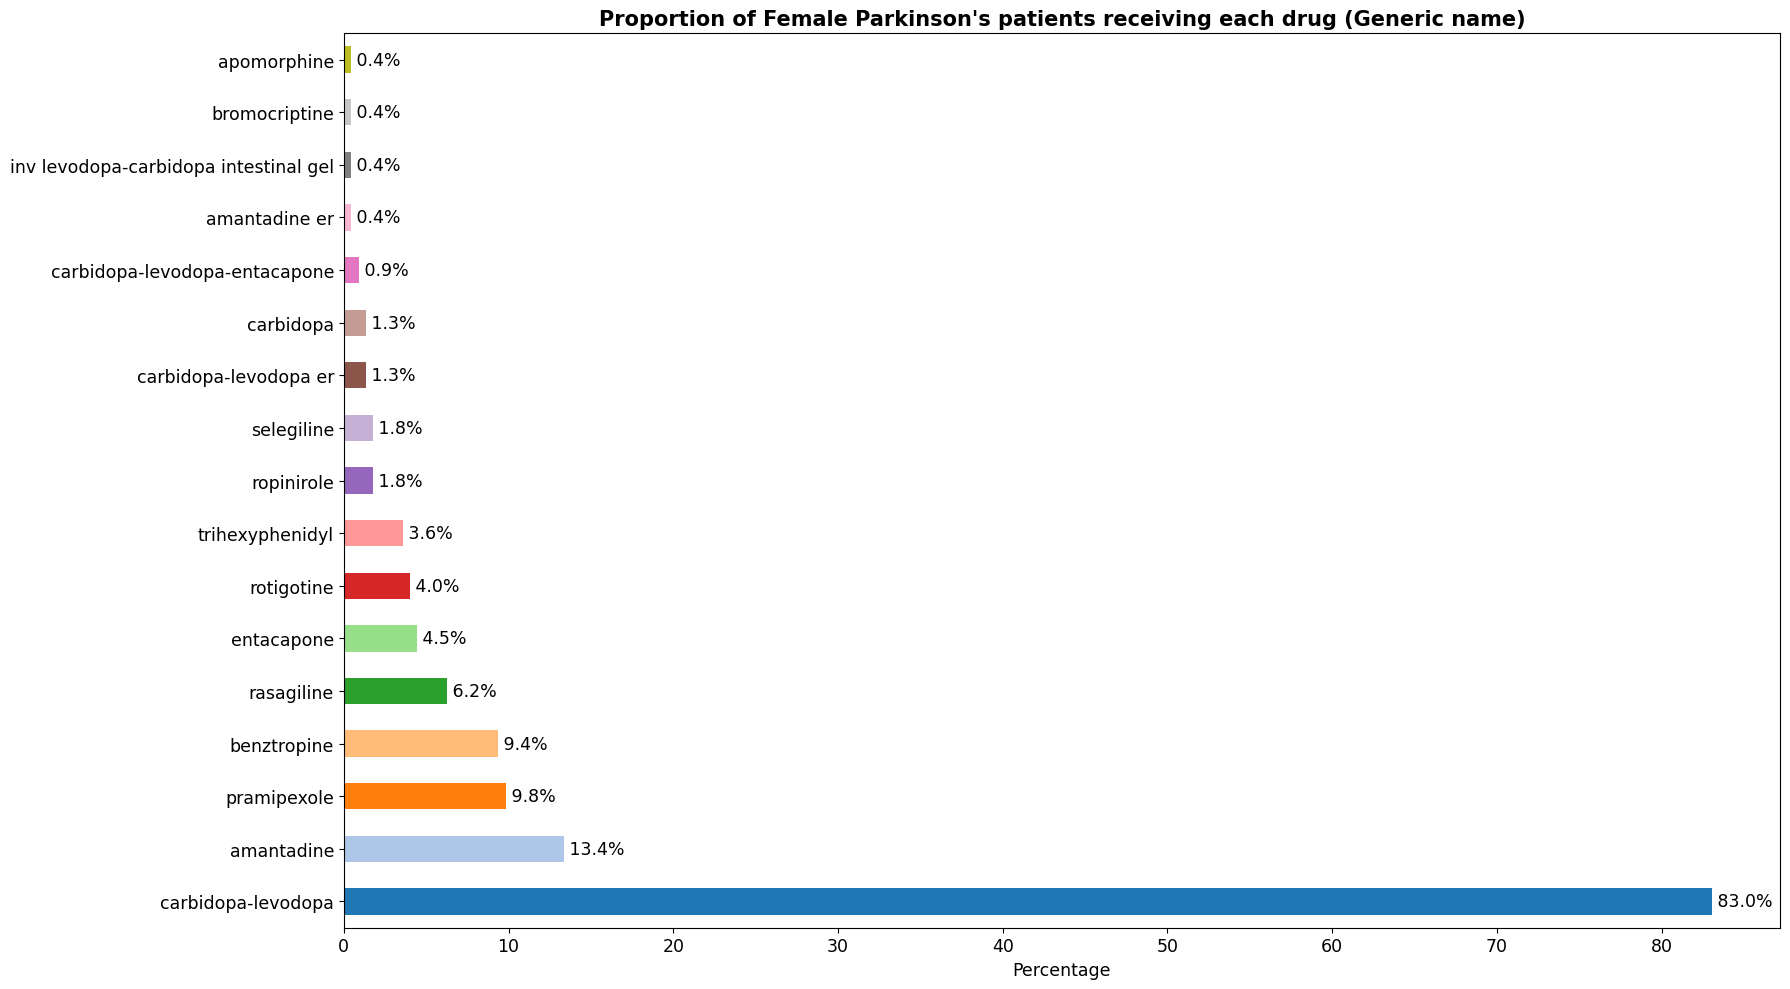

In [135]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
female_pd = df_pd[df_pd['gender_source_value'] == 'FEMALE']

# Calculate the drug percentage for males
female_drug_percentage = female_pd.groupby('generic_name')['person_id'].nunique() / female_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
female_drug_popularity_count = female_drug_percentage * 100
female_drug_popularity = pd.DataFrame({'Percentage': female_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
female_drug_popularity = female_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = female_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Female Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(female_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(female_drug_popularity)), female_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, female_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [136]:
female_drug_popularity['Percentage']

generic_name
carbidopa-levodopa                       83.035714
amantadine                               13.392857
pramipexole                               9.821429
benztropine                               9.375000
rasagiline                                6.250000
entacapone                                4.464286
rotigotine                                4.017857
trihexyphenidyl                           3.571429
ropinirole                                1.785714
selegiline                                1.785714
carbidopa-levodopa er                     1.339286
carbidopa                                 1.339286
carbidopa-levodopa-entacapone             0.892857
amantadine er                             0.446429
inv levodopa-carbidopa intestinal gel     0.446429
bromocriptine                             0.446429
apomorphine                               0.446429
Name: Percentage, dtype: float64

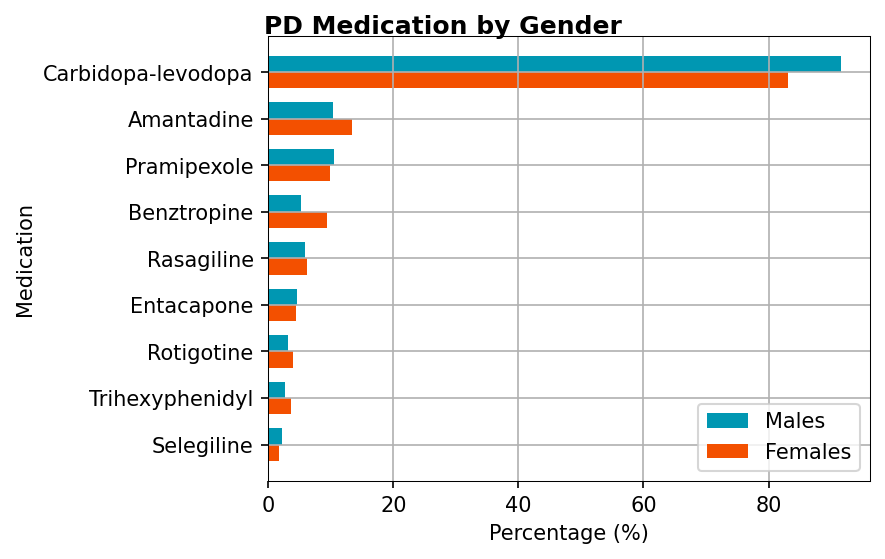

In [137]:
# Assuming you already have these variables as pandas Series
# male_drug_popularity and female_drug_popularity with 'Percentage' as the data and medication names as the index.

# Combine both male and female data for sorting
combined_data = pd.concat([male_drug_popularity, female_drug_popularity], axis=1)
combined_data.columns = ['Males', 'Females']
combined_data.index = combined_data.index.str.capitalize()

# Sort the medications based on the sum of percentages (sorting from higher to lower)
sorted_combined = combined_data.sum(axis=1).sort_values(ascending=False)

# Set a threshold for the percentage
threshold = 3.5  # Adjust the threshold as needed

# Filter medications based on the threshold
filtered_combined = sorted_combined[sorted_combined >= threshold]

# Plotting the data as a horizontal bar plot
plt.figure(figsize=(6.0, 4.0), dpi=150)  # Adjust the figure size as needed

# Increase the width of the bars and adjust figure size for better spacing
width = 0.35

# Bar plot for males
ind_male = range(len(filtered_combined))
bars_male = plt.barh(ind_male, combined_data.loc[filtered_combined.index, 'Males'], height=width, label='Males', color=color_azure)

# Bar plot for females
ind_female = [i + width for i in ind_male]
bars_female = plt.barh(ind_female, combined_data.loc[filtered_combined.index, 'Females'], height=width, label='Females', color=color_orange)

# Adding percentages to the side of the bars
# for i, val in enumerate(combined_data.loc[filtered_combined.index, 'Males']):
#     plt.text(val, i, f'{val:.2f}%', va='center', color='black')

# for i, val in enumerate(combined_data.loc[filtered_combined.index, 'Females']):
#     plt.text(val, i + width, f'{val:.2f}%', va='center', color='black')

# Adding labels, titles, and customizing the plot
plt.xlabel('Percentage (%)')
plt.ylabel('Medication')
plt.suptitle('PD Medication by Gender', weight='bold', fontsize=12, y=0.92, ha='center')
plt.yticks([i + width / 2 for i in ind_male], filtered_combined.index)
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend(loc='lower right')  # Move the legend to upper right for better spacing
plt.tight_layout()
plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(0.5)  # Reduce line width
plt.savefig('PD Medication by Gender.svg', transparent=True)
plt.show()

In [138]:
capitalized = pd.Series([str(x).capitalize() for x in filtered_combined.index])

In [139]:
capitalized

0    Carbidopa-levodopa
1            Amantadine
2           Pramipexole
3           Benztropine
4            Rasagiline
5            Entacapone
6            Rotigotine
7       Trihexyphenidyl
8            Selegiline
dtype: object

In [140]:
df_pd['generic_name'].value_counts(normalize=True) * 100

carbidopa-levodopa                       71.617898
benztropine                               7.956086
pramipexole                               6.709531
amantadine                                3.835892
entacapone                                3.485982
trihexyphenidyl                           1.102218
rasagiline                                1.062853
rotigotine                                0.997244
ropinirole                                0.940384
carbidopa-levodopa-entacapone             0.533613
selegiline                                0.437388
carbidopa                                 0.345536
inv levodopa-carbidopa intestinal gel     0.284302
bromocriptine                             0.188077
amantadine er                             0.183703
carbidopa-levodopa er                     0.161834
tolcapone                                 0.069982
cabergoline                               0.034991
apomorphine                               0.030617
istradefylline                 

In [141]:
drug_percentage

generic_name
amantadine                               0.114105
amantadine er                            0.003170
apomorphine                              0.001585
benztropine                              0.066561
bromocriptine                            0.004754
cabergoline                              0.001585
carbidopa                                0.012678
carbidopa-levodopa                       0.885895
carbidopa-levodopa er                    0.009509
carbidopa-levodopa-entacapone            0.017433
entacapone                               0.045959
inv levodopa-carbidopa intestinal gel    0.003170
istradefylline                           0.001585
pramipexole                              0.103011
rasagiline                               0.060222
ropinirole                               0.014263
rotigotine                               0.034865
selegiline                               0.020602
tolcapone                                0.003170
trihexyphenidyl                      

## Calculating LED (Levodopa Dose Equivalent) for Parkinson's patients

In [142]:
# sig stablished how the medication should be taken by the patient
formatted_series = df_pd['dose_source_value'].unique()
format_func = np.vectorize(lambda x: '{:.4}'.format(x))
bla = np.sort(format_func(formatted_series))
bla

array(['0.0', '0.125', '0.25', '0.33', '0.375', '0.5', '0.75', '1.0',
       '1.25', '1.5', '1.75', '100.0', '12.5', '137.0', '2.0', '2.5',
       '20.0', '200.0', '25.0', '274.0', '3.0', '3.5', '32.0', '4.0',
       '40.0', '5.0', '50.0', '8.0', 'nan'], dtype='<U5')

In [143]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79362  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79363  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79364  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79365  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
79361          12629.0  
79362          12629.0  
79363          12629.0  
79364          12629.0  
79365          12629.0  

[79366 rows x 8 columns]

In [144]:
rasagiline_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '1mg'].index
pd_data_drug_exposure.loc[rasagiline_index, 'dosage'] = '1 mg'
pd_data_drug_exposure.iloc[rasagiline_index]['dosage']

39243    1 mg
39244    1 mg
Name: dosage, dtype: object

In [145]:
entacapone_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '200mg'].index
pd_data_drug_exposure.loc[entacapone_index, 'dosage'] = '200 mg'
pd_data_drug_exposure.iloc[entacapone_index]['dosage']

15678    200 mg
15679    200 mg
15680    200 mg
15681    200 mg
15682    200 mg
15683    200 mg
15684    200 mg
15685    200 mg
15686    200 mg
15687    200 mg
15688    200 mg
15689    200 mg
15690    200 mg
15691    200 mg
15692    200 mg
15693    200 mg
15694    200 mg
15695    200 mg
15696    200 mg
15697    200 mg
15698    200 mg
15699    200 mg
15700    200 mg
15701    200 mg
15702    200 mg
15703    200 mg
15704    200 mg
15705    200 mg
15706    200 mg
15707    200 mg
Name: dosage, dtype: object

In [146]:
pd_data_drug_exposure['dosage']

0        25-100 mg
1        25-100 mg
2        25-100 mg
3        25-100 mg
4        25-100 mg
           ...    
79361    25-100 mg
79362    25-100 mg
79363    25-100 mg
79364    25-100 mg
79365    25-100 mg
Name: dosage, Length: 79366, dtype: object

In [147]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '200 mg', '1 mg', '8 mg', '2 mg',
       '1.5 mg', '5 mg', '48.75-195 mg', '37.5-150-200 mg', '0.125 mg',
       '4 mg', '36.25-145 mg', '12 mg', '6 mg', '0.25 mg', '3 mg',
       '23.75-95 mg', '129 mg', '61.25-245 mg', '1 ml', '137 mg',
       '4.63-20 mg/ml', '50 mg', '2.5 mg', '5-20 mg/ml', '52.5-210 mg',
       '18.75-75-200 mg', '25-100-200 mg', '50-200-200 mg', '0.4 ml',
       '31.25-125-200 mg', '0.375 mg', '0.75 mg', '6mg', '1.25 mg',
       '95 mg', '100mg', '274 mg', '150 mg', '10 mg', '8mg', '1.125 mg',
       '12.5-50-200 mg', '40 mg', '2.25 mg', '0.5-1 mg', '400 mg',
       '600 mg', '12mg', '75 mg', '0.6 ml', '3mg'], dtype=object)

In [148]:
pd_data_drug_exposure['dosage'].unique()[0].split('-')[1].split()[0]

'100'

In [149]:
led_dose = []
for index, item in enumerate(pd_data_drug_exposure['dosage']):
    if isinstance(item, (float, np.floating)) and np.isnan(item):
        led_dose.append('0')
    else:
        if '-' in item:
            dosage = item.split('-')[1].split()[0]
            led_dose.append(dosage)
        else:
            dosage = item.split()[0]
            led_dose.append(dosage)

In [150]:
len(led_dose)

79366

In [151]:
len(pd_data_drug_exposure)

79366

In [152]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if 'levodopa-carbidopa' in item:
        print(item)

inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa

In [153]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'entacapone',
       'rasagiline', 'pramipexole', 'ropinirole', 'selegiline',
       'carbidopa-levodopa er', 'carbidopa-levodopa-entacapone',
       'trihexyphenidyl', 'rotigotine', 'amantadine er', 'apomorphine',
       'inv levodopa-carbidopa intestinal gel', 'cabergoline',
       'pramipexole er', 'bromocriptine', 'tolcapone', '00', 'safinamide',
       'istradefylline'], dtype=object)

In [154]:
pd_data_drug_exposure

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
79361  carbidopa-levodopa    sinemet  25-100 mg
79362  carbidopa-levodopa    sinemet  25-100 mg
79363  carbidopa-levodopa    sinemet  25-100 mg
79364  carbidopa-levodopa    sinemet  25-100 mg
79365  carbidopa-levodopa    sinemet  25-100 mg

[79366 rows x 3 columns]

In [155]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79362  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79363  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79364  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79365  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
79361          12629.0  
79362          12629.0  
79363          12629.0  
79364          12629.0  
79365          12629.0  

[79366 rows x 8 columns]

In [156]:
len(df_pd)

22863

In [157]:
led_df = pd.concat([drug_exposure.iloc[:, 0:3], pd_data_drug_exposure, drug_exposure.iloc[:, 3:]], axis=1)

In [158]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value        generic_name  \
0      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
1      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
2      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
3      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
4      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
...                                                  ...                 ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
79362  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
79363  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
79364  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
79365  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   

      brand_name     dosage  dose_source_value dose_unit_source_value  \
0        sinemet  25-100 mg                2.0                 tablet   
1        sinemet  25-100 mg                2.0                 tablet   
2        sinemet  25-100 mg                2.0                 tablet   
3        sinemet  25-100 mg                2.0                 tablet   
4        sinemet  25-100 mg                2.0                 tablet   
...          ...        ...                ...                    ...   
79361    sinemet  25-100 mg                1.0                 tablet   
79362    sinemet  25-100 mg                1.0                 tablet   
79363    sinemet  25-100 mg                1.0                 tablet   
79364    sinemet  25-100 mg                1.0                 tablet   
79365    sinemet  25-100 mg                1.0                 tablet   

      route_source_value  visit_occurrence_id  visit_detail_id  
0                   ORAL             40422623        9880783.0  
1                   ORAL             40422623        9880783.0  
2                   ORAL             40422623        9880783.0  
3                   ORAL             40422623        9880783.0  
4                   ORAL             40422623        9880783.0  
...                  ...                  ...              ...  
79361               ORAL               104832          12629.0  
79362               ORAL               104832          12629.0  
79363               ORAL               104832          12629.0  
79364               ORAL               104832          12629.0  
79365               ORAL               104832          12629.0  

[79366 rows x 11 columns]

In [159]:
drug_info_drug_source_value

{0: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 2: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 3: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 4: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 5: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 6: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 7: 'amantadine (SYMMETREL) capsule 100 mg',
 8: 'amantadine (SYMMETREL) capsule 100 mg',
 9: 'amantadine (SYMMETREL) capsule 100 mg',
 10: 'amantadine (SYMMETREL) capsule 100 mg',
 11: 'amantadine (SYMMETREL) capsule 100 mg',
 12: 'amantadine (SYMMETREL) capsule 100 mg',
 13: 'amantadine (SYMMETREL) capsule 100 mg',
 14: 'amantadine (SYMMETREL) capsule 100 mg',
 15: 'amantadine (SYMMETREL) capsule 100 mg',
 16: 'amantadine (SYMMETREL) capsule 100 mg',
 17: 'amantadine (SYMMETREL) capsule 100 mg',
 18: 'amantadine (SYMMETREL) capsul

In [160]:
len(led_dose)

79366

In [161]:
led_df.insert(loc=6, column="led_dose", value=led_dose)
led_df.insert(loc=3, column="drug_info", value=drug_info_drug_source_value)
# Properly handling the led_dose and drug_exposure_start_datetime colums
led_df['led_dose'] = pd.to_numeric(led_df['led_dose'], errors='coerce') # Coverting this column to a float type and handling uncommon values
led_df['drug_exposure_start_datetime'] = pd.to_datetime(led_df['drug_exposure_start_datetime'])

In [162]:
len(drug_exposure)

79366

In [163]:
len(pd_data_drug_exposure)

79366

In [164]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79362  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79363  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79364  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79365  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
79361          12629.0  
79362          12629.0  
79363          12629.0  
79364          12629.0  
79365          12629.0  

[79366 rows x 8 columns]

In [165]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...   
79362  {"med_display_name": "carbidopa-levodopa (SINE...   
79363  {"med_display_name": "carbidopa-levodopa (SINE...   
79364  {"med_display_name": "carbidopa-levodopa (SINE...   
79365  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
79361  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79362  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79363  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79364  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79365  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  led_dose  dose_source_value  \
0        sinemet  25-100 mg     100.0                2.0   
1        sinemet  25-100 mg     100.0                2.0   
2        sinemet  25-100 mg     100.0                2.0   
3        sinemet  25-100 mg     100.0                2.0   
4        sinemet  25-100 mg     100.0                2.0   
...          ...        ...       ...                ...   
79361    sinemet  25-100 mg     100.0                1.0   
79362    sinemet  25-100 mg     100.0                1.0   
79363    sinemet  25-100 mg     100.0                1.0   
79364    sinemet  25-100 mg     100.0                1.0   
79365    sinemet  25-100 mg     100.0                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  


Esta bieeeeeeeeeeeeeeeeeeen y funciona

In [166]:
dl = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, tem in enumerate(dl):
    print(index, led_df['person_id'].iloc[index], dl[index]['mar_action'], led_df['drug_source_value'].iloc[index])
len(dl)

0 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
1 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
2 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
3 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
4 261006 HELD {"med_display_name": "

3557

In [167]:
type(led_df[led_df['dose_source_value'] == 0.0]['drug_source_value'])

pandas.core.series.Series

In [168]:
type(led_df.loc[led_df['dose_source_value'] == 0.0, ['drug_source_value']])

pandas.core.frame.DataFrame

In [169]:
bla = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, item in enumerate(bla):
    print(bla[index]['mar_action'])

HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD


We lose 59% percent of patients because their medication was held

In [170]:
print(len(dl)*100/len(df_pd))

15.5578882911254


In [171]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '200 mg', '1 mg', '8 mg', '2 mg',
       '1.5 mg', '5 mg', '48.75-195 mg', '37.5-150-200 mg', '0.125 mg',
       '4 mg', '36.25-145 mg', '12 mg', '6 mg', '0.25 mg', '3 mg',
       '23.75-95 mg', '129 mg', '61.25-245 mg', '1 ml', '137 mg',
       '4.63-20 mg/ml', '50 mg', '2.5 mg', '5-20 mg/ml', '52.5-210 mg',
       '18.75-75-200 mg', '25-100-200 mg', '50-200-200 mg', '0.4 ml',
       '31.25-125-200 mg', '0.375 mg', '0.75 mg', '6mg', '1.25 mg',
       '95 mg', '100mg', '274 mg', '150 mg', '10 mg', '8mg', '1.125 mg',
       '12.5-50-200 mg', '40 mg', '2.25 mg', '0.5-1 mg', '400 mg',
       '600 mg', '12mg', '75 mg', '0.6 ml', '3mg'], dtype=object)

In [172]:
pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '0.5 mg']

generic_name brand_name  dosage
88     benztropine   cogentin  0.5 mg
89     benztropine   cogentin  0.5 mg
90     benztropine   cogentin  0.5 mg
91     benztropine   cogentin  0.5 mg
92     benztropine   cogentin  0.5 mg
...            ...        ...     ...
77615  pramipexole    mirapex  0.5 mg
77616  pramipexole    mirapex  0.5 mg
78580   ropinirole     requip  0.5 mg
78581   ropinirole     requip  0.5 mg
78582   ropinirole     requip  0.5 mg

[2478 rows x 3 columns]

In [173]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '200 mg', '1 mg', '8 mg', '2 mg',
       '1.5 mg', '5 mg', '48.75-195 mg', '37.5-150-200 mg', '0.125 mg',
       '4 mg', '36.25-145 mg', '12 mg', '6 mg', '0.25 mg', '3 mg',
       '23.75-95 mg', '129 mg', '61.25-245 mg', '1 ml', '137 mg',
       '4.63-20 mg/ml', '50 mg', '2.5 mg', '5-20 mg/ml', '52.5-210 mg',
       '18.75-75-200 mg', '25-100-200 mg', '50-200-200 mg', '0.4 ml',
       '31.25-125-200 mg', '0.375 mg', '0.75 mg', '6mg', '1.25 mg',
       '95 mg', '100mg', '274 mg', '150 mg', '10 mg', '8mg', '1.125 mg',
       '12.5-50-200 mg', '40 mg', '2.25 mg', '0.5-1 mg', '400 mg',
       '600 mg', '12mg', '75 mg', '0.6 ml', '3mg'], dtype=object)

In [174]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '200 mg', '1 mg', '8 mg', '2 mg',
       '1.5 mg', '5 mg', '48.75-195 mg', '37.5-150-200 mg', '0.125 mg',
       '4 mg', '36.25-145 mg', '12 mg', '6 mg', '0.25 mg', '3 mg',
       '23.75-95 mg', '129 mg', '61.25-245 mg', '1 ml', '137 mg',
       '4.63-20 mg/ml', '50 mg', '2.5 mg', '5-20 mg/ml', '52.5-210 mg',
       '18.75-75-200 mg', '25-100-200 mg', '50-200-200 mg', '0.4 ml',
       '31.25-125-200 mg', '0.375 mg', '0.75 mg', '6mg', '1.25 mg',
       '95 mg', '100mg', '274 mg', '150 mg', '10 mg', '8mg', '1.125 mg',
       '12.5-50-200 mg', '40 mg', '2.25 mg', '0.5-1 mg', '400 mg',
       '600 mg', '12mg', '75 mg', '0.6 ml', '3mg'], dtype=object)

In [175]:
set(led_dose)

{'0.125',
 '0.25',
 '0.375',
 '0.4',
 '0.5',
 '0.6',
 '0.75',
 '1',
 '1.125',
 '1.25',
 '1.5',
 '10',
 '100',
 '100mg',
 '12',
 '125',
 '129',
 '12mg',
 '137',
 '145',
 '150',
 '195',
 '2',
 '2.25',
 '2.5',
 '20',
 '200',
 '210',
 '245',
 '274',
 '3',
 '3mg',
 '4',
 '40',
 '400',
 '5',
 '50',
 '6',
 '600',
 '6mg',
 '75',
 '8',
 '8mg',
 '95'}

In [176]:
led_df['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'entacapone',
       'rasagiline', 'pramipexole', 'ropinirole', 'selegiline',
       'carbidopa-levodopa er', 'carbidopa-levodopa-entacapone',
       'trihexyphenidyl', 'rotigotine', 'amantadine er', 'apomorphine',
       'inv levodopa-carbidopa intestinal gel', 'cabergoline',
       'pramipexole er', 'bromocriptine', 'tolcapone', '00', 'safinamide',
       'istradefylline'], dtype=object)

In [177]:
led_df[(led_df['brand_name'] == 'rytary') & (led_df['generic_name'] == 'carbidopa-levodopa')]

person_id drug_exposure_start_datetime  \
39238     113382          2019-07-18 06:35:00   
39239     113382          2019-07-17 21:33:00   

                                       drug_source_value  \
39238  {"med_display_name": "NF Carbidopa-Levodopa (R...   
39239  {"med_display_name": "NF Carbidopa-Levodopa (R...   

                                               drug_info        generic_name  \
39238  NF Carbidopa-Levodopa (Rytary) 48.75-195 mg   ...  carbidopa-levodopa   
39239  NF Carbidopa-Levodopa (Rytary) 48.75-195 mg Pa...  carbidopa-levodopa   

      brand_name        dosage  led_dose  dose_source_value  \
39238     rytary  48.75-195 mg     195.0                2.0   
39239     rytary  48.75-195 mg     195.0                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
39238                capsule               ORAL             20724609   
39239                capsule               ORAL             20724609   

       visit_detail_id  
39238        4782583.0  
39239        4782583.0

In [178]:
led_df[led_df['dose_unit_source_value'] == 'tablet']['dose_source_value']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
79361    1.0
79362    1.0
79363    1.0
79364    1.0
79365    1.0
Name: dose_source_value, Length: 59300, dtype: float64

In [179]:
led_df[led_df['dose_unit_source_value'] == 'each']#['dose_source_value'].unique()

person_id drug_exposure_start_datetime  \
9626      245457          2013-03-15 23:27:00   
9627      245457          2013-03-16 23:39:00   
9628      245457          2013-03-17 23:15:00   
9629      245457          2013-03-18 23:00:00   
9630      245457          2013-03-19 23:26:00   
9631      245457          2013-03-21 00:00:00   
9632      245457          2013-03-21 23:14:00   
28462     181509          2011-07-07 22:00:00   
28463     181509          2011-07-08 22:00:00   
28464     181509          2011-07-10 22:00:00   
28465     181509          2011-07-11 22:00:00   
28466     181509          2011-07-09 22:01:00   
30506     175414          2011-05-16 22:00:00   

                                       drug_source_value  \
9626   {"med_display_name": "Inv levodopa-carbidopa i...   
9627   {"med_display_name": "Inv levodopa-carbidopa i...   
9628   {"med_display_name": "Inv levodopa-carbidopa i...   
9629   {"med_display_name": "Inv levodopa-carbidopa i...   
9630   {"med_display_name": "Inv levodopa-carbidopa i...   
9631   {"med_display_name": "Inv levodopa-carbidopa i...   
9632   {"med_display_name": "Inv levodopa-carbidopa i...   
28462  {"med_display_name": "Inv levodopa-carbidopa i...   
28463  {"med_display_name": "Inv levodopa-carbidopa i...   
28464  {"med_display_name": "Inv levodopa-carbidopa i...   
28465  {"med_display_name": "Inv levodopa-carbidopa i...   
28466  {"med_display_name": "Inv levodopa-carbidopa i...   
30506  {"med_display_name": "Inv levodopa-carbidopa i...   

                                              drug_info  \
9626    Inv levodopa-carbidopa intestinal gel pump stop   
9627    Inv levodopa-carbidopa intestinal gel pump stop   
9628    Inv levodopa-carbidopa intestinal gel pump stop   
9629    Inv levodopa-carbidopa intestinal gel pump stop   
9630    Inv levodopa-carbidopa intestinal gel pump stop   
9631    Inv levodopa-carbidopa intestinal gel pump stop   
9632    Inv levodopa-carbidopa intestinal gel pump stop   
28462  Inv levodopa-carbidopa intestinal gel pump stop    
28463  Inv levodopa-carbidopa intestinal gel pump stop    
28464  Inv levodopa-carbidopa intestinal gel pump stop    
28465  Inv levodopa-carbidopa intestinal gel pump stop    
28466  Inv levodopa-carbidopa intestinal gel pump stop    
30506  Inv levodopa-carbidopa intestinal gel pump stop    

                                generic_name brand_name         dosage  \
9626   inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
9627   inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
9628   inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
9629   inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
9630   inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
9631   inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
9632   inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
28462  inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
28463  inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
28464  inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
28465  inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
28466  inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   
30506  inv levodopa-carbidopa intestinal gel      duopa  4.63-20 mg/ml   

       led_dose  dose_source_value dose_unit_source_value route_source_value  \
9626       20.0                NaN                   each         PEG-J TUBE   
9627       20.0                NaN                   each         PEG-J TUBE   
9628       20.0                NaN                   each         PEG-J TUBE   
9629       20.0                NaN                   each         PEG-J TUBE   
9630       20.0                NaN                   each         PEG-J TUBE   
9631       20.0                0.0                   each         PEG-J TUBE   
9632       20.0                0.0                   ea

In [180]:
led_df[led_df['dose_unit_source_value'] != 'tablet'].sample(20)

person_id drug_exposure_start_datetime  \
27753     187199          2017-06-04 13:10:00   
47909     100767          2017-08-23 08:56:00   
5681      253712          2018-04-18 06:19:00   
11490     228784          2013-12-14 09:03:00   
53940      83991          2019-03-14 21:38:00   
62761      60224          2020-03-13 09:01:00   
54467      83371          2018-10-25 21:03:00   
6439      253316          2017-10-04 14:09:00   
59353      72576          2015-06-10 08:46:00   
24499     201787          2018-03-13 15:46:00   
1823      258918          2014-05-16 08:09:00   
10347     238908          2016-06-25 08:55:00   
34586     138583          2020-06-11 09:57:00   
7485      249890          2016-08-22 21:28:00   
55172      81988          2015-08-10 10:00:00   
16305     216583          2020-07-23 12:25:00   
24507     201787          2018-03-16 05:35:00   
61564      65943          2014-04-06 08:37:00   
43290     106450          2017-05-11 21:19:00   
13857     220757          2017-06-26 21:36:00   

                                       drug_source_value  \
27753  {"med_display_name": "tolcapone (TASMAR) table...   
47909  {"med_display_name": "rotigotine (NEUPRO) 1 MG...   
5681   {"med_display_name": "amantadine (SYMMETREL) c...   
11490  {"med_display_name": "pramipexole (MIRAPEX) ta...   
53940  {"med_display_name": "****Patient supplied med...   
62761  {"med_display_name": "entacapone (COMTAN) tabl...   
54467  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
6439   {"med_display_name": "rOPINIRole (REQUIP) tabl...   
59353  {"med_display_name": "rasagiline mesylate (AZI...   
24499  {"med_display_name": "entacapone (COMTAN) tabl...   
1823   {"med_display_name": "trihexyphenidyl (ARTANE)...   
10347  {"med_display_name": "pramipexole (MIRAPEX) ta...   
34586  {"med_display_name": "pramipexole (MIRAPEX) ta...   
7485   {"med_display_name": "benztropine (COGENTIN) t...   
55172  {"med_display_name": "rasagiline mesylate (AZI...   
16305  {"med_display_name": "entacapone (COMTAN) tabl...   
24507  {"med_display_name": "entacapone (COMTAN) tabl...   
61564  {"med_display_name": "amantadine (SYMMETREL) s...   
43290  {"med_display_name": "benztropine (COGENTIN) t...   
13857  {"med_display_name": "pramipexole (MIRAPEX) ta...   

                                               drug_info  \
27753                   tolcapone (TASMAR) tablet 200 mg   
47909        rotigotine (NEUPRO) 1 MG/24HR patch 1 patch   
5681               amantadine (SYMMETREL) capsule 100 mg   
11490               pramipexole (MIRAPEX) tablet 0.75 mg   
53940  ****Patient supplied medication - Carbidopa-Le...   
62761                  entacapone (COMTAN) tablet 200 mg   
54467  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
6439                  rOPINIRole (REQUIP) tablet 0.25 mg   
59353          rasagiline mesylate (AZILECT) tablet 1 mg   
24499                  entacapone (COMTAN) tablet 200 mg   
1823                trihexyphenidyl (ARTANE) tablet 4 mg   
10347                  pramipexole (MIRAPEX) tablet 1 mg   
34586                pramipexole (MIRAPEX) tablet 0.5 mg   
7485                  benztropine (COGENTIN) tablet 2 mg   
55172          rasagiline mesylate (AZILECT) tablet 1 mg   
16305                  entacapone (COMTAN) tablet 200 mg   
24507                  entacapone (COMTAN) tablet 200 mg   
61564             amantadine (SYMMETREL) solution 100 mg   
43290                 benztropine (COGENTIN) tablet 1 mg   
13857               pramipexole (MIRAPEX) tablet 0.25 mg   

                generic_name brand_name        dosage  led_dose  \
27753              tolcapone     tasmar        200 mg    200.00   
47909             rotigotine     neupro          1 mg      1.00   
5681              amantadine  symmetrel        100 mg    100.00   
11490            pramipexole    mirapex       0.75 mg      0.75   
53940  carbidopa-levodopa er     rytary  48.75-195 mg    195.00   
62761             entacapone     comtan        200 mg

Difference betwen ryrary and duopa??
Rytary is carbidopa-levodopa extended release and suopa is carbidopa-levodopa enteral suspension

In [181]:
sorted(led_df['generic_name'].unique())

['00',
 'amantadine',
 'amantadine er',
 'apomorphine',
 'benztropine',
 'bromocriptine',
 'cabergoline',
 'carbidopa-levodopa',
 'carbidopa-levodopa er',
 'carbidopa-levodopa-entacapone',
 'entacapone',
 'inv levodopa-carbidopa intestinal gel',
 'istradefylline',
 'pramipexole',
 'pramipexole er',
 'rasagiline',
 'ropinirole',
 'rotigotine',
 'safinamide',
 'selegiline',
 'tolcapone',
 'trihexyphenidyl']

Setting conversion factors for Parkinson's drugs and calculating LED

In [182]:
# Conversion factors from: https://movementdisorders.onlinelibrary.wiley.com/doi/full/10.1002/mds.29410
conversion_factors = {
    'amantadine': 1.0,
    'amantadine er': 1.25, 
    'apomorphine': 10.0,
    # trihexyphenidyl and benztropine aren't as unified but the paper proposes a conversion factor of 1
    'benztropine': 1.0,
    'benztropine mesylate': 1.0,
    'bromocriptine': 10.0,
    'cabergoline': 66.7,
    'carbidopa-levodopa': 1.0,
    'inv carbidopa-levodopa intestinal gel': 1.0,
    'inv carbidopa-levodopa intestinal gel pump': 1.0,
    'carbidopa': 0.1,
    'carbidopa-levodopa er': 0.5,
    'carbidopa-levodopa-entacapone': 1.33,
    'entacapone': 1.33, # Double-check this
    'pramipexole': 100.0,
    'pramipexole er': 100.0,
    'trihexyphenidyl': 1.0,
    'rasagiline': 100.0,
    ' rasagiline mesylate': 100.0,
    'ropinirole': 20.0,
    'rotigotine': 30.0, 
    'selegiline': 10.0, # All the rows relating to selegiline are oral
    'tolcapone': 1.5,
    'ropinirole': 0.5,
}

# Convert 'drug_exposure_start_datetime' to datetime format
def calculate_led(row):
    """ The logic goes as follows: We will map the conversion factors to the generic_name found in the led_df dataframe. All of the generic_names are contained into the dictionary.
    We check the led_dose calculated. If it's equal to the dose_source_value it means that the medication is probably carbidopa-levodopa, so we will skip it and we do that by setting dose_source_value to 1.
    That way when we multiply it will be as if nothing happened.

    Then we check if dose_source_value is zero. If that happends, then that drug was not administered but held (look at mar_action in the drug_source column). If it's zero we put the equivalent to np.nan into that row

    If everything goes well and the dose_source_value is actually something we can work with, then the led will be the multiplication of the dose_sourve_value, the led_dose and the conversion factor

    If the dose_source_value is something we can't work with, the led will exclude that info from the multiplication.

    At the end we apply the function into a new column called led. 
    """
    dose_source_value = row['dose_source_value']
    led_dose = row['led_dose']
    conversion_factor = conversion_factors.get(row['generic_name'], 0)
    if led_dose == dose_source_value:
        dose_source_value = 1.0
    if dose_source_value == 0.0:
        return None
    if pd.notna(dose_source_value):
        return dose_source_value * row['led_dose'] * conversion_factor
    else:
        return row['led_dose'] * conversion_factor

led_df['led'] = led_df.apply(calculate_led, axis=1)

Adding diagnosis date

In [183]:
# led_df[led_df['generic_name']]

In [184]:
diagnosis_date = pd.read_csv('data/DIAGNOSIS_DATE.csv')
diagnosis_date["diagnosis_date"] = pd.to_datetime(diagnosis_date["diagnosis_date"], format='%Y-%m-%d')

# led_df = led_df.merge(diagnosis_date, on='person_id', how='inner')
# led_df = led_df[['person_id', 'drug_exposure_start_datetime', 'diagnosis_date', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'led_dose', 'dose_source_value', 'dose_unit_source_value', 'route_source_value','visit_occurrence_id', 'visit_detail_id', 'led']]

Different kinds of LED by patient, administration date, drug, and visit

In [185]:
# We use the aggreagte function to find the min and max date of drugs being administered
# TODO: Estoy usando el min y el max de la fecha de administracion de la droga, pero deberia usar el min y el max de la fecha de la visita
patient_stay = led_df.groupby('person_id')['drug_exposure_start_datetime'].agg(['min', 'max']).reset_index()
# Compute the mean LED per patiient
mean_led_per_patient = led_df.groupby('person_id')['led'].mean().reset_index() # Mean LED per patient
mean_led_per_administration_date= led_df.groupby(['person_id', led_df['drug_exposure_start_datetime'].dt.date])['led'].mean().reset_index()
mean_led_per_drug = led_df.groupby(['person_id', led_df['generic_name']])['led'].mean().reset_index()
# mean_led_per_visit = led_df.groupby(['person_id', led_df['visit_occurrence_id']])['led'].mean().reset_index()
# Assing the mean LED to the DataFrame
patient_stay['mean_led_per_patient'] = mean_led_per_patient['led']
patient_stay['mean_led_per_administration_date'] = mean_led_per_administration_date['led']
patient_stay['mean_led_per_drug'] = mean_led_per_drug['led']
# patient_stay['mean_led_per_visit'] = mean_led_per_visit['led']
# Compute and add the patient stay in format days and hours, and patient stay in years
patient_stay['stay'] = patient_stay['max'] - patient_stay['min']
patient_stay['stay_in_years'] = (patient_stay['max'] - patient_stay['min']) / np.timedelta64(1, 'Y')
# Sort values by patient stay
# patient_stay = patient_stay[['person_id', 'stay', 'stay_in_years', 'mean_led_per_patient', 'mean_led_per_administration_date', 'mean_led_per_drug', 'mean_led_per_visit' ]].sort_values(by=['stay_in_years'], ascending=False)
patient_stay = patient_stay[['person_id', 'stay', 'stay_in_years', 'mean_led_per_patient', 'mean_led_per_administration_date', 'mean_led_per_drug' ]].sort_values(by=['stay_in_years'], ascending=False)

In [186]:
patient_stay

person_id               stay  stay_in_years  mean_led_per_patient  \
141       35122 3606 days 14:16:00       9.874520             29.094828   
155       41178 3419 days 20:52:00       9.363285            196.733108   
1100     216583 3348 days 19:06:00       9.168692            137.073594   
615      107324 3346 days 19:17:00       9.163237            188.888889   
1305     253410 3308 days 21:15:00       9.059421            194.502618   
...         ...                ...            ...                   ...   
746      123022    0 days 00:00:00       0.000000            100.000000   
195       51920    0 days 00:00:00       0.000000            100.000000   
175       46170    0 days 00:00:00       0.000000            100.000000   
294       70257    0 days 00:00:00       0.000000              0.500000   
712      115910    0 days 00:00:00       0.000000              2.000000   

      mean_led_per_administration_date  mean_led_per_drug  
141                              100.0           3.000000  
155                              100.0          50.000000  
1100                             100.0         100.000000  
615                              125.0         100.000000  
1305                             200.0         100.000000  
...                                ...                ...  
746                              100.0         190.833333  
195                              100.0         300.000000  
175                              125.0           1.000000  
294                              150.0         188.571429  
712                              200.0                NaN  

[1424 rows x 6 columns]

In [187]:
mean_led_per_administration_date

person_id drug_exposure_start_datetime    led
0            136                   2016-12-15    1.0
1            136                   2016-12-16    1.0
2            136                   2017-03-26    NaN
3            136                   2017-03-27    1.0
4            136                   2017-03-28    1.0
...          ...                          ...    ...
20541     260996                   2013-05-28  100.0
20542     260996                   2013-05-29  100.0
20543     260996                   2013-05-30  100.0
20544     261006                   2021-04-11  200.0
20545     261006                   2021-04-12  200.0

[20546 rows x 3 columns]

In [188]:
mean_led_per_drug

person_id        generic_name         led
0           136         benztropine    1.000000
1           136  carbidopa-levodopa  100.000000
2           668  carbidopa-levodopa  100.000000
3           668         pramipexole   12.500000
4           936  carbidopa-levodopa  100.000000
...         ...                 ...         ...
2340     260956  carbidopa-levodopa  140.625000
2341     260996          amantadine  100.000000
2342     260996         benztropine    0.500000
2343     260996  carbidopa-levodopa  104.377565
2344     261006  carbidopa-levodopa  200.000000

[2345 rows x 3 columns]

In [189]:
patient_stay

person_id               stay  stay_in_years  mean_led_per_patient  \
141       35122 3606 days 14:16:00       9.874520             29.094828   
155       41178 3419 days 20:52:00       9.363285            196.733108   
1100     216583 3348 days 19:06:00       9.168692            137.073594   
615      107324 3346 days 19:17:00       9.163237            188.888889   
1305     253410 3308 days 21:15:00       9.059421            194.502618   
...         ...                ...            ...                   ...   
746      123022    0 days 00:00:00       0.000000            100.000000   
195       51920    0 days 00:00:00       0.000000            100.000000   
175       46170    0 days 00:00:00       0.000000            100.000000   
294       70257    0 days 00:00:00       0.000000              0.500000   
712      115910    0 days 00:00:00       0.000000              2.000000   

      mean_led_per_administration_date  mean_led_per_drug  
141                              100.0           3.000000  
155                              100.0          50.000000  
1100                             100.0         100.000000  
615                              125.0         100.000000  
1305                             200.0         100.000000  
...                                ...                ...  
746                              100.0         190.833333  
195                              100.0         300.000000  
175                              125.0           1.000000  
294                              150.0         188.571429  
712                              200.0                NaN  

[1424 rows x 6 columns]

In [190]:
years_of_stay = patient_stay[patient_stay['stay_in_years'] >= 3]
years_of_stay_person_id = years_of_stay['person_id'].tolist()

In [191]:
years_of_stay_person_id

[35122,
 41178,
 216583,
 107324,
 253410,
 229924,
 105518,
 213120,
 65574,
 253711,
 8510,
 47992,
 114674,
 76382,
 21409,
 82728,
 215395,
 153163,
 222938,
 81742,
 158001,
 243410,
 134638,
 196471,
 83446,
 257569,
 252255,
 126970,
 47229,
 201711,
 113218,
 212715,
 99932,
 209423,
 21664,
 104620,
 68602,
 235373,
 21186,
 106450,
 249161,
 104337,
 42075,
 104666,
 252548,
 58502,
 220195,
 230650,
 5997,
 68220,
 21973,
 180079,
 77974,
 17203,
 99551,
 65578,
 91263,
 69729,
 13600,
 92623,
 160801,
 215742,
 52721,
 109467,
 249691,
 155544,
 90832,
 109750,
 69388,
 109310,
 249643,
 76503,
 103442,
 84870,
 256708,
 81988,
 245208,
 150341,
 93977,
 258899,
 28080,
 106439,
 247440,
 100791,
 109654,
 259937,
 53571,
 102364,
 64308,
 95126,
 65122,
 93458,
 51477,
 147080,
 234048,
 79180,
 258074,
 238662,
 103424,
 97519,
 113851,
 256706,
 100625,
 56513,
 204379,
 201132,
 80373,
 71064,
 94999,
 205200,
 198706,
 107090,
 258015,
 234554,
 21950,
 175532,
 14821,

In [192]:
mean_led_per_administration_date[mean_led_per_administration_date['person_id'] == years_of_stay_person_id[0]].sort_values(by='drug_exposure_start_datetime')

person_id drug_exposure_start_datetime   led
2881      35122                   2011-06-21  25.0
2882      35122                   2011-06-22  25.0
2883      35122                   2011-06-23  25.0
2884      35122                   2011-06-24  25.0
2885      35122                   2011-06-25  25.0
...         ...                          ...   ...
2962      35122                   2021-05-01  25.0
2963      35122                   2021-05-02  25.0
2964      35122                   2021-05-03  25.0
2965      35122                   2021-05-04  25.0
2966      35122                   2021-05-05  25.0

[86 rows x 3 columns]

In [193]:
diagnosis_date[diagnosis_date['person_id'].isin(years_of_stay_person_id)]

person_id diagnosis_date condition_poa
12      260769     2016-02-19           NaN
25      259937     2017-01-19           NaN
26      259937     2017-01-19          True
31      259217     2015-12-01           NaN
32      259217     2015-12-03          True
..         ...            ...           ...
446     197743     2016-02-13          True
449     196471     2019-05-29          True
458     191277     2017-01-23           NaN
465     187758     2015-10-12           NaN
466     187758     2015-10-20          True

[102 rows x 3 columns]

In [194]:
led_df.loc[led_df['person_id'] == 209423, ['generic_name', 'drug_exposure_start_datetime', 'dosage']].head(20)

generic_name drug_exposure_start_datetime     dosage
20590  carbidopa-levodopa          2020-11-12 13:32:00  25-100 mg
20591  carbidopa-levodopa          2020-11-13 11:49:00  25-100 mg
20592  carbidopa-levodopa          2020-11-14 11:23:00  25-100 mg
20593  carbidopa-levodopa          2020-11-15 12:20:00  25-100 mg
20594  carbidopa-levodopa          2020-11-12 23:58:00  25-100 mg
20595  carbidopa-levodopa          2020-11-13 09:16:00  25-100 mg
20596  carbidopa-levodopa          2020-11-13 22:15:00  25-100 mg
20597  carbidopa-levodopa          2020-11-14 08:20:00  25-100 mg
20598  carbidopa-levodopa          2020-11-14 20:59:00  25-100 mg
20599  carbidopa-levodopa          2020-11-15 08:15:00  25-100 mg
20600  carbidopa-levodopa          2020-11-12 01:20:00  25-100 mg
20601  carbidopa-levodopa          2020-11-12 10:51:00  25-100 mg
20602  carbidopa-levodopa          2014-03-27 21:21:00  25-100 mg
20603  carbidopa-levodopa          2014-03-28 09:01:00  25-100 mg
20604  carbidopa-levodopa          2020-10-25 12:42:00  25-100 mg
20605  carbidopa-levodopa          2020-10-26 13:24:00  25-100 mg
20606  carbidopa-levodopa          2020-10-27 12:44:00  25-100 mg
20607  carbidopa-levodopa          2020-10-28 11:04:00  25-100 mg
20608  carbidopa-levodopa          2019-10-03 13:45:00  25-100 mg
20609  carbidopa-levodopa          2019-10-03 19:02:00  25-100 mg

In [195]:
# The visit_occurrence table has been already filtered with the kind of visits we care about
# It contains more detailed information for drug_exposure and visits because it takes into account ALL the drugs being administered, not only PD drugs
visit_occurrence = pd.read_csv('data/CROSSOVER.csv') # I believe this has the H&P notes
visit_occurrence["visit_start_datetime"] = pd.to_datetime(visit_occurrence["visit_start_datetime"], format='%Y-%m-%d')

In [196]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

In [197]:
visit_occurrence['visit_occurrence_id'].nunique()

4834

In [198]:
visit_occurrence['visit_concept_id'].unique()

array([    8717,  4004517,     8870,     8756,   581477,  4203722,
              0, 38004515, 44791812,     9202])

In [199]:
led_df['visit_occurrence_id'].nunique()

3537

In [200]:
led_df['led'].describe()

count     75802.000000
mean        146.874963
std        1029.177644
min           0.000000
25%         100.000000
50%         100.000000
75%         200.000000
max      159600.000000
Name: led, dtype: float64

In [201]:
# # TAKES A LOT OF TIME. LOOK AT years_of_stay_person_id

# import matplotlib.lines as mlines
# # Create individual subplots for each patient
# fig, axes = plt.subplots(len(years_of_stay_person_id), 1, figsize=(12, 6 * len(years_of_stay_person_id)))

# for i, person_id in enumerate(years_of_stay_person_id):
#     person_data = mean_led_per_administration_date[mean_led_per_administration_date['person_id'] == person_id]
    
#     # Smooth out the LED values using a moving average
#     window_size = 5  # Adjust this value to control the smoothing level
#     smoothed_led = person_data['led'].rolling(window=window_size, min_periods=1).mean()
    
#     ax = axes[i]
    
#     # Plot the data points with dots
#     ax.plot(person_data['drug_exposure_start_datetime'], person_data['led'], marker='x', markersize=4, label='Data Points') #-> Normal
#     # ax.plot(person_data['drug_exposure_start_datetime'], smoothed_led, marker='x', markersize=4, label='Data Points')
#     ax.set_title(f'Person ID {person_id}')
    
#     # Set X-axis tick frequency and formatting
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     ax.xaxis.set_major_locator(mdates.YearLocator())
    
#     for date, condition_poa in diagnosis_date[diagnosis_date['person_id'] == person_id][['diagnosis_date', 'condition_poa']].values:
#         if condition_poa == True:
#             ax.axvline(x=date, color='blue', linestyle='--', alpha=0.7, linewidth=2)  # Customize color, linestyle, and alpha as needed
#         # The times where there's only one dotted blue line is becasue the earliest date is the POA date
#         else:
#             ax.axvline(x=date, color='red', linestyle='-.', alpha=0.7, linewidth=2)  # Dash-dot line

#     for another_date in visit_occurrence[visit_occurrence['person_id'] == person_id]['visit_start_datetime'].values:
#         ax.axvline(x=another_date, color='gray', linestyle=':', alpha=0.7, linewidth=1)

#     # Get the generic name for the current person_id
#     # generic_name = led_df[led_df['person_id'] == person_id]['generic_name'].values[0]
    
#     # Add the generic name to the legend
#     # ax.legend([f'LED ({generic_name})'], loc='upper left')
    
#     # Create custom legend elements with specified colors
#     poa_legend = mlines.Line2D([], [], color='blue', linestyle='--', label='Present On Admission')
#     diagnosis_legend = mlines.Line2D([], [], color='red', linestyle='-.', label='Diagnosis Date')
#     visit_legend = mlines.Line2D([], [], color='gray', linestyle=':', label='Visit')


#     # Add the custom legend elements to the legend
#     ax.legend(handles=[diagnosis_legend, poa_legend, visit_legend])
#     ax.set_xlabel('Date')
#     ax.set_ylabel('LED')
#     ax.grid(False)
#     ax.tick_params(axis='x', rotation=45)
#     ax.set_title(f'Mean LED per administration date: person_id {person_id}')
    
# plt.tight_layout()
# plt.show()

249161 Is another patient to follow up for further something

In [202]:
visit_occurrence['person_id'].nunique() == led_df['person_id'].nunique()

False

In [203]:
inpatient_hospital_ids = visit_occurrence[visit_occurrence['visit_concept_id'] == 8717]['person_id'].unique()
outpatient_hospital_ids = visit_occurrence[visit_occurrence['visit_concept_id'] == 8756]['person_id'].unique()

In [204]:
print(len(outpatient_hospital_ids))

160


In [205]:
led_df[led_df['person_id'].isin(outpatient_hospital_ids)]['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'selegiline', 'carbidopa-levodopa-entacapone', 'entacapone',
       'ropinirole', 'rasagiline', 'rotigotine', 'carbidopa-levodopa er',
       'trihexyphenidyl', 'apomorphine', 'amantadine er', 'cabergoline',
       'pramipexole er', 'tolcapone', 'bromocriptine'], dtype=object)

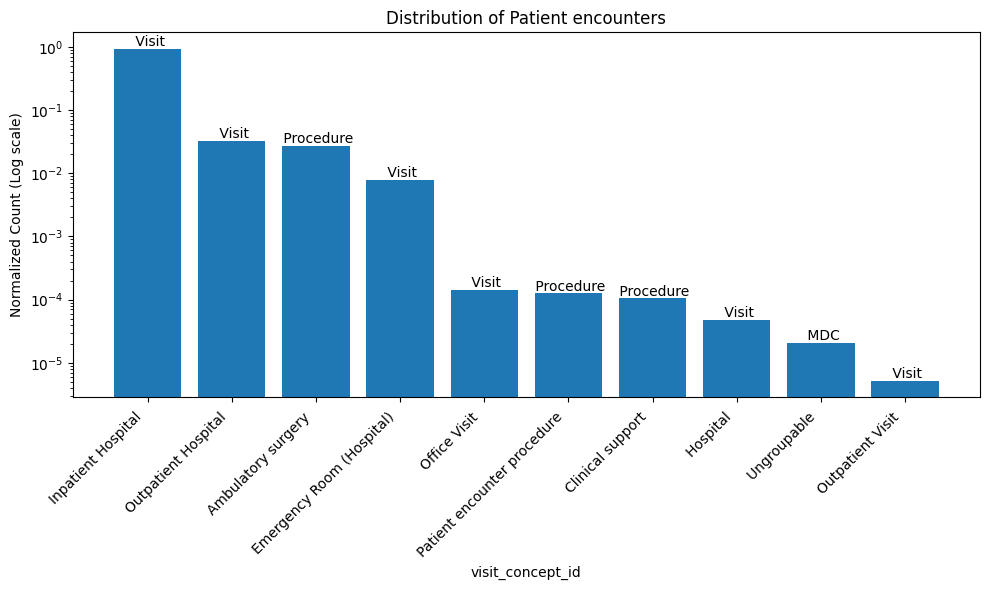

In [206]:
unique_visits = visit_occurrence['visit_concept_id'].unique()
label = {
    8717: 'Inpatient Hospital - Visit',
    8756: 'Outpatient Hospital - Visit',
    4004517: 'Ambulatory surgery - Procedure',
    8870: 'Emergency Room (Hospital) - Visit',
    581477: 'Office Visit - Visit',
    4203722: 'Patient encounter procedure - Procedure',
    44791812: 'Clinical support - Procedure',
    38004515: 'Hospital - Visit',
    0: 'Ungroupable - MDC',
    9202: 'Outpatient Visit - Visit'
}
visit_label = [word.split('-')[0] for word in list(label.values())] 
visit_type = [word.split('-')[1] for word in list(label.values())] 
value_counts = visit_occurrence['visit_concept_id'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
bars = plt.bar(visit_label, value_counts)

# Adding labels and title
plt.xlabel('visit_concept_id')
plt.ylabel('Normalized Count (Log scale)')
plt.title('Distribution of Patient encounters')
plt.yscale('log')

for bar, v_type in zip(bars, visit_type):
    x_pos = bar.get_x() + bar.get_width() / 2 # Adjusted x-coordinate
    y_pos = bar.get_height() / 0.9
    plt.text(x_pos, y_pos, v_type, ha='center')

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [207]:
visit_occurrence.groupby('person_id')['visit_start_datetime'].nunique().describe()

count    286.000000
mean      16.895105
std       67.609219
min        1.000000
25%        3.000000
50%        8.000000
75%       13.000000
max      837.000000
Name: visit_start_datetime, dtype: float64

In [208]:
visit_occurrence.loc[visit_occurrence['person_id'] == 175605, ['visit_start_datetime', 'visit_occurrence_id']].head(15)

visit_start_datetime  visit_occurrence_id
190977  2016-02-03 10:23:00             27807625
190978  2016-02-03 10:23:00             27807625
190979  2016-02-03 10:23:00             27807625
190980  2016-05-12 11:00:00             27800762
190981  2016-11-10 09:04:00             27807626
190982  2016-11-10 09:04:00             27807626
190983  2016-11-10 09:04:00             27807626
190984  2016-11-10 09:04:00             27807626
190985  2016-11-10 09:04:00             27807626
190986  2016-11-10 09:04:00             27807626
190987  2016-11-10 09:04:00             27807626
190988  2016-11-10 09:04:00             27807626
190989  2016-11-10 09:04:00             27807626
190990  2016-11-10 09:04:00             27807626
190991  2016-11-10 09:04:00             27807626

In [209]:
led_df = led_df.sort_values(by=['drug_exposure_start_datetime'], ascending=True)

In [210]:
led_df

person_id drug_exposure_start_datetime  \
30554     175414          2011-05-13 17:00:00   
30542     175414          2011-05-13 18:00:00   
30558     175414          2011-05-13 21:00:00   
30543     175414          2011-05-13 21:00:00   
30544     175414          2011-05-13 22:00:00   
...          ...                          ...   
71531      21186          2021-05-07 13:51:00   
71532      21186          2021-05-07 20:51:00   
71547      21186          2021-05-08 09:00:00   
71533      21186          2021-05-08 13:11:00   
71534      21186          2021-05-08 22:51:00   

                                       drug_source_value  \
30554  {"med_display_name": "rasagiline mesylate (AZI...   
30542  {"med_display_name": "Inv levodopa-carbidopa o...   
30558  {"med_display_name": "ropinirole (REQUIP XL) T...   
30543  {"med_display_name": "Inv levodopa-carbidopa o...   
30544  {"med_display_name": "Inv levodopa-carbidopa o...   
...                                                  ...   
71531  {"med_display_name": "benztropine (COGENTIN) t...   
71532  {"med_display_name": "benztropine (COGENTIN) t...   
71547  {"med_display_name": "benztropine (COGENTIN) t...   
71533  {"med_display_name": "benztropine (COGENTIN) t...   
71534  {"med_display_name": "benztropine (COGENTIN) t...   

                                             drug_info        generic_name  \
30554        rasagiline mesylate (AZILECT) tablet 1 mg          rasagiline   
30542  Inv levodopa-carbidopa or placebo 100/25mg cap   carbidopa-levodopa   
30558                 ropinirole (REQUIP XL) TB24 4 mg          ropinirole   
30543  Inv levodopa-carbidopa or placebo 100/25mg cap   carbidopa-levodopa   
30544  Inv levodopa-carbidopa or placebo 100/25mg cap   carbidopa-levodopa   
...                                                ...                 ...   
71531               benztropine (COGENTIN) tablet 1 mg         benztropine   
71532               benztropine (COGENTIN) tablet 1 mg         benztropine   
71547               benztropine (COGENTIN) tablet 1 mg         benztropine   
71533               benztropine (COGENTIN) tablet 1 mg         benztropine   
71534               benztropine (COGENTIN) tablet 1 mg         benztropine   

      brand_name     dosage  led_dose  dose_source_value  \
30554    azilect       1 mg       1.0                1.0   
30542    sinemet  25-100 mg     100.0                2.0   
30558  requip xl       4 mg       4.0                4.0   
30543    sinemet  25-100 mg     100.0                2.0   
30544    sinemet  25-100 mg     100.0                1.0   
...          ...        ...       ...                ...   
71531   cogentin       1 mg       1.0                1.0   
71532   cogentin       1 mg       1.0                1.0   
71547   cogentin       1 mg       1.0                0.0   
71533   cogentin       1 mg       1.0                1.0   
71534   cogentin       1 mg       1.0                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
30554                     mg               ORAL             27770310   
30542                capsule               ORAL             27770310   
30558                     mg               ORAL             27770310   
30543                capsule               ORAL             27770310   
30544                capsule               ORAL             27770310   
...                      ...                ...                  ...   
71531                     mg         PER G TUBE              3542177   
71532                     mg         PER G TUBE              3542177   
71547                     mg         PER G TUBE              3542177   
71533                     mg         PER G TUBE              3542177   
71534                     mg         PER G TUBE              3542177   

       visit_detail_id    led  
30554              NaN  100.0  
30542              NaN  200.0  
30558              NaN    2.0  
30543              NaN  200.0  
30544         

### Finding Home Medications

In [211]:
from collections import Counter

count_comma = 0
count_asterisc = 0
comma_delimiter = False
target_word = 'Home Medications'
# Add pattern to avoid numbers. Maybe also limit words to 1-3 chars
pattern = r'([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)'
dosage = r'\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml|%))(?:/hr)?'
home_meds_pattern = r"Home Medications:? ([\w\s\d\(\)]+)"

generic_names= []
brand_names = []
target = []
home_meds_note = []
home_meds_portion = []
medications_appearance = ""
bleh = []
after_home_meds = []
rest_note = []
temp = corpus_clean # list(set(corpus_clean))
count = 0

# Goes over corpus_clean (which contains the notes for each patient) and uses a regex to find "Home Medications(:)"
# After that it restricts the note to Home Medications and everything after that

raro = {}
medications_data = []

for index, row in df_pd.iterrows():
    person_id, note_text = row['person_id'], corpus_clean[index]
    raro[index] = {
        'person_id': person_id,
        'note_text': note_text
    }


for index, item in enumerate(temp): # Make sure to sure the whole array next
    match = re.search(home_meds_pattern, item)
    if  match:
        # Little count to see how many notes contain home meds
        count = count + 1
        # Actual index where the word is inside of the string
        word_index = item.find(target_word) 
        # Truncated_note
        home_meds_note.append(item[word_index:])
        # What it actually matches
        home_meds_portion.append(match.group(0))
        # Array contianing the indexes of the notes that contain home meds
        bleh.append(index)

# Replaces the matched portion of home meds for a "". In other words, deletes the matched portion from the array
result = [note.replace(portion, "") for note, portion in zip(home_meds_note, home_meds_portion)]      
# Splits the notes by whitespaces. Note the list comprehension: words is a list of lists that contains words that have been separated by a whitespace
words = [word.split(' ') for word in result]

# Go through the ists of lists and look for the word "Medication". 
# When found concatenate th 2 words prior to the word, the word and the 2 words before the word  
for i, item in enumerate(words):
    for j, word in enumerate(item):
        if "Medications" in word:
            # Avoid getting the word at the end of the array
            if j-2 == -1:
                medications_appearance = " ".join([words[i][j-1], words[i][j], words[i][j+1], words[i][j+2]])
            else:
                medications_appearance = " ".join([words[i][j-2], words[i][j-1], words[i][j], words[i][j+1], words[i][j+2]])
            
            target.append(medications_appearance)
            # if not medications_appearance.startswith("caused by Medications"):
            #     target.append(medications_appearance)
        
        # Get the current word and two more, if it matches any of the 2 key words, attach them to the target array
        # target is a list that contains potential words that are going to be the stopwords.
        multi_word_phrase = " ".join(item[j:j+3])  # Adjust the slice range as needed
        multi_word_phrase_other = " ".join(item[j:j+2])
        if 'Allergies Allergen Reactions' in multi_word_phrase:
            target.append(multi_word_phrase)
        
        if 'Family History' in multi_word_phrase_other:
            target.append(multi_word_phrase_other)

# Here we count how many times a potential stopword is in the array and we sort them by importance
element_counts = Counter(target)
sorted_target = sorted(target, key=lambda x: (-element_counts[x], x))
target_unique = []
seen = set()

for element in sorted_target:
    if element not in seen:
        target_unique.append(element)
        seen.add(element)

whats = []
ble = []
# We iterate from the truncated note up until potential target and count the number of commas and asteriscs so that it can be the delimiter.
# Whatever is higher (commas or astheriscs) is gonna be used to split the string and get the meds
for item in result:
    for stop_word in target_unique:
        if stop_word in item:
            word_index = item.find(stop_word)
            epa = item[:word_index]
            count_comma = epa.count(',')
            count_asterisc = epa.count('*')
            whats.append(epa)
            break
        comma_delimiter = False    
        if count_comma > count_asterisc:
            comma_delimiter = True
        ble.append(comma_delimiter)

# We use the delimiter to separate the string and then ue another regex to find the generic and brand name of the drug    
for index, item in enumerate(whats):
    delimiter = ',' if ble[index] else '*'
    potential_drugs = item.split(delimiter)
    for indo, string in enumerate(potential_drugs):
        drug_name_match = re.findall(pattern, string)
        if drug_name_match:
            # I have to use temp variables beecause tuples are not mutable in Python
            for match in drug_name_match:
                # Removing the words Authorizing Provider and Historical
                if "Authorizing Provider" in match[0]:
                    temp_match = match[0].replace("Authorizing Provider", "")
                elif "Historical" in match[0]:
                    temp_match = match[0].replace("Historical", "")
                else:
                    temp_match = match[0]
                # Making the drug names lowercase and removing whitespaces
                updated_match = (temp_match.lower().strip(), match[1].lower().strip())
                generic_name, brand_name = updated_match
                generic_names.append(generic_name)
                if brand_name:
                    brand_names.append(brand_name)
                else:
                    brand_names.append(np.nan)

                person_id = raro[bleh[index]]['person_id']
                medications_data.append({
                    'person_id': person_id,
                    'index': bleh[index],
                    'generic_name': generic_name,
                    'brand_name': brand_name
                })        

medications_df = pd.DataFrame(medications_data)

In [212]:
medications_df

person_id  index             generic_name     brand_name
0         261006      0             aripiprazole        abilify
1         261006      0                 baclofen       lioresal
2         261006      0            bupropion hcl  wellbutrin xl
3         261006      0   carboxymethylcellulose        refresh
4         261006      0               clobetasol       temovate
...          ...    ...                      ...            ...
69977     205269  10080  pa-c   insulin glargine         lantus
69978     205269  10080               omeprazole       prilosec
69979     205269  10080       potassium chloride          k-dur
69980     205269  10080               ranolazine         ranexa
69981     205269  10080                terazosin         hytrin

[69982 rows x 4 columns]

In [213]:
# Create a boolean mask by applying str.contains() to each element in pd_medications
mask = medications_df['generic_name'].apply(lambda x: any(med in x for med in pd_medication))
# Use the mask to filter medications_df
filtered_df = medications_df[mask]

In [214]:
filtered_df['generic_name'].unique()

array(['benztropine', 'amantadine', 'carbidopa-levodopa', 'ropinirole',
       'pa-c   carbidopa-levodopa', 'np   carbidopa-levodopa',
       'ap   carbidopa-levodopa', 'pramipexole', 'selegiline',
       's medications  new prescriptions   no medications on file  previous medications   carbidopa-levodopa',
       'do   benztropine', 'pramipexole dihydrochloride',
       'carbidopa-levodopa-entacapone', 'rasagiline mesylate',
       'pa-c   pramipexole',
       's medications   new prescriptions    no medications on file   previous medications  amantadine',
       '25-100 mg per tablet    take 2 tablets by mouth every 2 hours    rotigotine',
       'ap   amantadine', 'do   trihexyphenidyl', 'entacapone',
       '112 mcg tablet    take 1 tablet by mouth every moing on an empty stomach    pramipexole',
       '40 mg tablet    take 1 tablet by mouth every day   pramipexole',
       's medications   new prescriptions    no medications on file   previous medications    carbidopa-levodopa',


In [215]:
# Replacing manually the instances where the drugs still contain an string before the name
filtered_df.loc[:, 'generic_name'] = filtered_df['generic_name'].replace({
    'do carbidopa-levodopa': 'carbidopa-levodopa',
    'pa-c carbidopa-levodopa': 'carbidopa-levodopa',
    'pa-c   carbidopa-levodopa': 'carbidopa-levodopa',
    'np carbidopa-levodopa': 'carbidopa-levodopa',
    'np   carbidopa-levodopa': 'carbidopa-levodopa',
    'ap carbidopa-levodopa': 'carbidopa-levodopa',
    'ap   carbidopa-levodopa': 'carbidopa-levodopa',
    '2  carbidopa-levodopa': 'carbidopa-levodopa',
    '2 tabs 3 times daily  carbidopa-levodopa': 'carbidopa-levodopa',
    '1  calcium 500 mg tablet chewable  carbidopa-levodopa': 'carbidopa-levodopa',
    'gastroparesis  carbidopa-levodopa': 'carbidopa-levodopa',
    'yes  information carbidopa-levodopa': 'carbidopa-levodopa',
    'pa-c benztropine': 'benztropine',
    'ap ropinirole': 'ropinirole',
    'ap   ropinirole': 'ropinirole',
    'do ropinirole': 'ropinirole',
    'pa-c ropinirole': 'ropinirole',
    'pa-c   ropinirole': 'ropinirole',
    's disease with unknown cause  ropinirole': 'ropinirole',
    'ureteral stone  ropinirole': 'ropinirole',
    'soda coffee or tea daily for bowel movement and then once a week as needed  selegiline': 'selegiline',
    '-levodopa': 'levodopa',
    'ap entacapone': 'entacapone',
    'pa-c selegiline': 'selegiline',
    's medications  new prescriptions   no medications on file  previous medications   carbidopa-levodopa': 'carbidopa-levodopa',
    'do   benztropine': 'benztropine',
    'pramipexole dihydrochloride': 'pramipexole',
    'rasagiline mesylate': 'rasagiline',
    'pa-c   pramipexole': 'pramipexole',
    's medications   new prescriptions    no medications on file   previous medications  amantadine': 'amantadine',
    '25-100 mg per tablet    take 2 tablets by mouth every 2 hours    rotigotine': 'rotigotine',
     'ap   amantadine': 'amantadine',
     'do   trihexyphenidyl': 'trihexyphenidyl',
     '112 mcg tablet    take 1 tablet by mouth every moing on an empty stomach    pramipexole': 'pramipexole',
      '40 mg tablet    take 1 tablet by mouth every day   pramipexole': 'pramipexole',
      's medications   new prescriptions    no medications on file   previous medications    carbidopa-levodopa': 'carbidopa-levodopa',
      'ropinirole hcl': 'ropinirole',
      'ap   entacapone': 'entacapone',
      '150 mg oral tablet extended release 24 hour     carbidopa-levodopa': 'carbidopa-levodopa',
       '25-100 mg oral tablet extended release     carbidopa-levodopa': 'carbidopa-levodopa',
       '50-200 mg oral tablet extended release     carbidopa-levodopa': 'carbidopa-levodopa',
       'np   selegiline': 'selegiline',
       'do   carbidopa-levodopa': 'carbidopa-levodopa',
       'do   pramipexole': 'pramipexole',
       's disease with unknown cause   rasagiline mesylate': 'rasagiline',
       'pa-c   carbidopa-levodopa er': 'carbidopa-levodopa er',
       'levodopa': 'carbisopa-levodopa',
       'but not at night     carbidopa-levodopa': 'carbidopa-levodopa',
       'phd   carbidopa-levodopa': 'carbidopa-levodopa',
      })


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [216]:
filtered_df[filtered_df['generic_name'] == 'carbidopa']

person_id  index generic_name brand_name
15263     256708   2263    carbidopa    lodosyn
15282     256708   2264    carbidopa    lodosyn
19152     256680   2874    carbidopa    lodosyn
19160     256680   2876    carbidopa    lodosyn
30345     249161   4723    carbidopa    lodosyn
30370     249161   4725    carbidopa    lodosyn
30390     249161   4729    carbidopa    lodosyn
30410     249161   4730    carbidopa    lodosyn
30435     249161   4737    carbidopa    lodosyn
30455     249161   4741    carbidopa    lodosyn
37540     245457   5512    carbidopa    lodosyn
37559     245457   5514    carbidopa    lodosyn
37578     245457   5515    carbidopa    lodosyn
37597     245457   5516    carbidopa    lodosyn
63813     213780   9308    carbidopa    lodosyn
63829     213780   9309    carbidopa    lodosyn
63845     213780   9310    carbidopa    lodosyn
63861     213780   9311    carbidopa    lodosyn
63877     213780   9312    carbidopa    lodosyn
63893     213780   9313    carbidopa    lodosyn
63909     213780   9315    carbidopa    lodosyn
63925     213780   9316    carbidopa    lodosyn
63941     213780   9317    carbidopa    lodosyn
63957     213780   9318    carbidopa    lodosyn

In [217]:
# result_df contains the home medications for each patient
result_df = filtered_df.groupby('person_id').agg({
    'generic_name': lambda x: ', '.join(sorted(x.unique())),
    'brand_name': lambda x: ', '.join(sorted(x.unique())),
    'index': lambda x: ', '.join(map(str, x.unique()))
}).reset_index()
result_df = result_df.sort_values(by='person_id', ascending=False)

In [218]:
result_df

person_id                                       generic_name  \
178     261006        amantadine, benztropine, carbidopa-levodopa   
177     260996  amantadine, benztropine, carbidopa-levodopa, r...   
176     260953                     carbidopa-levodopa, ropinirole   
175     260918                     carbidopa-levodopa, ropinirole   
174     260872                     carbidopa-levodopa, ropinirole   
..         ...                                                ...   
4       207746                                 carbidopa-levodopa   
3       206828  carbidopa-levodopa, entacapone, pramipexole, r...   
2       206303                                 carbidopa-levodopa   
1       206133                                 carbidopa-levodopa   
0       205269                                 carbidopa-levodopa   

                                           brand_name  \
178          cogentin, sinemet, sinemet cr, symmetrel   
177  cogentin, requip, sinemet, sinemet cr, symmetrel   
176                       requip, sinemet, sinemet cr   
175                       requip, sinemet, sinemet cr   
174                       requip, sinemet, sinemet cr   
..                                                ...   
4                                 sinemet, sinemet cr   
3           comtan, mirapex, neupro, parcopa, sinemet   
2                                             sinemet   
1                                             sinemet   
0                                             sinemet   

                                                 index  
178             14, 16, 18, 19, 20, 21, 22, 23, 25, 26  
177  29, 30, 31, 32, 34, 35, 36, 41, 42, 44, 46, 47...  
176                       176, 177, 178, 180, 182, 183  
175                  185, 186, 187, 188, 189, 191, 192  
174                            194, 195, 200, 203, 204  
..                                                 ...  
4    9800, 9801, 9802, 9804, 9805, 9806, 9807, 9808...  
3    9857, 9862, 9864, 9866, 9869, 9872, 9873, 9876...  
2    9998, 9999, 10001, 10004, 10005, 10006, 10007,...  
1    10012, 10013, 10016, 10019, 10020, 10022, 1002...  
0                                         10032, 10034  

[179 rows x 4 columns]

In [219]:
led_df['brand_name'].replace({np.nan: 'None'}, inplace=True)

In [220]:
led_df['brand_name'].unique()

array(['azilect', 'sinemet', 'requip xl', 'duopa', 'comtan', 'artane',
       'mirapex', 'symmetrel', 'requip', 'stalevo', 'eldepryl',
       'cogentin', 'mirapex er', 'parcopa', 'neupro', 'nourianz',
       'dostinex', 'apokyn', 'rytary', 'tasmar', 'None', 'azalect',
       'parlodel', 'gocovri', 'xadago', 'ipx203', 'oxmolex er'],
      dtype=object)

In [221]:
# resultado contains the generic_name and brand_name for inpatient drugs
resultado = led_df.groupby('person_id').agg({
    'generic_name': lambda x: ', '.join(sorted(x.unique())),
    'brand_name': lambda x: ', '.join(sorted(x.unique())),
}).reset_index()
resultado = resultado.sort_values(by='person_id', ascending=False)
resultado_df = resultado[resultado['person_id'].isin(filtered_df['person_id'].unique())]
resultado_df

person_id                                       generic_name  \
1423     261006                                 carbidopa-levodopa   
1422     260996        amantadine, benztropine, carbidopa-levodopa   
1420     260953  amantadine, carbidopa-levodopa, entacapone, ra...   
1418     260918                                 carbidopa-levodopa   
1417     260872                    carbidopa-levodopa, pramipexole   
...         ...                                                ...   
1070     207746                                 carbidopa-levodopa   
1069     206828                                        benztropine   
1068     206303                     carbidopa-levodopa, ropinirole   
1067     206133                                 carbidopa-levodopa   
1066     205269                                 carbidopa-levodopa   

                               brand_name  
1423                              sinemet  
1422         cogentin, sinemet, symmetrel  
1420  azilect, comtan, sinemet, symmetrel  
1418                              sinemet  
1417                     mirapex, sinemet  
...                                   ...  
1070                              sinemet  
1069                             cogentin  
1068                      requip, sinemet  
1067                              sinemet  
1066                              sinemet  

[179 rows x 3 columns]

In [222]:
comparison_generic_name = pd.merge(result_df[['person_id', 'generic_name']], resultado_df[['person_id', 'generic_name']], on='person_id', how='outer', suffixes=('_filtered', '_led'))
comparison_brand_name = pd.merge(result_df[['person_id', 'brand_name']], resultado_df[['person_id', 'brand_name']], on='person_id', how='outer', suffixes=('_filtered', '_led'))

In [223]:
comparison_generic_name

person_id                              generic_name_filtered  \
0       261006        amantadine, benztropine, carbidopa-levodopa   
1       260996  amantadine, benztropine, carbidopa-levodopa, r...   
2       260953                     carbidopa-levodopa, ropinirole   
3       260918                     carbidopa-levodopa, ropinirole   
4       260872                     carbidopa-levodopa, ropinirole   
..         ...                                                ...   
174     207746                                 carbidopa-levodopa   
175     206828  carbidopa-levodopa, entacapone, pramipexole, r...   
176     206303                                 carbidopa-levodopa   
177     206133                                 carbidopa-levodopa   
178     205269                                 carbidopa-levodopa   

                                      generic_name_led  
0                                   carbidopa-levodopa  
1          amantadine, benztropine, carbidopa-levodopa  
2    amantadine, carbidopa-levodopa, entacapone, ra...  
3                                   carbidopa-levodopa  
4                      carbidopa-levodopa, pramipexole  
..                                                 ...  
174                                 carbidopa-levodopa  
175                                        benztropine  
176                     carbidopa-levodopa, ropinirole  
177                                 carbidopa-levodopa  
178                                 carbidopa-levodopa  

[179 rows x 3 columns]

In [224]:
comparison_brand_name

person_id                               brand_name_filtered  \
0       261006          cogentin, sinemet, sinemet cr, symmetrel   
1       260996  cogentin, requip, sinemet, sinemet cr, symmetrel   
2       260953                       requip, sinemet, sinemet cr   
3       260918                       requip, sinemet, sinemet cr   
4       260872                       requip, sinemet, sinemet cr   
..         ...                                               ...   
174     207746                               sinemet, sinemet cr   
175     206828         comtan, mirapex, neupro, parcopa, sinemet   
176     206303                                           sinemet   
177     206133                                           sinemet   
178     205269                                           sinemet   

                          brand_name_led  
0                                sinemet  
1           cogentin, sinemet, symmetrel  
2    azilect, comtan, sinemet, symmetrel  
3                                sinemet  
4                       mirapex, sinemet  
..                                   ...  
174                              sinemet  
175                             cogentin  
176                      requip, sinemet  
177                              sinemet  
178                              sinemet  

[179 rows x 3 columns]

In [225]:
# Split the medication lists into sets for comparison
comparison_generic_name['filtered_set'] = comparison_generic_name['generic_name_filtered'].apply(lambda x: set(x.split(', ')))
comparison_generic_name['led_set'] = comparison_generic_name['generic_name_led'].apply(lambda x: set(x.split(', ')))
comparison_generic_name['union'] = comparison_generic_name.apply(lambda row: row['filtered_set'].union(row['led_set']), axis=1)
comparison_generic_name['intersection'] = comparison_generic_name.apply(lambda row: row['filtered_set'].intersection(row['led_set']), axis=1)
comparison_generic_name['match'] = comparison_generic_name.apply(lambda row: round(len(row['intersection']) / len(row['union']) * 100, 0), axis=1)
comparison_generic_name['difference'] = comparison_generic_name.apply(lambda row: row['union'].difference(row['intersection']), axis=1)

In [226]:
comparison_generic_name['match'].describe()

count    179.000000
mean      51.703911
std       34.949667
min        0.000000
25%       25.000000
50%       50.000000
75%      100.000000
max      100.000000
Name: match, dtype: float64

In [227]:
comparison_generic_name['match'].value_counts(normalize=True)

100.0    0.290503
50.0     0.251397
33.0     0.156425
0.0      0.122905
25.0     0.078212
20.0     0.033520
67.0     0.016760
29.0     0.011173
14.0     0.011173
75.0     0.005587
12.0     0.005587
17.0     0.005587
11.0     0.005587
9.0      0.005587
Name: match, dtype: float64

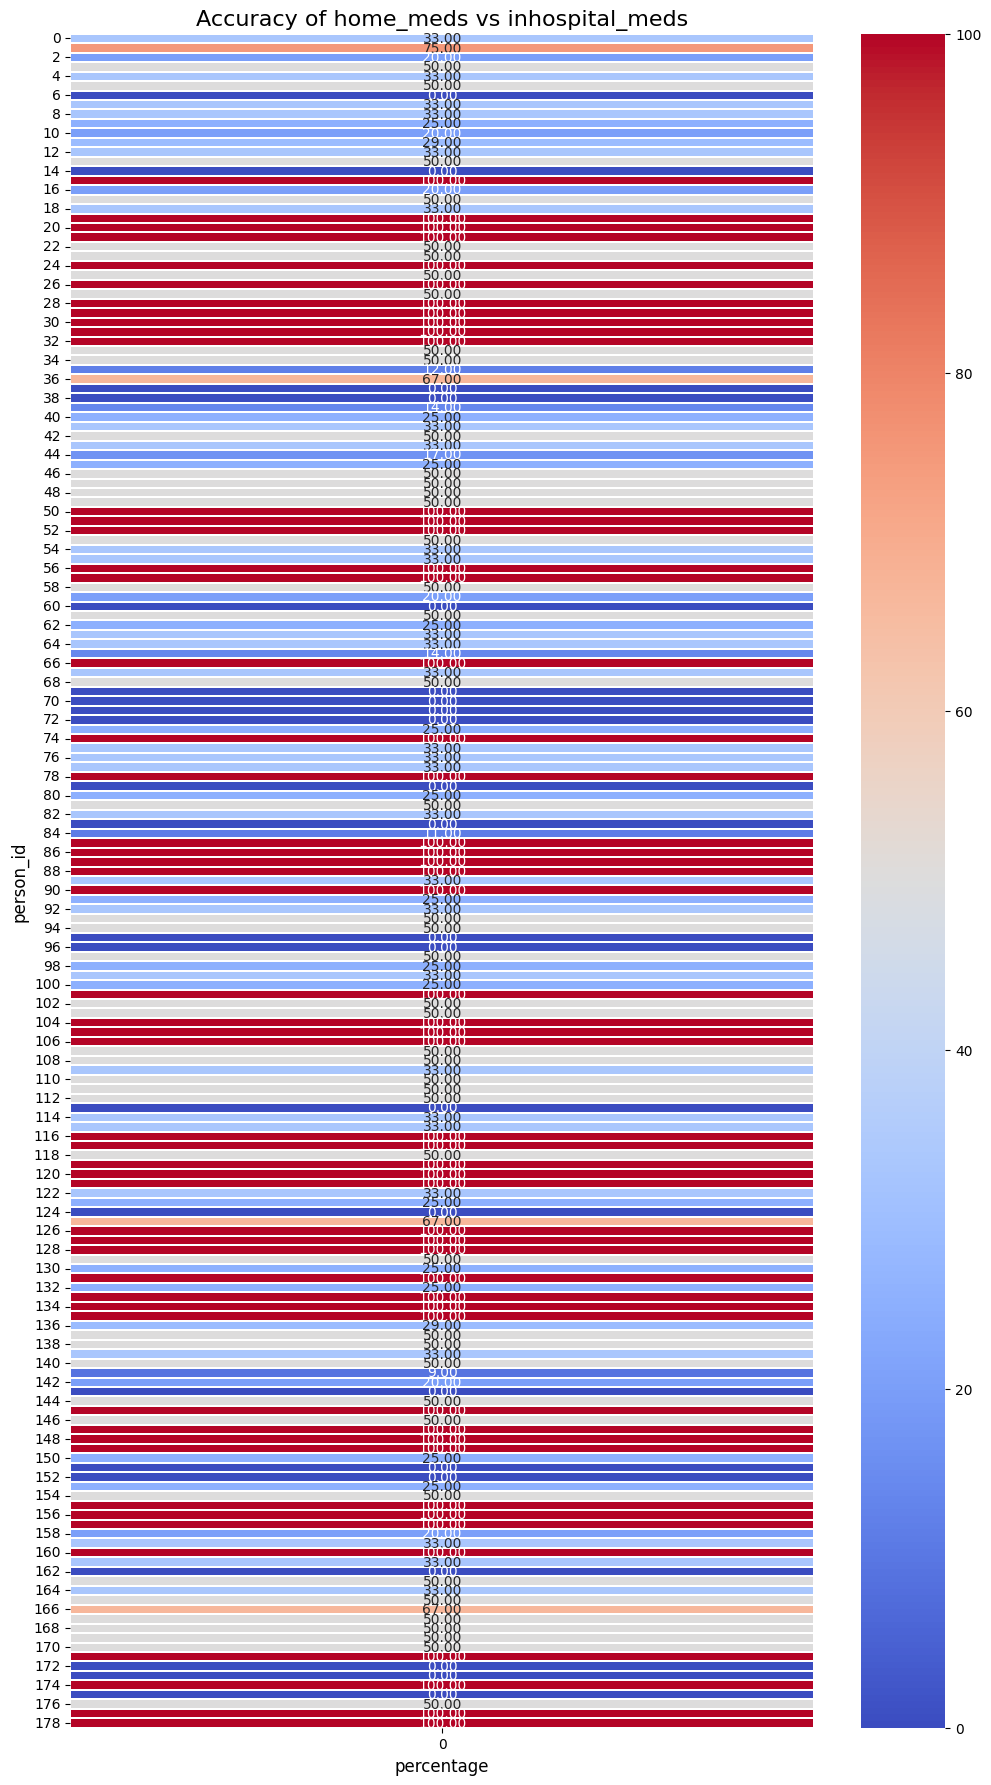

In [228]:
# Transform the matching percentages into a NumPy array
heatmap_data = comparison_generic_name['match'].values.reshape(-1, 1)

# Set the figure size
plt.figure(figsize=(12, 22))

# Create a heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.2)

# Customize the plot
plt.title('Accuracy of home_meds vs inhospital_meds', fontsize=16)
plt.xlabel('percentage', fontsize=12)
plt.ylabel('person_id', fontsize=12)

# Show the plot
plt.show()

In [229]:
comparison_generic_name.describe()

person_id       match
count     179.000000  179.000000
mean   238744.720670   51.703911
std     17606.106388   34.949667
min    205269.000000    0.000000
25%    221553.000000   25.000000
50%    241867.000000   50.000000
75%    255186.500000  100.000000
max    261006.000000  100.000000

Allergies Allergen Reactions, Physical Exam, Family History, Allergies Allergen Reactions

In [230]:
# corpus_clean

In [231]:
# set(corpus_clean)

In [232]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

In [233]:
# This person probably had restless leg syndrome or Parkinsonism
led_df.loc[led_df['person_id'] == 258899, ['drug_exposure_start_datetime', 'generic_name']]

drug_exposure_start_datetime        generic_name
1840          2011-12-05 06:25:00         pramipexole
1841          2012-02-06 22:15:00         pramipexole
1842          2012-02-09 11:00:00         pramipexole
1843          2012-02-09 14:46:00         pramipexole
1844          2012-02-09 20:58:00         pramipexole
...                           ...                 ...
1916          2014-02-07 05:52:00         pramipexole
1836          2017-01-07 13:26:00  carbidopa-levodopa
1837          2017-01-07 17:17:00  carbidopa-levodopa
1838          2017-01-07 23:41:00  carbidopa-levodopa
1839          2017-01-08 08:00:00  carbidopa-levodopa

[81 rows x 2 columns]

In [234]:
led_df.groupby('person_id')['visit_occurrence_id'].nunique().sort_values(ascending=False)

person_id
52721     25
249161    25
256936    24
84870     23
76382     22
          ..
117306     1
117326     1
117372     1
117791     1
261006     1
Name: visit_occurrence_id, Length: 1424, dtype: int64

In [235]:
visit_occurrence[visit_occurrence['person_id'] == 261006]['visit_occurrence_id'].unique()

array([40382465, 40422617, 40422624, 40384038, 40422625, 40422626,
       40422627, 40382459, 40422628, 40382460, 40382461, 40422629,
       40384085, 40382213, 40382462, 40382466, 40422630, 40422631,
       40422618, 40382464, 40422620, 40382312, 40382316, 40382320,
       40382325, 40422621, 40422622, 40382467, 40422623])

In [236]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

In [237]:
# So this is critical step in the model. When I drop the duplicates the accuracy drops. But I feel like it's a neccesary step
# The reason why it's dropped is because we are only interested in the visits. led_df already has accurate info on the drugs
visit_occurrence_modified = visit_occurrence.drop(columns=['drug_exposure_start_datetime'])
visit_occurrence_modified.drop_duplicates(inplace=True)

In [238]:
led_df = led_df.merge(visit_occurrence_modified, on=['person_id', 'visit_occurrence_id'], how='inner')

In [239]:
led_df["visit_start_datetime"] = pd.to_datetime(led_df["visit_start_datetime"], format='%Y-%m-%d')
led_df["drug_exposure_start_datetime"] = pd.to_datetime(led_df["drug_exposure_start_datetime"], format='%Y-%m-%d')

In [240]:
led_df["visit_start_datetime"].describe() 

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                   26946
unique                    849
top       2018-01-30 18:34:00
freq                      725
first     2011-05-18 05:41:00
last      2021-04-29 11:02:00
Name: visit_start_datetime, dtype: object

In [241]:
years = 4
days_to_years = years * 360
time_window = str(days_to_years) + 'D'
# It looks like rolling only allows to use the most basic unit of each time variable (days, seconds)
mean_led_per_visit = led_df.set_index('visit_start_datetime').groupby('person_id')['led'].resample(time_window).mean().reset_index() # Using the time window
# mean_led_per_visit = led_df.set_index('visit_start_datetime').groupby('person_id')['led'].mean().reset_index() # Without time window
mean_led_per_visit = mean_led_per_visit.rename(columns={'led':'mean_led_per_visit'})
patient_stay['mean_led_per_visit'] = mean_led_per_visit['mean_led_per_visit']

array_temp = mean_led_per_visit['mean_led_per_visit'].to_list()
prediction = [0] * len(array_temp)  # Initialize with 0 for all elements
prediction[1:] = [1 if array_temp[i+1] > array_temp[i] else 0 for i in range(len(array_temp)-1)]
# prediction = [1 if array_temp[i + 1] > array_temp[i] else (2 if array_temp[i + 1] == array_temp[i] else 0) for i in range(len(array_temp) - 1)]
mean_led_per_visit['prediction'] = prediction

In [242]:
mean_led_per_visit['prediction'].value_counts(normalize=True)

0    0.559633
1    0.440367
Name: prediction, dtype: float64

In [243]:
mean_led_per_visit[mean_led_per_visit['mean_led_per_visit'].isna() == True]

person_id visit_start_datetime  mean_led_per_visit  prediction
107     213120           2015-05-25                 NaN           0
143     220761           2017-09-06                 NaN           0
145     221162           2017-11-08                 NaN           0
261     253410           2015-08-03                 NaN           0

In [244]:
mean_led_per_visit = mean_led_per_visit.merge(demographics, on='person_id', how='right')

Length of stay relative to overall visits and not only drug administration

In [245]:
length_of_stay = visit_occurrence.groupby('person_id')['visit_start_datetime'].agg(['min', 'max']).reset_index()
length_of_stay['length_of_stay'] = ((length_of_stay['max'] - length_of_stay['min']) / np.timedelta64(1, 'D')).astype(int)
length_of_stay['days_since_last_visit'] = ((pd.to_datetime('today') - length_of_stay['max']) / np.timedelta64(1, 'D')).astype(int)
length_of_stay.drop(columns=['min', 'max'], inplace=True)

In [246]:
mean_led_per_visit = mean_led_per_visit.merge(length_of_stay, on='person_id', how='right')

In [247]:
# aggregations = {'generic_name': lambda x: ', '.join(x), 'dosage': lambda x: ', '.join(x)}
aggregations = {'generic_name': lambda x: ', '.join(x)}
# CPT CODES FOR DBS, TF/IDF FOR TEXT, CLINICALBIOBET FOR NOTES, RNN LSTM FOR NOTES FOT TEMPORL INPUVT, PROCESSES THE EVENT AT A TIME AND OUTPUTS PREDICTION
# CONTEX WINDOWS FOR CLINICAL BIOBERT. HIERARCHY PASS EMBEDS INTO OTHER BERT.
# TRANSFORMERXL, LONGFORMER, TPIC MODELING
# CLUSTER ON EVERYTHING LOOK FOR DISTINCT THINGS
# PICK AVG IF EACH FEATURES ACCROSS MODELS}
result = led_df.set_index('visit_start_datetime').groupby('person_id').resample(time_window).agg(aggregations).reset_index() # Using time window
# result = led_df.set_index('visit_start_datetime').groupby('person_id').agg(aggregations).reset_index() # Without time window

In [248]:
result

person_id visit_start_datetime  \
0       175605           2017-05-28   
1       175744           2020-05-08   
2       176417           2018-11-23   
3       176462           2015-06-10   
4       176706           2021-04-28   
..         ...                  ...   
322     260872           2021-03-22   
323     260918           2019-01-01   
324     260956           2011-05-18   
325     260996           2012-10-10   
326     261006           2021-04-09   

                                          generic_name  
0    carbidopa-levodopa, carbidopa-levodopa, carbid...  
1    carbidopa-levodopa, carbidopa-levodopa, carbid...  
2    carbidopa-levodopa, carbidopa-levodopa, carbid...  
3                             pramipexole, pramipexole  
4    carbidopa-levodopa, carbidopa-levodopa, carbid...  
..                                                 ...  
322  carbidopa-levodopa, carbidopa-levodopa, carbid...  
323  carbidopa-levodopa, carbidopa-levodopa, carbid...  
324  carbidopa-levodopa, carbidopa-levodopa, carbid...  
325  amantadine, carbidopa-levodopa, amantadine, ca...  
326  carbidopa-levodopa, carbidopa-levodopa, carbid...  

[327 rows x 3 columns]

In [249]:
mean_led_per_visit.drop_duplicates()

person_id visit_start_datetime  mean_led_per_visit  prediction  age  \
0       175605           2017-05-28            78.66242         0.0   89   
1       175744           2020-05-08           100.00000         1.0   91   
2       176417           2018-11-23           100.00000         0.0   78   
3       176462           2015-06-10           100.00000         0.0   69   
4       176706           2021-04-28           200.00000         1.0   79   
..         ...                  ...                 ...         ...  ...   
322     260872           2021-03-22           100.00000         1.0   75   
323     260918           2019-01-01           100.00000         0.0   80   
324     260956           2011-05-18           140.62500         1.0   88   
325     260996           2012-10-10            94.55213         0.0   77   
326     261006           2021-04-09           200.00000         1.0   74   

    gender_source_value race_source_value ethnicity_source_value  \
0                  MALE             OTHER               HISPANIC   
1                  MALE             WHITE           NOT HISPANIC   
2                  MALE             WHITE           NOT HISPANIC   
3                  MALE             WHITE           NOT HISPANIC   
4                FEMALE             WHITE           NOT HISPANIC   
..                  ...               ...                    ...   
322                MALE             BLACK           NOT HISPANIC   
323              FEMALE             WHITE           NOT HISPANIC   
324              FEMALE             WHITE           NOT HISPANIC   
325              FEMALE             WHITE           NOT HISPANIC   
326                MALE             WHITE           NOT HISPANIC   

     length_of_stay  days_since_last_visit  
0               593                   2340  
1               550                   1376  
2               207                   1860  
3              2088                   1917  
4              1045                   1022  
..              ...                    ...  
322            3218                   1045  
323            2854                   1318  
324            3124                   1531  
325            2146                   1997  
326            3503                   1041  

[327 rows x 10 columns]

In [250]:
# Shit happens
result.iloc[132]

person_id                                                          218473
visit_start_datetime                                  2015-07-02 00:00:00
generic_name            carbidopa-levodopa, carbidopa-levodopa, carbid...
Name: 132, dtype: object

In [251]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79362  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79363  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79364  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79365  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
79361          12629.0  
79362          12629.0  
79363          12629.0  
79364          12629.0  
79365          12629.0  

[79366 rows x 8 columns]

In [252]:
result.iloc[0, :]

person_id                                                          175605
visit_start_datetime                                  2017-05-28 00:00:00
generic_name            carbidopa-levodopa, carbidopa-levodopa, carbid...
Name: 0, dtype: object

Here's where we ONLY use the generic_name instead of generic_name + dosage

In [253]:
# Taking the unique elements from the result array. What we are doing is that we are taking the unique drugs for each patient
epa = []
unique_elements = []

for i in range(len(result)):
    generic_names = result['generic_name'][i].split(', ')
    # dosages = result['dosage'][i].split(', ')
    
    visit_drugs = set()
    
    # ONLY TAKING USING GENERIC_NAME AND NOT DOSAGES
    for generic_name in generic_names:
        visit_drugs.add(f"{generic_name}")
    
    # This is how it was before
    # for generic_name, dosage in zip(generic_names, dosages):
    #     visit_drugs.add(f"{generic_name} {dosage}")

    unique_elements.append(visit_drugs)

patient_drugs_list = [', '.join(visit_drugs) for visit_drugs in unique_elements]
patient_drugs = pd.DataFrame(patient_drugs_list, columns=['drugs_per_visit'])
patient_drugs['person_id'] = result['person_id']
# mean_led_per_visit['drugs_per_visit'] = [', '.join(visit_drugs) for visit_drugs in unique_elements]

In [254]:
patient_drugs

drugs_per_visit  person_id
0                             carbidopa-levodopa     175605
1                             carbidopa-levodopa     175744
2                             carbidopa-levodopa     176417
3                                    pramipexole     176462
4                             carbidopa-levodopa     176706
..                                           ...        ...
322              carbidopa-levodopa, pramipexole     260872
323                           carbidopa-levodopa     260918
324                           carbidopa-levodopa     260956
325  carbidopa-levodopa, amantadine, benztropine     260996
326                           carbidopa-levodopa     261006

[327 rows x 2 columns]

In [255]:
# I didn't use this

# drugs_list = patient_drugs['drugs_per_visit'].str.split(', ')

# # Create a DataFrame with one-hot encoding
# one_hot_encoded = pd.get_dummies(drugs_list.apply(pd.Series).stack()).sum(level=0)

# # Concatenate the one-hot encoded DataFrame with the original DataFrame
# patient_drugs_encoded = pd.concat([patient_drugs, one_hot_encoded], axis=1)

# # Drop the original 'drugs_per_visit' column as it's no longer needed
# patient_drugs_encoded = patient_drugs_encoded.drop('drugs_per_visit', axis=1)

In [256]:
# Putting the inpatient drugs into the dataset
# mean_led_per_visit = mean_led_per_visit.merge(patient_drugs, on='person_id', how='right')

In [257]:
# Filling nan values with None
# mean_led_per_visit['drugs_per_visit'].fillna('None', inplace=True)

In [258]:
# Assesing if they were diagnosed and have poa in the current visit
# Note: These two variables do nothing for the model
mean_led_per_visit['diagnosed_current_visit'] = mean_led_per_visit.apply(lambda row: 1 if row['person_id'] in diagnosis_date[diagnosis_date['diagnosis_date'] == row['visit_start_datetime']]['person_id'].values else 0, axis=1)
mean_led_per_visit['poa_current_visit'] = mean_led_per_visit.apply(lambda row: 1 if row['person_id'] in diagnosis_date[(diagnosis_date['condition_poa'] == True) & (diagnosis_date['diagnosis_date'] == row['visit_start_datetime'])]['person_id'].values else 0, axis=1)

In [259]:
# Calculating days to diagnosis
# Note: This variable also does nothing for the model
first_visit_per_patient = visit_occurrence.groupby('person_id')['visit_start_datetime'].agg('min').reset_index()
first_visit_diagnosis_date = diagnosis_date.groupby('person_id')['diagnosis_date'].agg('min').reset_index()
days_to_diagnosis = pd.DataFrame()
days_to_diagnosis['person_id'] = first_visit_per_patient['person_id']
days_to_diagnosis['days_to_diagnosis'] = ((first_visit_diagnosis_date['diagnosis_date'] - first_visit_per_patient['visit_start_datetime']) / np.timedelta64(1, 'D')).astype(int)

In [260]:
df_pd['person_id'].nunique()

631

In [261]:
mean_led_per_visit

person_id visit_start_datetime  mean_led_per_visit  prediction  age  \
0       175605           2017-05-28            78.66242         0.0   89   
1       175744           2020-05-08           100.00000         1.0   91   
2       176417           2018-11-23           100.00000         0.0   78   
3       176462           2015-06-10           100.00000         0.0   69   
4       176706           2021-04-28           200.00000         1.0   79   
..         ...                  ...                 ...         ...  ...   
322     260872           2021-03-22           100.00000         1.0   75   
323     260918           2019-01-01           100.00000         0.0   80   
324     260956           2011-05-18           140.62500         1.0   88   
325     260996           2012-10-10            94.55213         0.0   77   
326     261006           2021-04-09           200.00000         1.0   74   

    gender_source_value race_source_value ethnicity_source_value  \
0                  MALE             OTHER               HISPANIC   
1                  MALE             WHITE           NOT HISPANIC   
2                  MALE             WHITE           NOT HISPANIC   
3                  MALE             WHITE           NOT HISPANIC   
4                FEMALE             WHITE           NOT HISPANIC   
..                  ...               ...                    ...   
322                MALE             BLACK           NOT HISPANIC   
323              FEMALE             WHITE           NOT HISPANIC   
324              FEMALE             WHITE           NOT HISPANIC   
325              FEMALE             WHITE           NOT HISPANIC   
326                MALE             WHITE           NOT HISPANIC   

     length_of_stay  days_since_last_visit  diagnosed_current_visit  \
0               593                   2340                        0   
1               550                   1376                        0   
2               207                   1860                        0   
3              2088                   1917                        0   
4              1045                   1022                        0   
..              ...                    ...                      ...   
322            3218                   1045                        0   
323            2854                   1318                        0   
324            3124                   1531                        0   
325            2146                   1997                        0   
326            3503                   1041                        0   

     poa_current_visit  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
..                 ...  
322                  0  
323                  0  
324                  0  
325                  0  
326                  0  

[327 rows x 12 columns]

In [262]:
# Including temporal data into the dataset
mean_led_per_visit = mean_led_per_visit.merge(days_to_diagnosis, on='person_id', how='right')

In [263]:
# Note: When I avoid dropping nas accuracy bumps to 91%
# mean_led_per_visit = mean_led_per_visit.dropna()

In [264]:
mean_led_per_visit['person_id'].nunique()

286

In [265]:
mean_led_per_visit

person_id visit_start_datetime  mean_led_per_visit  prediction  age  \
0       175605           2017-05-28            78.66242         0.0   89   
1       175744           2020-05-08           100.00000         1.0   91   
2       176417           2018-11-23           100.00000         0.0   78   
3       176462           2015-06-10           100.00000         0.0   69   
4       176706           2021-04-28           200.00000         1.0   79   
..         ...                  ...                 ...         ...  ...   
322     260872           2021-03-22           100.00000         1.0   75   
323     260918           2019-01-01           100.00000         0.0   80   
324     260956           2011-05-18           140.62500         1.0   88   
325     260996           2012-10-10            94.55213         0.0   77   
326     261006           2021-04-09           200.00000         1.0   74   

    gender_source_value race_source_value ethnicity_source_value  \
0                  MALE             OTHER               HISPANIC   
1                  MALE             WHITE           NOT HISPANIC   
2                  MALE             WHITE           NOT HISPANIC   
3                  MALE             WHITE           NOT HISPANIC   
4                FEMALE             WHITE           NOT HISPANIC   
..                  ...               ...                    ...   
322                MALE             BLACK           NOT HISPANIC   
323              FEMALE             WHITE           NOT HISPANIC   
324              FEMALE             WHITE           NOT HISPANIC   
325              FEMALE             WHITE           NOT HISPANIC   
326                MALE             WHITE           NOT HISPANIC   

     length_of_stay  days_since_last_visit  diagnosed_current_visit  \
0               593                   2340                        0   
1               550                   1376                        0   
2               207                   1860                        0   
3              2088                   1917                        0   
4              1045                   1022                        0   
..              ...                    ...                      ...   
322            3218                   1045                        0   
323            2854                   1318                        0   
324            3124                   1531                        0   
325            2146                   1997                        0   
326            3503                   1041                        0   

     poa_current_visit  days_to_diagnosis  
0                    0                328  
1                    0               -472  
2                    0               -383  
3                    0               1052  
4                    0               -369  
..                 ...                ...  
322                  0               1215  
323                  0               1119  
324                  0               1602  
325                  0               1105  
326                  0               2829  

[327 rows x 13 columns]

AQUI

In [266]:
# The column 'drugs_per_visit' is the one in patient_drugs. What we do here is create a one hot enconding if inpatient drugs
# drugs_list = mean_led_per_visit['drugs_per_visit'].str.split(', ')
# one_hot_encoding_drugs = pd.get_dummies(drugs_list.apply(pd.Series).stack()).sum(level=0)
# Adding the one hot encoding to the dataset and then deleting the original column
# mean_led_per_visit = pd.concat([mean_led_per_visit, one_hot_encoding_drugs], axis=1)
# mean_led_per_visit.drop(columns=['drugs_per_visit'], inplace=True)

In [267]:
patient_drugs['drugs_per_visit'].unique()

array(['carbidopa-levodopa', 'pramipexole',
       'ropinirole, carbidopa-levodopa',
       'bromocriptine, carbidopa-levodopa',
       'trihexyphenidyl, benztropine', 'rotigotine',
       'carbidopa-levodopa, amantadine, tolcapone',
       'trihexyphenidyl, carbidopa-levodopa, rasagiline', 'rasagiline',
       'ropinirole, amantadine', 'entacapone, carbidopa-levodopa',
       'ropinirole', 'benztropine', 'carbidopa-levodopa, benztropine',
       'carbidopa-levodopa, pramipexole',
       'rotigotine, carbidopa-levodopa',
       'carbidopa-levodopa-entacapone, benztropine, carbidopa-levodopa, entacapone, pramipexole',
       'trihexyphenidyl, carbidopa-levodopa',
       'ropinirole, entacapone, carbidopa-levodopa, amantadine',
       'carbidopa-levodopa, amantadine', 'carbidopa-levodopa, selegiline',
       'ropinirole, carbidopa-levodopa, amantadine, selegiline',
       'rotigotine, amantadine',
       'ropinirole, carbidopa-levodopa, amantadine',
       'ropinirole, pramipexole',
    

In [268]:
led_df['dose_unit_source_value'].replace({'Tablet': 'tablet', 'tablet': 'tablet'}, inplace=True)
# apomorphine? something with thius

Adding the home_meds information

In [269]:
result_df.drop(columns=['index', 'brand_name'], inplace=True)
result_df = result_df.rename(columns={'generic_name': 'home_meds_generic_name'})
home_meds_patients = result_df['person_id'].unique().tolist()
mean_led_per_visit['home_meds'] = mean_led_per_visit['person_id'].isin(home_meds_patients)
mean_led_per_visit['home_meds'].replace({True: 1, False: 0}, inplace=True)

In [270]:
mean_led_per_visit = mean_led_per_visit.merge(result_df, on='person_id', how='left')

In [271]:
mean_led_per_visit['home_meds_generic_name'].fillna('None', inplace=True)

In [272]:
patient_drugs

drugs_per_visit  person_id
0                             carbidopa-levodopa     175605
1                             carbidopa-levodopa     175744
2                             carbidopa-levodopa     176417
3                                    pramipexole     176462
4                             carbidopa-levodopa     176706
..                                           ...        ...
322              carbidopa-levodopa, pramipexole     260872
323                           carbidopa-levodopa     260918
324                           carbidopa-levodopa     260956
325  carbidopa-levodopa, amantadine, benztropine     260996
326                           carbidopa-levodopa     261006

[327 rows x 2 columns]

In [273]:
result_df

person_id                             home_meds_generic_name
178     261006        amantadine, benztropine, carbidopa-levodopa
177     260996  amantadine, benztropine, carbidopa-levodopa, r...
176     260953                     carbidopa-levodopa, ropinirole
175     260918                     carbidopa-levodopa, ropinirole
174     260872                     carbidopa-levodopa, ropinirole
..         ...                                                ...
4       207746                                 carbidopa-levodopa
3       206828  carbidopa-levodopa, entacapone, pramipexole, r...
2       206303                                 carbidopa-levodopa
1       206133                                 carbidopa-levodopa
0       205269                                 carbidopa-levodopa

[179 rows x 2 columns]

In [274]:
experiment_df = patient_drugs.copy()
experiment_df = experiment_df.merge(result_df, on='person_id', how='left')

In [275]:
experiment_df['drugs_per_visit'] = experiment_df['drugs_per_visit'].apply(lambda x: ', '.join(sorted(str(x).split(', '))))

In [276]:
experiment_df = experiment_df[['person_id', 'home_meds_generic_name', 'drugs_per_visit']]

In [277]:
def combine_columns(row):
    values = set()
    for col in ['home_meds_generic_name', 'drugs_per_visit']:
        if not pd.isna(row[col]):
            values.add(row[col])
    return ', '.join(sorted(values))

# Apply the custom function to create a new column
experiment_df['combined'] = experiment_df.apply(combine_columns, axis=1)

In [278]:
experiment_df = experiment_df.drop(columns=['home_meds_generic_name', 'drugs_per_visit'])
experiment_df

person_id                                           combined
0       175605                                 carbidopa-levodopa
1       175744                                 carbidopa-levodopa
2       176417                                 carbidopa-levodopa
3       176462                                        pramipexole
4       176706                                 carbidopa-levodopa
..         ...                                                ...
322     260872  carbidopa-levodopa, pramipexole, carbidopa-lev...
323     260918  carbidopa-levodopa, carbidopa-levodopa, ropini...
324     260956                                 carbidopa-levodopa
325     260996  amantadine, benztropine, carbidopa-levodopa, a...
326     261006  amantadine, benztropine, carbidopa-levodopa, c...

[327 rows x 2 columns]

In [279]:
mean_led_per_visit = mean_led_per_visit.merge(experiment_df, on='person_id', how='right')

AQUI ES DONDE HAY QUE HACER UNA SUMA BINARIA

In [280]:
drugs_list = mean_led_per_visit['combined'].str.split(', ')
one_hot_encoding_home_drugs = pd.get_dummies(drugs_list.apply(pd.Series).stack()).sum(level=0)

# This is in case I decide to only use the generic name from the mean_led_per_visit and not a combination of generic name + dosage
# duplicate_columns = mean_led_per_visit.columns[mean_led_per_visit.columns.isin(one_hot_encoding_home_drugs.columns)]
# for column in duplicate_columns:
#     mean_led_per_visit.rename(columns={column: column + '_2'}, inplace=True)
    
mean_led_per_visit = pd.concat([mean_led_per_visit, one_hot_encoding_home_drugs], axis=1, verify_integrity=True)
mean_led_per_visit.drop(columns=['home_meds_generic_name'], inplace=True)
mean_led_per_visit.drop(columns=['combined'], inplace=True)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [281]:
# one_hot_encoding_home_drugs.columns # Tiene carbidopa y levodopa por aparte

In [282]:
mean_led_per_visit.drop(columns=['person_id', 'visit_start_datetime'], inplace=True)

In [283]:
mean_led_per_visit.columns

Index(['mean_led_per_visit', 'prediction', 'age', 'gender_source_value',
       'race_source_value', 'ethnicity_source_value', 'length_of_stay',
       'days_since_last_visit', 'diagnosed_current_visit', 'poa_current_visit',
       'days_to_diagnosis', 'home_meds', '', 'amantadine', 'amantadine er',
       'apomorphine', 'benztropine', 'bromocriptine', 'cabergoline',
       'carbidopa', 'carbidopa-levodopa', 'carbidopa-levodopa er',
       'carbidopa-levodopa-entacapone', 'entacapone',
       'inv levodopa-carbidopa intestinal gel', 'levodopa', 'pramipexole',
       'pramipexole er', 'rasagiline', 'ropinirole', 'rotigotine',
       'selegiline', 'tolcapone', 'trihexyphenidyl'],
      dtype='object')

In [284]:
file_path = 'acc.txt'
file = open(file_path, 'a')

In [285]:
mean_led_per_visit.columns

Index(['mean_led_per_visit', 'prediction', 'age', 'gender_source_value',
       'race_source_value', 'ethnicity_source_value', 'length_of_stay',
       'days_since_last_visit', 'diagnosed_current_visit', 'poa_current_visit',
       'days_to_diagnosis', 'home_meds', '', 'amantadine', 'amantadine er',
       'apomorphine', 'benztropine', 'bromocriptine', 'cabergoline',
       'carbidopa', 'carbidopa-levodopa', 'carbidopa-levodopa er',
       'carbidopa-levodopa-entacapone', 'entacapone',
       'inv levodopa-carbidopa intestinal gel', 'levodopa', 'pramipexole',
       'pramipexole er', 'rasagiline', 'ropinirole', 'rotigotine',
       'selegiline', 'tolcapone', 'trihexyphenidyl'],
      dtype='object')

In [286]:
df_pd

person_id  age gender_source_value race_source_value  \
0         261006   74                MALE             WHITE   
1         261006   74                MALE             WHITE   
2         261006   74                MALE             WHITE   
3         261006   74                MALE             WHITE   
4         261006   74                MALE             WHITE   
...          ...  ...                 ...               ...   
22858      83371   73                MALE             WHITE   
22859      83371   73                MALE             WHITE   
22860      83371   73                MALE             WHITE   
22861      83371   73                MALE             WHITE   
22862      83371   73                MALE             WHITE   

      ethnicity_source_value  \
0               NOT HISPANIC   
1               NOT HISPANIC   
2               NOT HISPANIC   
3               NOT HISPANIC   
4               NOT HISPANIC   
...                      ...   
22858           NOT HISPANIC   
22859           NOT HISPANIC   
22860           NOT HISPANIC   
22861           NOT HISPANIC   
22862           NOT HISPANIC   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
22858  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22859  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22860  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22861  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22862  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
22858  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22859  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22860  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22861  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22862  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   

      brand_name     dosage  quantity  dose_source_value  \
0        sinemet  25-100 mg       2.0                2.0   
1        sinemet  25-100 mg       2.0                2.0   
2        sinemet  25-100 mg       2.0                2.0   
3        sinemet  25-100 mg       2.0                2.0   
4        sinemet  25-100 mg       2.0                2.0   
...          ...        ...       ...                ...   
22858     neupro       8 mg       1.0                1.0   
22859     neupro       8 mg       1.0                1.0   
22860     neupro       8 mg       1.0                1.0   
22861     neupro       8 mg       1.0                1.0   
22862     neupro       8 mg       1.0                1.0   

      dose_unit_source_value  \
0                     tablet   
1                     tablet   
2                     tablet   
3                     tablet   
4                     tablet   
...                      ...   
22858                  patch   
22859                  patch   
22860                  patch   
22861                  patch   
22862                  patch   

                                               note_text  
0      "department

In [287]:
mean_led_per_visit

mean_led_per_visit  prediction  age gender_source_value  \
0              78.66242         0.0   89                MALE   
1             100.00000         1.0   91                MALE   
2             100.00000         0.0   78                MALE   
3             100.00000         0.0   69                MALE   
4             200.00000         1.0   79              FEMALE   
..                  ...         ...  ...                 ...   
414           100.00000         1.0   75                MALE   
415           100.00000         0.0   80              FEMALE   
416           140.62500         1.0   88              FEMALE   
417            94.55213         0.0   77              FEMALE   
418           200.00000         1.0   74                MALE   

    race_source_value ethnicity_source_value  length_of_stay  \
0               OTHER               HISPANIC             593   
1               WHITE           NOT HISPANIC             550   
2               WHITE           NOT HISPANIC             207   
3               WHITE           NOT HISPANIC            2088   
4               WHITE           NOT HISPANIC            1045   
..                ...                    ...             ...   
414             BLACK           NOT HISPANIC            3218   
415             WHITE           NOT HISPANIC            2854   
416             WHITE           NOT HISPANIC            3124   
417             WHITE           NOT HISPANIC            2146   
418             WHITE           NOT HISPANIC            3503   

     days_since_last_visit  diagnosed_current_visit  poa_current_visit  ...  \
0                     2340                        0                  0  ...   
1                     1376                        0                  0  ...   
2                     1860                        0                  0  ...   
3                     1917                        0                  0  ...   
4                     1022                        0                  0  ...   
..                     ...                      ...                ...  ...   
414                   1045                        0                  0  ...   
415                   1318                        0                  0  ...   
416                   1531                        0                  0  ...   
417                   1997                        0                  0  ...   
418                   1041                        0                  0  ...   

     inv levodopa-carbidopa intestinal gel  levodopa  pramipexole  \
0                                        0         0            0   
1                                        0         0            0   
2                                        0         0            0   
3                                        0         0            1   
4                                        0         0            0   
..                                     ...       ...          ...   
414                                      0         0            1   
415                                      0         0            0   
416                                      0         0            0   
417                                      0         0            0   
418                                      0         0            0   

     pramipexole er  rasagiline  ropinirole  rotigotine  selegiline  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
..              ...         ...         ...         ...         ...   
414               0           0           1           0           0   
415               0           0           1           0           0   
416               0           0           0       

In [288]:
# model_embeddings = SentenceTransformer("../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT")

In [289]:
# model_embeddings

In [290]:
# embeddings = model_embeddings.encode(corpus, show_progress_bar=True)

In [291]:
# embeddings.shape

In [292]:
# TOKENIZERS_PARALLELISM = False
# optimalK = OptimalK(n_jobs=10, parallel_backend='joblib')
# num_clusters = optimalK(embeddings, n_refs=50, cluster_array=np.arange(1,30))
# print(f"The correct number of clusters is:{num_clusters}") #29 clusters

In [293]:
# reducer = umap.UMAP(metric="cosine", n_neighbors=num_clusters, n_components=2)
# umap_embedding = reducer.fit_transform(embeddings)
# umap_embedding.shape

In [294]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming umap_embedding is a 2D array with shape (22863, 2)
# # Assuming labels is an array with cluster or group labels for each sample

# # Generate example cluster labels for testing
# labels = np.random.randint(0, 9, size=(22863,))  # Replace this line with your actual cluster labels

# # Convert labels to integers if needed
# labels = labels.astype(int)

# # Define unique colors for each cluster
# colors = plt.cm.tab10(np.linspace(0, 1, 9))  # Assuming 9 clusters

# plt.figure(figsize=(10, 8))

# # Scatter plot with different colors for each cluster
# for i in range(159):
#     indices = labels == i
#     plt.scatter(umap_embedding[indices, 0], umap_embedding[indices, 1], label=f'Cluster {i + 1}', 
#                 marker='o', s=50, alpha=0.6, color=colors[i])

# plt.title('UMAP Embedding with Different Colors for Clusters')
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.legend()
# plt.show()


In [295]:
# # Prepare data
# result = pd.DataFrame(umap_embedding, columns=['x', 'y'])
# # result['labels'] = clustered.labels_

# # Visualize clusters
# fig, ax = plt.subplots(figsize=(15, 10))
# outliers = result.loc[result.labels == -1, :]
# clustered = result.loc[result.labels != -1, :]
# plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=95)
# plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=95, cmap='hsv_r')
# plt.colorbar()
# plt.axis('off')

In [296]:
mean_led_per_visit

mean_led_per_visit  prediction  age gender_source_value  \
0              78.66242         0.0   89                MALE   
1             100.00000         1.0   91                MALE   
2             100.00000         0.0   78                MALE   
3             100.00000         0.0   69                MALE   
4             200.00000         1.0   79              FEMALE   
..                  ...         ...  ...                 ...   
414           100.00000         1.0   75                MALE   
415           100.00000         0.0   80              FEMALE   
416           140.62500         1.0   88              FEMALE   
417            94.55213         0.0   77              FEMALE   
418           200.00000         1.0   74                MALE   

    race_source_value ethnicity_source_value  length_of_stay  \
0               OTHER               HISPANIC             593   
1               WHITE           NOT HISPANIC             550   
2               WHITE           NOT HISPANIC             207   
3               WHITE           NOT HISPANIC            2088   
4               WHITE           NOT HISPANIC            1045   
..                ...                    ...             ...   
414             BLACK           NOT HISPANIC            3218   
415             WHITE           NOT HISPANIC            2854   
416             WHITE           NOT HISPANIC            3124   
417             WHITE           NOT HISPANIC            2146   
418             WHITE           NOT HISPANIC            3503   

     days_since_last_visit  diagnosed_current_visit  poa_current_visit  ...  \
0                     2340                        0                  0  ...   
1                     1376                        0                  0  ...   
2                     1860                        0                  0  ...   
3                     1917                        0                  0  ...   
4                     1022                        0                  0  ...   
..                     ...                      ...                ...  ...   
414                   1045                        0                  0  ...   
415                   1318                        0                  0  ...   
416                   1531                        0                  0  ...   
417                   1997                        0                  0  ...   
418                   1041                        0                  0  ...   

     inv levodopa-carbidopa intestinal gel  levodopa  pramipexole  \
0                                        0         0            0   
1                                        0         0            0   
2                                        0         0            0   
3                                        0         0            1   
4                                        0         0            0   
..                                     ...       ...          ...   
414                                      0         0            1   
415                                      0         0            0   
416                                      0         0            0   
417                                      0         0            0   
418                                      0         0            0   

     pramipexole er  rasagiline  ropinirole  rotigotine  selegiline  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
..              ...         ...         ...         ...         ...   
414               0           0           1           0           0   
415               0           0           1           0           0   
416               0           0           0       

XGBoost Model

In [297]:
xgboost_df = mean_led_per_visit.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1]
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
# I don't need to use cupy or cudf to send the data to the GPU because I'm using DMatrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)

# Parameter previously calculated by doing hyperparameter tuning
# Note: Accuracy drops with L2 regularization and higher depth. A smaller L1 regularization bumps the model
# Note: When I avoid dropping nas in mean_led_per_patient accuracy bumps to 91%
# Note: -> Remove the least importanf features in the model and run until you find the appropiate number of features
# Model seems to perform better when I use train instead of XGBClassifier
best_params = {
    "eval_metric": "auc", # Area under the curve
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'alpha': 1, # L1 regularization
    'lambda': 10, # L2 regularization
    'learning_rate': 0.1, 
    'max_depth': 7, 
    'n_estimators': 300,
    'tree_method': 'hist', 
    'device': "cuda",
}

# Prior AUC: 0.86066216116602046
# Best new = 0.92090948515188154 difference is nwq 
new_params = {'alpha': 1, 'lambda': 10, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300} # Updated 29/01/2024

# Create and train the XGBoost model
# model = xgb.XGBClassifier(**best_params, verbosity=2, tree_method="hist", device="cuda")
# model = xgb.XGBClassifier(verbosity=2, tree_method="hist", device="cuda")
# model.fit(X_train, y_train)
model = xgb.train(best_params, d_train, num_boost_round=best_params['n_estimators'], evals=((d_test, "test"),),verbose_eval=True)

# Make predictions
y_pred = model.predict(d_test)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred] # Look what this is
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
results = model.eval(d_test)
print('AUC:', results)
print("ACC:", accuracy)
file.write(f"AUC XGBoost Model: {results} Time Window: {time_window}\n")

[0]	test-auc:0.78848
[1]	test-auc:0.79514
[2]	test-auc:0.78819
[3]	test-auc:0.79688
[4]	test-auc:0.79514
[5]	test-auc:0.80179
[6]	test-auc:0.82726
[7]	test-auc:0.83999
[8]	test-auc:0.83796
[9]	test-auc:0.85764
[10]	test-auc:0.86372
[11]	test-auc:0.85966
[12]	test-auc:0.86661
[13]	test-auc:0.86690
[14]	test-auc:0.86892
[15]	test-auc:0.86545
[16]	test-auc:0.86545
[17]	test-auc:0.86429
[18]	test-auc:0.86314
[19]	test-auc:0.86372
[20]	test-auc:0.86140
[21]	test-auc:0.86024
[22]	test-auc:0.86429
[23]	test-auc:0.86400
[24]	test-auc:0.86343
[25]	test-auc:0.86169
[26]	test-auc:0.86053
[27]	test-auc:0.86111
[28]	test-auc:0.86285
[29]	test-auc:0.86400
[30]	test-auc:0.86343
[31]	test-auc:0.86690
[32]	test-auc:0.86806
[33]	test-auc:0.86863
[34]	test-auc:0.86806
[35]	test-auc:0.86921
[36]	test-auc:0.87095
[37]	test-auc:0.87269
[38]	test-auc:0.87500
[39]	test-auc:0.87442
[40]	test-auc:0.87558
[41]	test-auc:0.87731
[42]	test-auc:0.87847
[43]	test-auc:0.87963
[44]	test-auc:0.88194
[45]	test-auc:0.8813

[20:09:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.



[64]	test-auc:0.88657
[65]	test-auc:0.88889
[66]	test-auc:0.89005
[67]	test-auc:0.88947
[68]	test-auc:0.88947
[69]	test-auc:0.88889
[70]	test-auc:0.88947
[71]	test-auc:0.88947
[72]	test-auc:0.88831
[73]	test-auc:0.89005
[74]	test-auc:0.89062
[75]	test-auc:0.89062
[76]	test-auc:0.89120
[77]	test-auc:0.89062
[78]	test-auc:0.89062
[79]	test-auc:0.89178
[80]	test-auc:0.89352
[81]	test-auc:0.89352
[82]	test-auc:0.89468
[83]	test-auc:0.89468
[84]	test-auc:0.89468
[85]	test-auc:0.89468
[86]	test-auc:0.89583
[87]	test-auc:0.89583
[88]	test-auc:0.89641
[89]	test-auc:0.89641
[90]	test-auc:0.89699
[91]	test-auc:0.89815
[92]	test-auc:0.89641
[93]	test-auc:0.89757
[94]	test-auc:0.89757
[95]	test-auc:0.89699
[96]	test-auc:0.89873
[97]	test-auc:0.89988
[98]	test-auc:0.90046
[99]	test-auc:0.90104
[100]	test-auc:0.89988
[101]	test-auc:0.89988
[102]	test-auc:0.90046
[103]	test-auc:0.90104
[104]	test-auc:0.90104
[105]	test-auc:0.90104
[106]	test-auc:0.90162
[107]	test-auc:0.90104
[108]	test-auc:0.89988
[

71

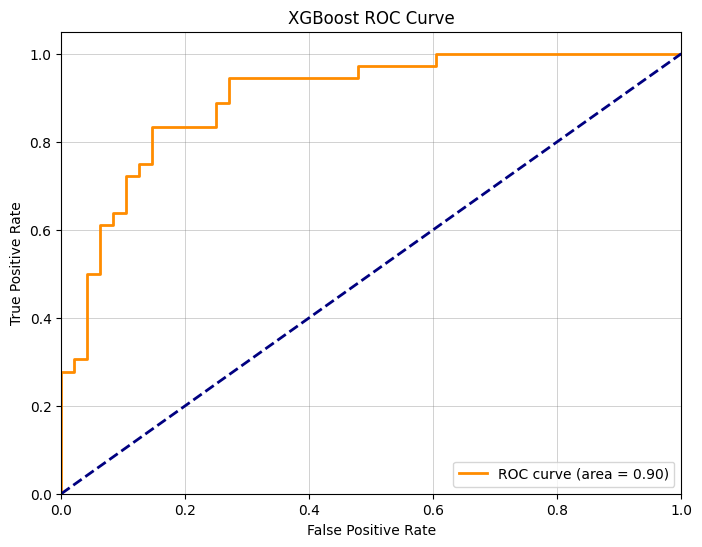

In [298]:
y_probs = model.predict(d_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')
plt.savefig(f'xgboost_roc_{time_window}.png')
plt.show()

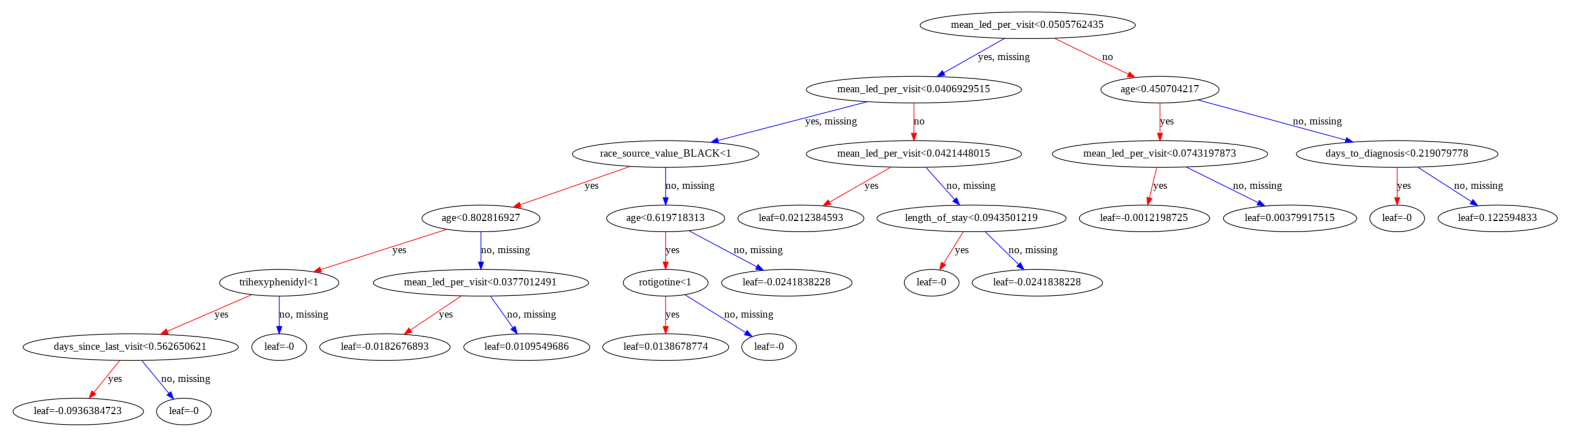

In [299]:
xgb.plot_tree(model, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(20, 20)
fig.savefig(f'xgboost_tree_{time_window}.png')

In [300]:
report.keys()

dict_keys(['0.0', '1.0', 'accuracy', 'macro avg', 'weighted avg'])

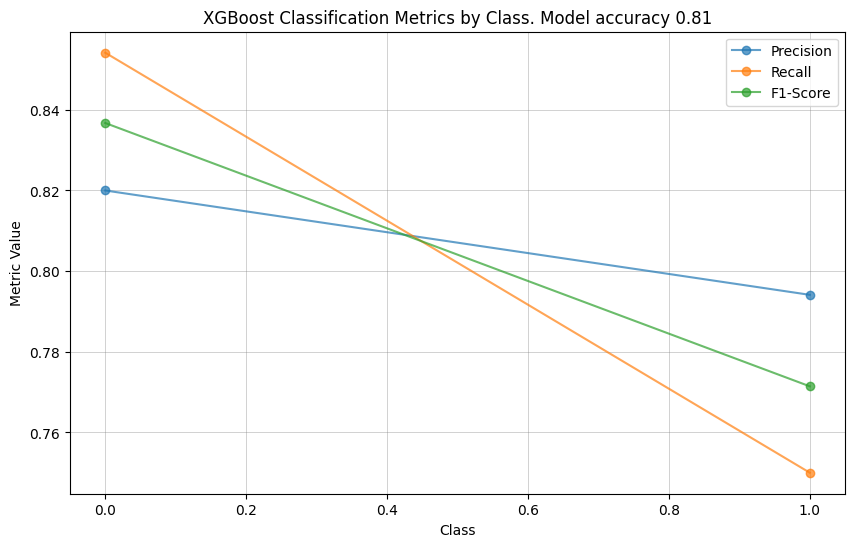

In [301]:
# Extract precision, recall, f1-score for each class
class_metrics = []
for key, value in report.items():
    # Convert the key to integer if it represents a class label
    if key.replace('.', '').isdigit():
        class_metrics.append([float(key), value['precision'], value['recall'], value['f1-score']])

class_metrics.sort()  # Sort by class label

# Extract metrics for plotting
classes = [int(row[0]) for row in class_metrics]
precision = [row[1] for row in class_metrics]
recall = [row[2] for row in class_metrics]
f1_score = [row[3] for row in class_metrics]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(classes, precision, marker='o', label='Precision', alpha=0.7)
plt.plot(classes, recall, marker='o', label='Recall', alpha=0.7)
plt.plot(classes, f1_score, marker='o', label='F1-Score', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title(f'XGBoost Classification Metrics by Class. Model accuracy {accuracy:.2f}')
plt.legend()
plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')
plt.savefig(f'xgboost_acc_{time_window}.png')
plt.show()

In [302]:
model.get_score(importance_type='weight')

{'mean_led_per_visit': 946.0,
 'age': 686.0,
 'length_of_stay': 767.0,
 'days_since_last_visit': 786.0,
 'diagnosed_current_visit': 99.0,
 'poa_current_visit': 14.0,
 'days_to_diagnosis': 642.0,
 'home_meds': 134.0,
 'amantadine': 80.0,
 'benztropine': 7.0,
 'carbidopa': 74.0,
 'carbidopa-levodopa': 74.0,
 'carbidopa-levodopa-entacapone': 1.0,
 'entacapone': 59.0,
 'pramipexole': 4.0,
 'rasagiline': 86.0,
 'ropinirole': 48.0,
 'rotigotine': 41.0,
 'selegiline': 10.0,
 'trihexyphenidyl': 11.0,
 'gender_source_value_FEMALE': 94.0,
 'race_source_value_BLACK': 25.0,
 'race_source_value_OTHER': 5.0,
 'race_source_value_WHITE': 96.0}

In [303]:
# Calculating the feature importance
feature_list = model.get_score(importance_type='weight')
feature_imp = pd.Series(feature_list).sort_values(ascending=False)
feature_imp_percentage = (feature_imp / feature_imp.sum()) * 100
feature_imp_percentage

mean_led_per_visit               19.753602
days_since_last_visit            16.412612
length_of_stay                   16.015870
age                              14.324494
days_to_diagnosis                13.405721
home_meds                         2.798079
diagnosed_current_visit           2.067237
race_source_value_WHITE           2.004594
gender_source_value_FEMALE        1.962831
rasagiline                        1.795782
amantadine                        1.670495
carbidopa                         1.545208
carbidopa-levodopa                1.545208
entacapone                        1.231990
ropinirole                        1.002297
rotigotine                        0.856129
race_source_value_BLACK           0.522030
poa_current_visit                 0.292337
trihexyphenidyl                   0.229693
selegiline                        0.208812
benztropine                       0.146168
race_source_value_OTHER           0.104406
pramipexole                       0.083525
carbidopa-l

In [304]:
non_zero_feature_imp = feature_imp_percentage[feature_imp_percentage > 1.0]
non_zero_feature_imp

mean_led_per_visit            19.753602
days_since_last_visit         16.412612
length_of_stay                16.015870
age                           14.324494
days_to_diagnosis             13.405721
home_meds                      2.798079
diagnosed_current_visit        2.067237
race_source_value_WHITE        2.004594
gender_source_value_FEMALE     1.962831
rasagiline                     1.795782
amantadine                     1.670495
carbidopa                      1.545208
carbidopa-levodopa             1.545208
entacapone                     1.231990
ropinirole                     1.002297
dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



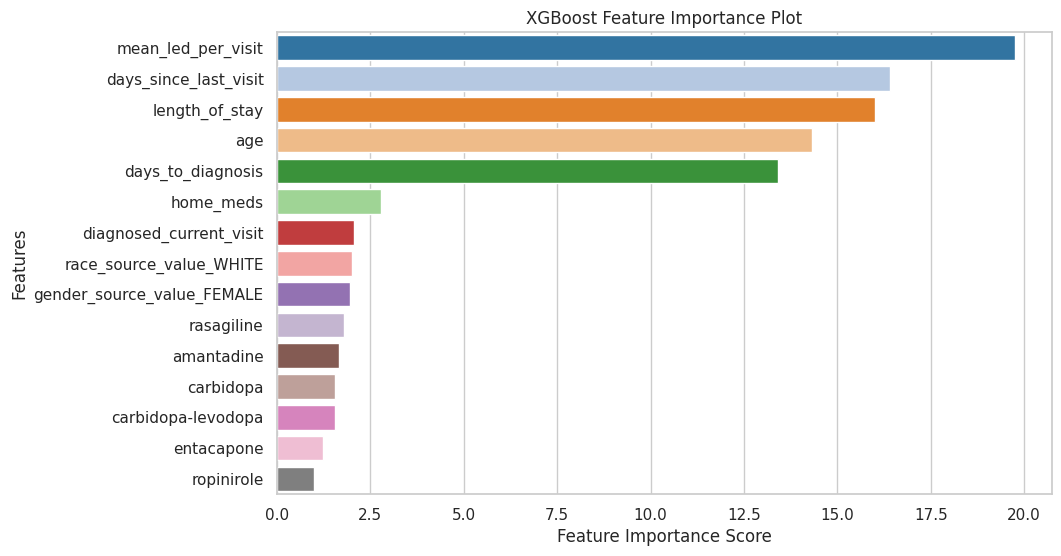

In [305]:
# Plotting feature importance
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# plt.xscale('log')
# Create a bar plot using Seaborn
sns.barplot(x=non_zero_feature_imp, y=non_zero_feature_imp.index, palette='tab20')

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance Plot')

# Show the plot
plt.savefig(f'xgboost_feature_importance_{time_window}.png')
plt.show()

Confusion Matrix

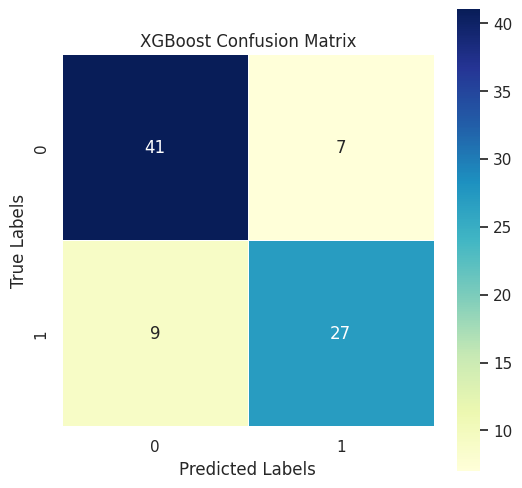

In [306]:
cm = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(6, 6)}, font_scale=1.0)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.title('XGBoost Confusion Matrix')
plt.savefig(f'xgboost_confusion_matrix_{time_window}.png')

In [307]:
shap.initjs()

In [308]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[20:09:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [309]:
shap_values.shape

(419, 39)

In [310]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

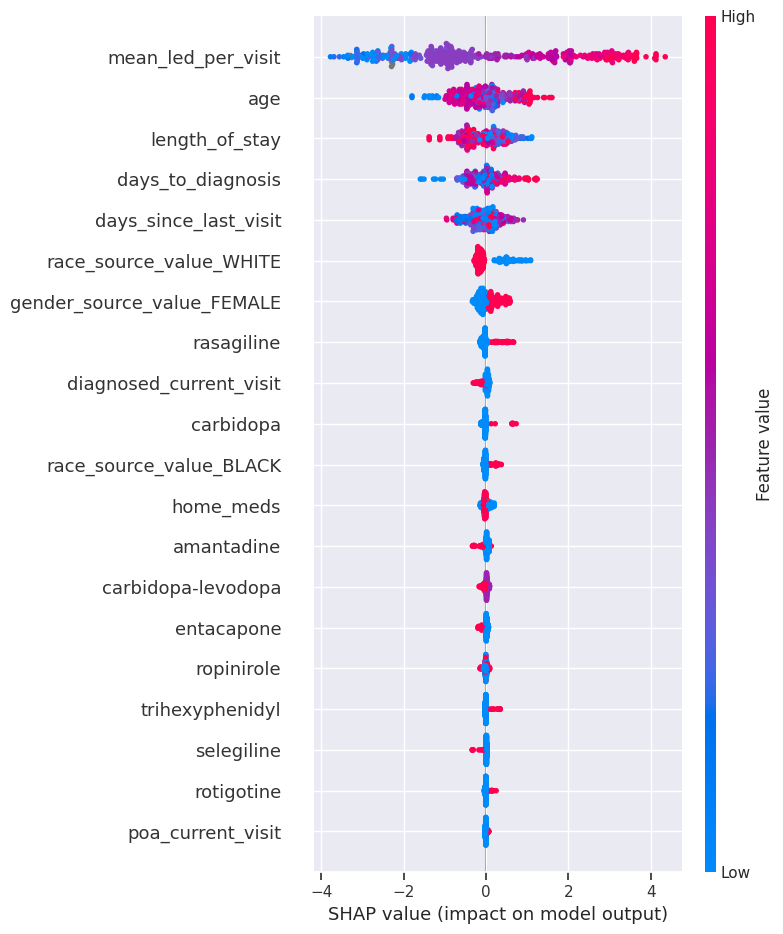

In [311]:
shap.summary_plot(shap_values, X, show=False)
plt.savefig('SHAP.svg', transparent=True)

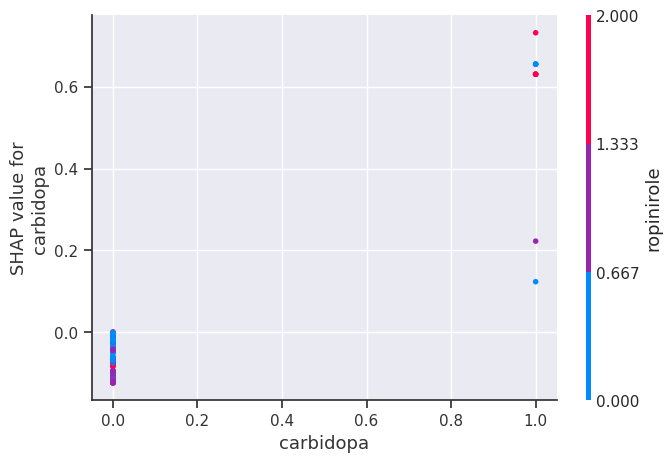

In [312]:
shap.dependence_plot("carbidopa", shap_values, X)

In [313]:
shap.force_plot(
    explainer.expected_value, shap_values[:1000, :], X.iloc[:1000, :]
)

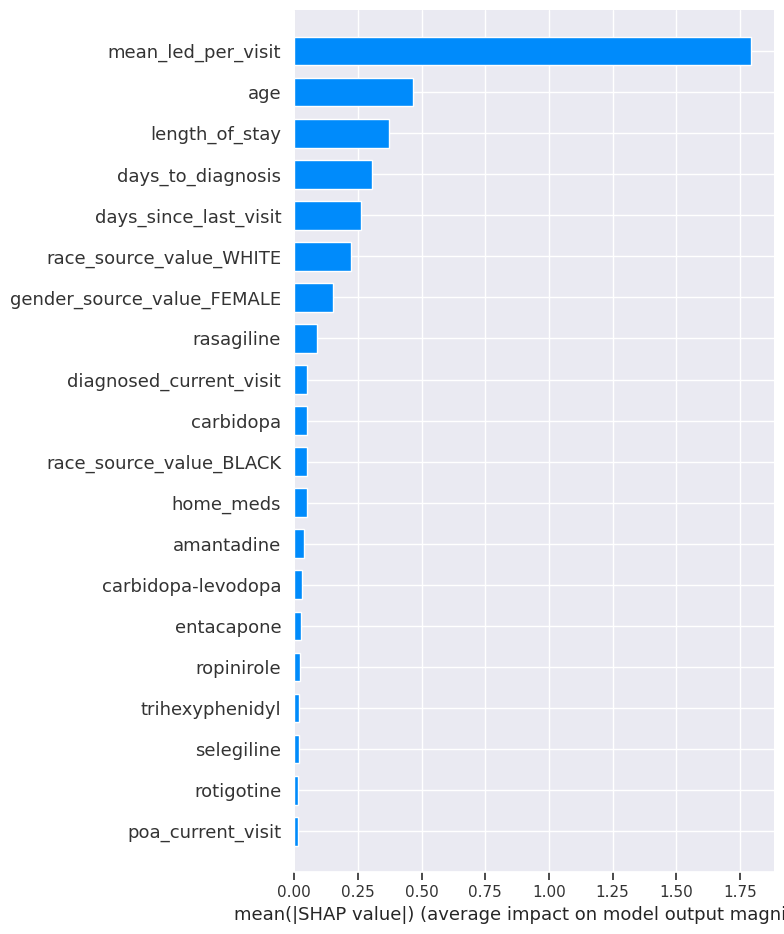

In [314]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [315]:
# for name in X_train.columns:
#     shap.dependence_plot(name, shap_values, X, display_features=X)

CatBoost Model

In [316]:
df['person_id'].nunique()

1456

In [317]:
best_params = {
    "loss_function": "Logloss",  # You can choose the appropriate loss function
    "eval_metric": "AUC",  # Area under the curve or other suitable metrics
    "iterations": 1000,  # Number of trees
    "learning_rate": 0.01,
    "depth": 11,  # Max depth of trees
    "l2_leaf_reg": 0.01,  # L2 regularization
    "verbose": 100,  # Output verbosity
    "task_type": "GPU",  # If you have a GPU available, use it
}

# Create and train the CatBoost model
model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train, verbose=True)  # Use verbose=True to see the training process

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("Accuracy:", accuracy)
file.write(f"AUC CatBoost Model: {report} Time Window: {time_window}\n")
file.close()

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 100ms	remaining: 1m 40s
1:	total: 117ms	remaining: 58.3s
2:	total: 190ms	remaining: 1m 3s
3:	total: 323ms	remaining: 1m 20s
4:	total: 518ms	remaining: 1m 43s
5:	total: 707ms	remaining: 1m 57s
6:	total: 719ms	remaining: 1m 42s
7:	total: 777ms	remaining: 1m 36s
8:	total: 808ms	remaining: 1m 29s
9:	total: 996ms	remaining: 1m 38s
10:	total: 1.19s	remaining: 1m 46s
11:	total: 1.24s	remaining: 1m 42s
12:	total: 1.43s	remaining: 1m 48s
13:	total: 1.62s	remaining: 1m 54s
14:	total: 1.64s	remaining: 1m 47s
15:	total: 1.66s	remaining: 1m 41s
16:	total: 1.85s	remaining: 1m 46s
17:	total: 1.86s	remaining: 1m 41s
18:	total: 2.06s	remaining: 1m 46s
19:	total: 2.11s	remaining: 1m 43s
20:	total: 2.15s	remaining: 1m 40s
21:	total: 2.34s	remaining: 1m 44s
22:	total: 2.38s	remaining: 1m 41s
23:	total: 2.39s	remaining: 1m 37s
24:	total: 2.4s	remaining: 1m 33s
25:	total: 2.42s	remaining: 1m 30s
26:	total: 2.61s	remaining: 1m 34s
27:	total: 2.81s	remaining: 1m 37s
28:	total: 2.83s	remaining: 1m 34

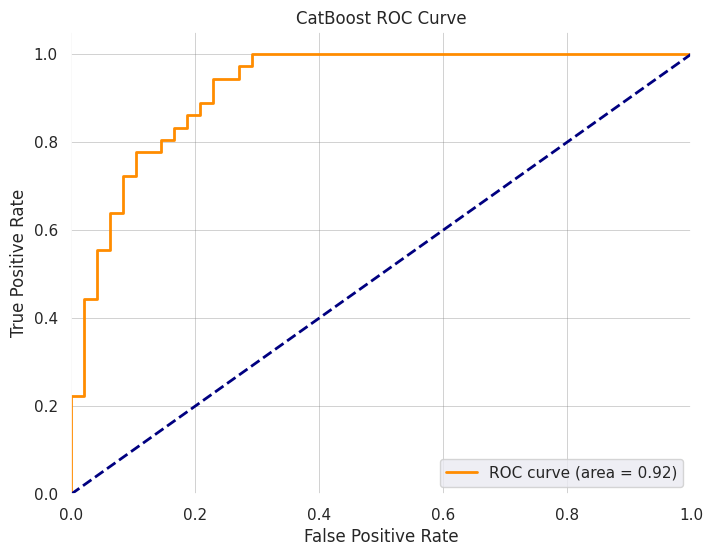

In [318]:
# Calculate the predicted probabilities for class 1 (positive class)
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')
plt.savefig(f'catboost_roc_{time_window}.png')
plt.show()

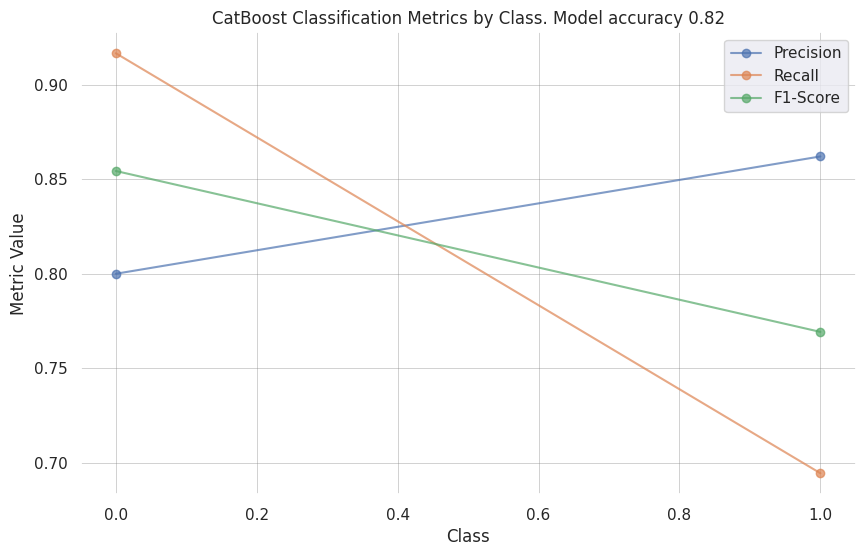

In [319]:
# Extract precision, recall, f1-score for each class
class_metrics = []
for key, value in report.items():
    # Convert the key to integer if it represents a class label
    if key.replace('.', '').isdigit():
        class_metrics.append([float(key), value['precision'], value['recall'], value['f1-score']])

class_metrics.sort()  # Sort by class label

# Extract metrics for plotting
classes = [int(row[0]) for row in class_metrics]
precision = [row[1] for row in class_metrics]
recall = [row[2] for row in class_metrics]
f1_score = [row[3] for row in class_metrics]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(classes, precision, marker='o', label='Precision', alpha=0.7)
plt.plot(classes, recall, marker='o', label='Recall', alpha=0.7)
plt.plot(classes, f1_score, marker='o', label='F1-Score', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title(f'CatBoost Classification Metrics by Class. Model accuracy {accuracy:.2f}')
plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')
plt.legend()
plt.savefig(f'catboost_acc_{time_window}.png')
plt.show()

In [320]:
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp_percentage = (feature_imp / feature_imp.sum()) * 100
feature_imp_percentage

mean_led_per_visit                       32.993858
age                                      12.738899
length_of_stay                           11.456167
days_since_last_visit                     9.361313
days_to_diagnosis                         7.403018
race_source_value_WHITE                   3.217316
ropinirole                                2.382719
carbidopa-levodopa                        2.093955
pramipexole                               1.561574
amantadine                                1.487286
entacapone                                1.215359
rasagiline                                1.193442
trihexyphenidyl                           1.176776
rotigotine                                0.988401
ethnicity_source_value_HISPANIC           0.923853
benztropine                               0.794760
gender_source_value_FEMALE                0.777717
race_source_value_BLACK                   0.767522
selegiline                                0.725807
                               

In [321]:
non_zero_feature_imp = feature_imp_percentage[feature_imp_percentage > 1.0]

In [322]:
non_zero_feature_imp

mean_led_per_visit         32.993858
age                        12.738899
length_of_stay             11.456167
days_since_last_visit       9.361313
days_to_diagnosis           7.403018
race_source_value_WHITE     3.217316
ropinirole                  2.382719
carbidopa-levodopa          2.093955
pramipexole                 1.561574
amantadine                  1.487286
entacapone                  1.215359
rasagiline                  1.193442
trihexyphenidyl             1.176776
dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



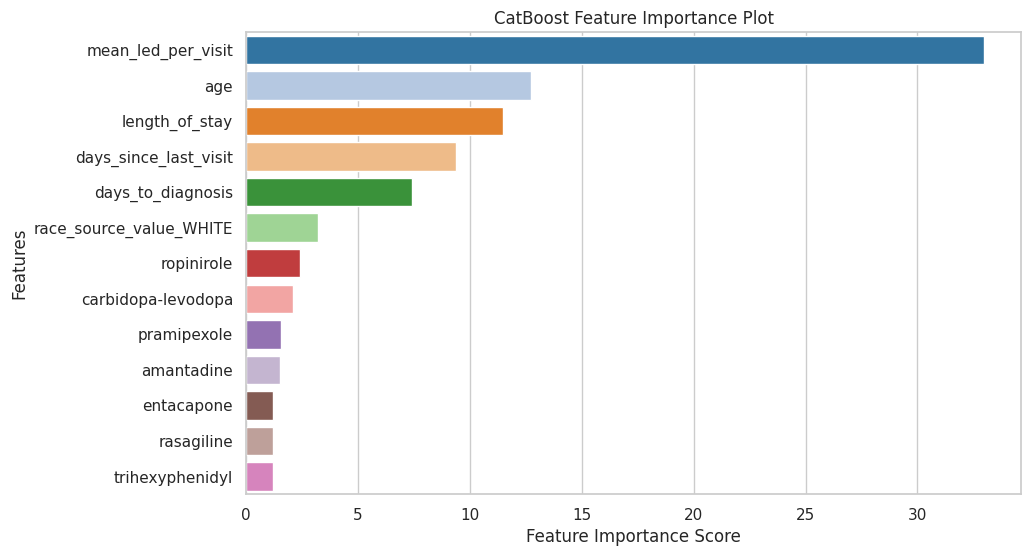

In [323]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# plt.xscale('log')
# Create a bar plot using Seaborn
sns.barplot(x=non_zero_feature_imp, y=non_zero_feature_imp.index, palette='tab20')

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance Plot')

# Show the plot
plt.savefig(f'catboost_feature_importance_{time_window}.png')
plt.show()

Confusion Matrix

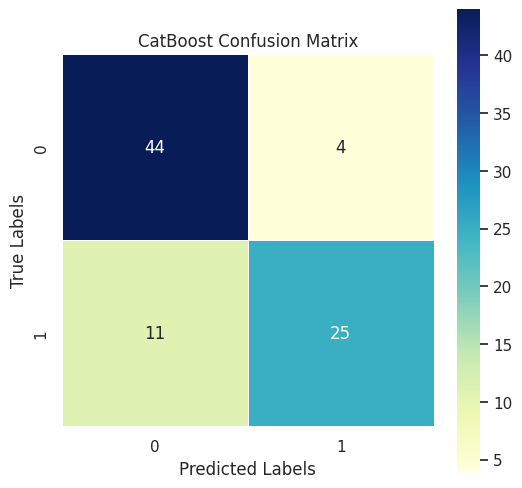

In [324]:
cm = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(6,6)}, font_scale=1.0)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.title('CatBoost Confusion Matrix')
plt.savefig(f'catboost_confusion_matrix_{time_window}.png')

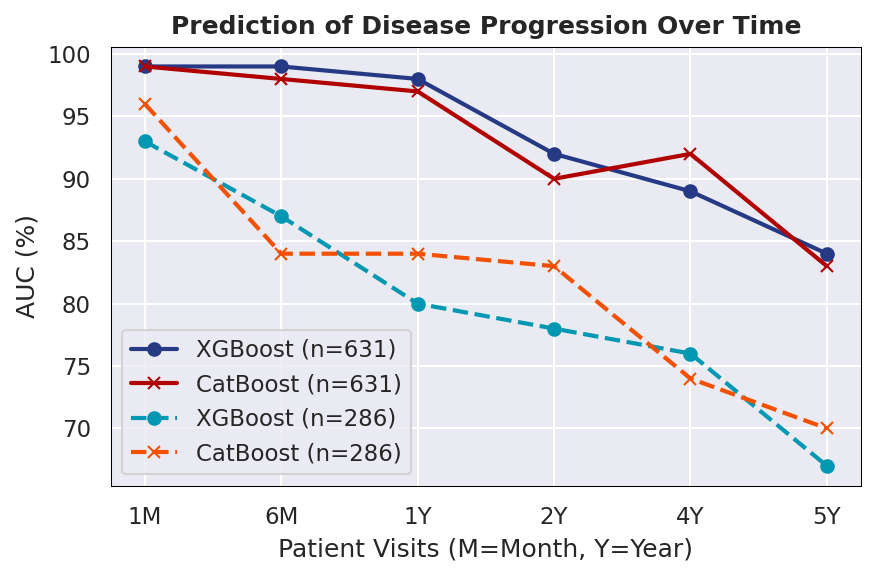

In [325]:
# AUC values for XGBoost and CatBoost models over different time periods
time_periods = ['1M', '6M', '1Y', '2Y', '4Y', '5Y']

xgboost_auc = [93, 87, 80, 78, 76, 67]
catboost_auc = [96, 84, 84, 83, 74, 70]

xgboost_auc_new_rolling = [91, 87, 90, 90, 90, 91]
catboost_auc_new_rolling = [90, 84, 90, 89, 90, 91]

xgboost_auc_new_resampling = [99, 99, 98, 92, 89, 84]
catboost_auc_new_resampling = [99, 98, 97, 90, 92, 83]

# Plotting the AUC over time for each model
plt.figure(figsize=(6.0, 4.0),  dpi=150)  # Adjusted width and height
plt.plot(time_periods, xgboost_auc_new_resampling, marker='o', label='XGBoost (n=631)', color=color_blue, linewidth=2)
plt.plot(time_periods, catboost_auc_new_resampling, marker='x', label='CatBoost (n=631)', color=color_red, linewidth=2)
plt.plot(time_periods, xgboost_auc, marker='o', label='XGBoost (n=286)', color=color_azure, linewidth=2, linestyle='--')
plt.plot(time_periods, catboost_auc, marker='x', label='CatBoost (n=286)', color=color_orange, linewidth=2, linestyle='--')

# Adding labels and title
plt.xlabel('Patient Visits (M=Month, Y=Year)')
plt.ylabel('AUC (%)')
plt.title('Prediction of Disease Progression Over Time', fontsize=12, weight='bold')
plt.legend()
plt.grid(True)

# Adjusting layout and spacing
plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(0.5)  # Reduce line width
plt.tight_layout()

# Display the plot
plt.savefig('AUC.svg', transparent=True)
plt.show()

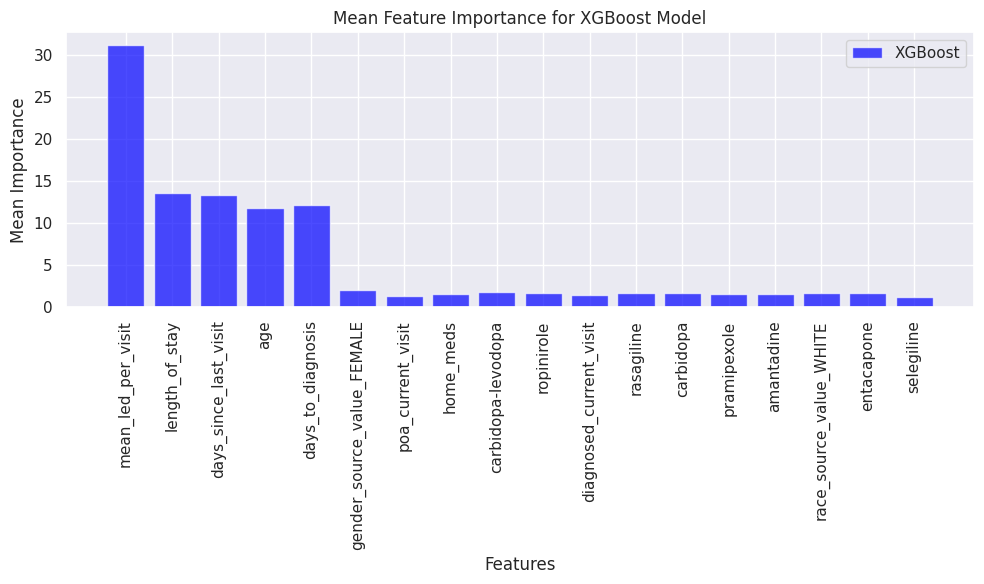

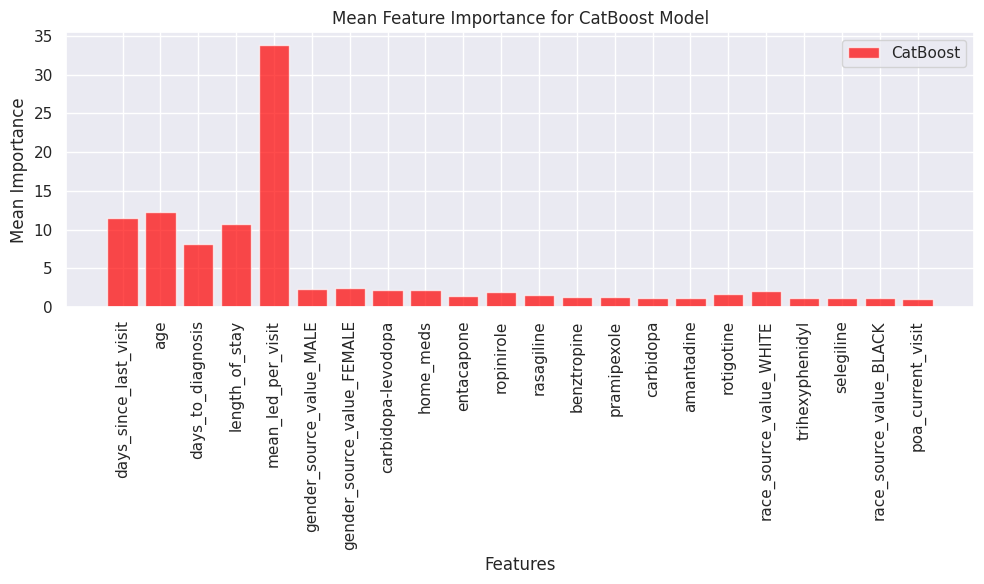

In [326]:
# Define feature importance data for XGBoost and CatBoost models over different time periods
xgboost_feature_importance = {
    '1M': {
        'mean_led_per_visit': 45.218538,
        'length_of_stay': 10.992800,
        'days_since_last_visit': 10.161241,
        'age': 9.988845,
        'days_to_diagnosis': 9.532502,
        'gender_source_value_FEMALE': 1.440016,
        'poa_current_visit': 1.328466,
        'home_meds': 1.125646,
        'carbidopa-levodopa': 1.064801,
        'ropinirole': 1.054660,
        'diagnosed_current_visit': 1.034378
    },
    '6M': {
        'mean_led_per_visit': 41.679952,
        'length_of_stay': 11.986847,
        'days_since_last_visit': 11.239538,
        'days_to_diagnosis': 10.392587,
        'age': 10.243125,
        'home_meds': 1.414906,
        'rasagiline': 1.315265,
        'ropinirole': 1.255480,
        'diagnosed_current_visit': 1.235552,
        'gender_source_value_FEMALE': 1.086090
    },
    '1Y': {
        'mean_led_per_visit': 36.948991,
        'length_of_stay': 14.024609,
        'days_since_last_visit': 12.997252,
        'age': 11.599570,
        'days_to_diagnosis': 9.556803,
        'diagnosed_current_visit': 1.720225,
        'carbidopa': 1.337952,
        'home_meds': 1.266276,
        'gender_source_value_FEMALE': 1.218492,
        'ropinirole': 1.099032
    },
    '2Y': {
        'mean_led_per_visit': 29.286842,
        'days_to_diagnosis': 13.201320,
        'age': 13.057828,
        'days_since_last_visit': 11.866839,
        'length_of_stay': 11.465060,
        'gender_source_value_FEMALE': 3.027694,
        'ropinirole': 2.640264,
        'carbidopa-levodopa': 2.195437,
        'home_meds': 2.037595,
        'rasagiline': 1.707562,
        'pramipexole': 1.578419,
        'diagnosed_current_visit': 1.234036,
        'amantadine': 1.033147
    },
    '4Y': {
        'mean_led_per_visit': 19.055614,
        'days_since_last_visit': 16.075551,
        'length_of_stay': 15.781742,
        'age': 14.081847,
        'days_to_diagnosis': 13.662120,
        'gender_source_value_FEMALE': 2.056663,
        'carbidopa': 2.035677,
        'home_meds': 1.951731,
        'amantadine': 1.951731,
        'race_source_value_WHITE': 1.867786,
        'diagnosed_current_visit': 1.762854,
        'carbidopa-levodopa': 1.720881,
        'entacapone': 1.678909,
        'ropinirole': 1.511018,
        'rasagiline': 1.469045
    },
    '5Y': {
        'days_since_last_visit': 17.851571,
        'length_of_stay': 16.937820,
        'days_to_diagnosis': 16.447515,
        'mean_led_per_visit': 14.798306,
        'age': 11.767328,
        'gender_source_value_FEMALE': 3.075552,
        'rasagiline': 2.429240,
        'carbidopa-levodopa': 2.384667,
        'ropinirole': 2.362380,
        'home_meds': 1.894361,
        'amantadine': 1.716069,
        'race_source_value_WHITE': 1.582349,
        'poa_current_visit': 1.314910,
        'selegiline': 1.203477
    }
}

catboost_feature_importance = {
    '1M': {
        'days_since_last_visit': 21.193473,
        'age': 16.157322,
        'days_to_diagnosis': 12.583390,
        'length_of_stay': 11.556768,
        'mean_led_per_visit': 7.434156,
        'gender_source_value_MALE': 5.038751,
        'gender_source_value_FEMALE': 3.915041,
        'carbidopa-levodopa': 2.988166,
        'home_meds': 2.922689,
        'entacapone': 2.575359,
        'ropinirole': 2.468838,
        'rasagiline': 1.953130,
        'benztropine': 1.777617,
        'pramipexole': 1.178596,
        'carbidopa': 1.164853,
        'amantadine': 1.089926
    },
    '6M': {
        'mean_led_per_visit': 40.391545,
        'age': 14.659019,
        'length_of_stay': 12.587204,
        'days_since_last_visit': 6.994486,
        'days_to_diagnosis': 5.563192,
        'ropinirole': 1.744425,
        'rotigotine': 1.696847,
        'race_source_value_WHITE': 1.693223,
        'gender_source_value_MALE': 1.297335,
        'rasagiline': 1.262167,
        'amantadine': 1.256931,
        'entacapone': 1.209314,
        'carbidopa': 1.065729
    },
    '1Y': {
        'mean_led_per_visit': 47.312631,
        'length_of_stay': 10.527321,
        'days_since_last_visit': 8.461022,
        'age': 7.707473,
        'days_to_diagnosis': 7.144944,
        'carbidopa-levodopa': 3.532904,
        'ropinirole': 1.909524,
        'benztropine': 1.049725
    },
    '2Y': {
        'mean_led_per_visit': 44.108196,
        'age': 10.368726,
        'length_of_stay': 9.102220,
        'days_since_last_visit': 8.358507,
        'days_to_diagnosis': 5.985106,
        'gender_source_value_MALE': 1.954501,
        'rasagiline': 1.581769,
        'pramipexole': 1.488973,
        'carbidopa-levodopa': 1.447724,
        'home_meds': 1.409368,
        'race_source_value_WHITE': 1.243515,
        'entacapone': 1.132467,
        'gender_source_value_FEMALE': 1.023172,
        'trihexyphenidyl': 1.022439
    },
    '4Y': {
        'mean_led_per_visit': 31.959561,
        'age': 13.272433,
        'length_of_stay': 11.020289,
        'days_since_last_visit': 10.191941,
        'days_to_diagnosis': 7.196420,
        'race_source_value_WHITE': 3.347410,
        'ropinirole': 2.021976,
        'carbidopa-levodopa': 1.817121,
        'pramipexole': 1.426729,
        'trihexyphenidyl': 1.377205,
        'amantadine': 1.325186,
        'gender_source_value_MALE': 1.253141,
        'rasagiline': 1.052979,
        'entacapone': 1.041837
    },
    '5Y': {
        'mean_led_per_visit': 31.458302,
        'days_since_last_visit': 13.555446,
        'age': 11.691598,
        'days_to_diagnosis': 10.233921,
        'length_of_stay': 9.317155,
        'ropinirole': 1.718860,
        'rasagiline': 1.690450,
        'carbidopa-levodopa': 1.423424,
        'selegiline': 1.223740,
        'race_source_value_BLACK': 1.163803,
        'entacapone': 1.160138,
        'benztropine': 1.104930,
        'pramipexole': 1.048241,
        'poa_current_visit': 1.034062
    }
}

# Aggregate feature importance values for both XGBoost and CatBoost models
def aggregate_feature_importance(feature_importance):
    aggregated_importance = {}
    for time_period, features in feature_importance.items():
        for feature, importance in features.items():
            if feature in aggregated_importance:
                aggregated_importance[feature].append(importance)
            else:
                aggregated_importance[feature] = [importance]
    return aggregated_importance

xgboost_aggregated_importance = aggregate_feature_importance(xgboost_feature_importance)
catboost_aggregated_importance = aggregate_feature_importance(catboost_feature_importance)

# Calculate the mean feature importance for both XGBoost and CatBoost models
xgboost_mean_importance = {feature: np.mean(importances) for feature, importances in xgboost_aggregated_importance.items()}
catboost_mean_importance = {feature: np.mean(importances) for feature, importances in catboost_aggregated_importance.items()}

# Display the mean feature importance
# print("Mean Feature Importance for XGBoost Model:")
# for feature, importance in xgboost_mean_importance.items():
#     print(f"{feature}: {importance}")

# print("\nMean Feature Importance for CatBoost Model:")
# for feature, importance in catboost_mean_importance.items():
#     print(f"{feature}: {importance}")
# Plotting mean feature importance for XGBoost
plt.figure(figsize=(10, 6))
plt.bar(xgboost_mean_importance.keys(), xgboost_mean_importance.values(), color='blue', alpha=0.7, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.title('Mean Feature Importance for XGBoost Model')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting mean feature importance for CatBoost
plt.figure(figsize=(10, 6))
plt.bar(catboost_mean_importance.keys(), catboost_mean_importance.values(), color='red', alpha=0.7, label='CatBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.title('Mean Feature Importance for CatBoost Model')
plt.legend()
plt.tight_layout()
plt.show()

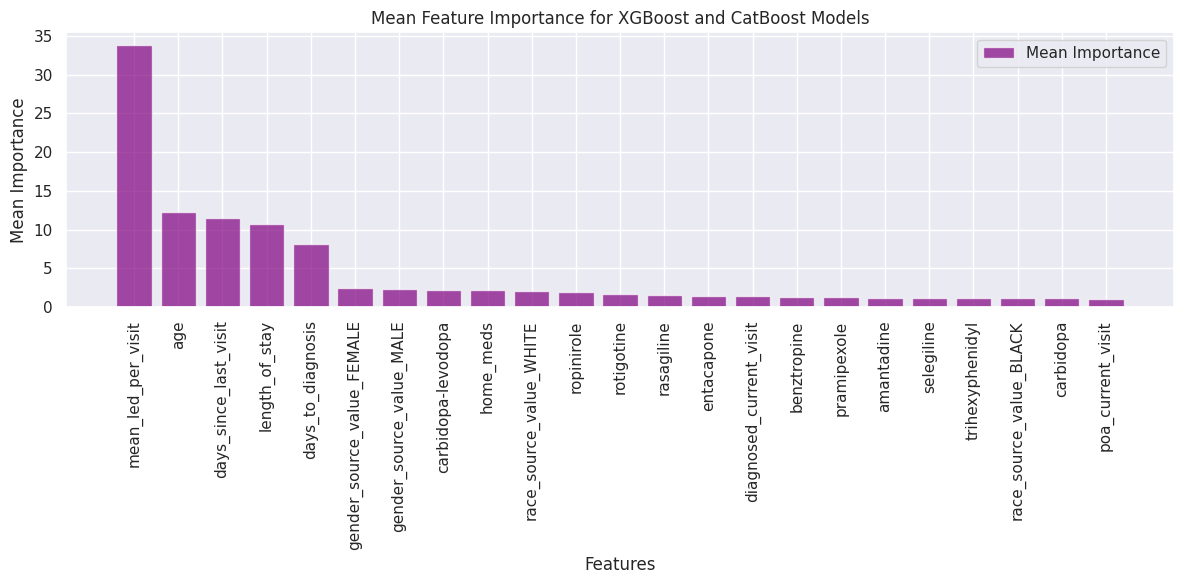

In [327]:
import matplotlib.pyplot as plt
import numpy as np

# Define feature importance data for XGBoost and CatBoost models over different time periods
xgboost_feature_importance = {
    '1M': {
        'mean_led_per_visit': 45.218538,
        'length_of_stay': 10.992800,
        'days_since_last_visit': 10.161241,
        'age': 9.988845,
        'days_to_diagnosis': 9.532502,
        'gender_source_value_FEMALE': 1.440016,
        'poa_current_visit': 1.328466,
        'home_meds': 1.125646,
        'carbidopa-levodopa': 1.064801,
        'ropinirole': 1.054660,
        'diagnosed_current_visit': 1.034378
    },
    '6M': {
        'mean_led_per_visit': 41.679952,
        'length_of_stay': 11.986847,
        'days_since_last_visit': 11.239538,
        'days_to_diagnosis': 10.392587,
        'age': 10.243125,
        'home_meds': 1.414906,
        'rasagiline': 1.315265,
        'ropinirole': 1.255480,
        'diagnosed_current_visit': 1.235552,
        'gender_source_value_FEMALE': 1.086090
    },
    '1Y': {
        'mean_led_per_visit': 36.948991,
        'length_of_stay': 14.024609,
        'days_since_last_visit': 12.997252,
        'age': 11.599570,
        'days_to_diagnosis': 9.556803,
        'diagnosed_current_visit': 1.720225,
        'carbidopa': 1.337952,
        'home_meds': 1.266276,
        'gender_source_value_FEMALE': 1.218492,
        'ropinirole': 1.099032
    },
    '2Y': {
        'mean_led_per_visit': 29.286842,
        'days_to_diagnosis': 13.201320,
        'age': 13.057828,
        'days_since_last_visit': 11.866839,
        'length_of_stay': 11.465060,
        'gender_source_value_FEMALE': 3.027694,
        'ropinirole': 2.640264,
        'carbidopa-levodopa': 2.195437,
        'home_meds': 2.037595,
        'rasagiline': 1.707562,
        'pramipexole': 1.578419,
        'diagnosed_current_visit': 1.234036,
        'amantadine': 1.033147
    },
    '4Y': {
        'mean_led_per_visit': 19.055614,
        'days_since_last_visit': 16.075551,
        'length_of_stay': 15.781742,
        'age': 14.081847,
        'days_to_diagnosis': 13.662120,
        'gender_source_value_FEMALE': 2.056663,
        'carbidopa': 2.035677,
        'home_meds': 1.951731,
        'amantadine': 1.951731,
        'race_source_value_WHITE': 1.867786,
        'diagnosed_current_visit': 1.762854,
        'carbidopa-levodopa': 1.720881,
        'entacapone': 1.678909,
        'ropinirole': 1.511018,
        'rasagiline': 1.469045
    },
    '5Y': {
        'days_since_last_visit': 17.851571,
        'length_of_stay': 16.937820,
        'days_to_diagnosis': 16.447515,
        'mean_led_per_visit': 14.798306,
        'age': 11.767328,
        'gender_source_value_FEMALE': 3.075552,
        'rasagiline': 2.429240,
        'carbidopa-levodopa': 2.384667,
        'ropinirole': 2.362380,
        'home_meds': 1.894361,
        'amantadine': 1.716069,
        'race_source_value_WHITE': 1.582349,
        'poa_current_visit': 1.314910,
        'selegiline': 1.203477
    }
}

catboost_feature_importance = {
    '1M': {
        'days_since_last_visit': 21.193473,
        'age': 16.157322,
        'days_to_diagnosis': 12.583390,
        'length_of_stay': 11.556768,
        'mean_led_per_visit': 7.434156,
        'gender_source_value_MALE': 5.038751,
        'gender_source_value_FEMALE': 3.915041,
        'carbidopa-levodopa': 2.988166,
        'home_meds': 2.922689,
        'entacapone': 2.575359,
        'ropinirole': 2.468838,
        'rasagiline': 1.953130,
        'benztropine': 1.777617,
        'pramipexole': 1.178596,
        'carbidopa': 1.164853,
        'amantadine': 1.089926
    },
    '6M': {
        'mean_led_per_visit': 40.391545,
        'age': 14.659019,
        'length_of_stay': 12.587204,
        'days_since_last_visit': 6.994486,
        'days_to_diagnosis': 5.563192,
        'ropinirole': 1.744425,
        'rotigotine': 1.696847,
        'race_source_value_WHITE': 1.693223,
        'gender_source_value_MALE': 1.297335,
        'rasagiline': 1.262167,
        'amantadine': 1.256931,
        'entacapone': 1.209314,
        'carbidopa': 1.065729
    },
    '1Y': {
        'mean_led_per_visit': 47.312631,
        'length_of_stay': 10.527321,
        'days_since_last_visit': 8.461022,
        'age': 7.707473,
        'days_to_diagnosis': 7.144944,
        'carbidopa-levodopa': 3.532904,
        'ropinirole': 1.909524,
        'benztropine': 1.049725
    },
    '2Y': {
        'mean_led_per_visit': 44.108196,
        'age': 10.368726,
        'length_of_stay': 9.102220,
        'days_since_last_visit': 8.358507,
        'days_to_diagnosis': 5.985106,
        'gender_source_value_MALE': 1.954501,
        'rasagiline': 1.581769,
        'pramipexole': 1.488973,
        'carbidopa-levodopa': 1.447724,
        'home_meds': 1.409368,
        'race_source_value_WHITE': 1.243515,
        'entacapone': 1.132467,
        'gender_source_value_FEMALE': 1.023172,
        'trihexyphenidyl': 1.022439
    },
    '4Y': {
        'mean_led_per_visit': 31.959561,
        'age': 13.272433,
        'length_of_stay': 11.020289,
        'days_since_last_visit': 10.191941,
        'days_to_diagnosis': 7.196420,
        'race_source_value_WHITE': 3.347410,
        'ropinirole': 2.021976,
        'carbidopa-levodopa': 1.817121,
        'pramipexole': 1.426729,
        'trihexyphenidyl': 1.377205,
        'amantadine': 1.325186,
        'gender_source_value_MALE': 1.253141,
        'rasagiline': 1.052979,
        'entacapone': 1.041837
    },
    '5Y': {
        'mean_led_per_visit': 31.458302,
        'days_since_last_visit': 13.555446,
        'age': 11.691598,
        'days_to_diagnosis': 10.233921,
        'length_of_stay': 9.317155,
        'ropinirole': 1.718860,
        'rasagiline': 1.690450,
        'carbidopa-levodopa': 1.423424,
        'selegiline': 1.223740,
        'race_source_value_BLACK': 1.163803,
        'entacapone': 1.160138,
        'benztropine': 1.104930,
        'pramipexole': 1.048241,
        'poa_current_visit': 1.034062
    }
}

# Aggregate feature importance values for both XGBoost and CatBoost models
def aggregate_feature_importance(feature_importance):
    aggregated_importance = {}
    for time_period, features in feature_importance.items():
        for feature, importance in features.items():
            if feature in aggregated_importance:
                aggregated_importance[feature].append(importance)
            else:
                aggregated_importance[feature] = [importance]
    return aggregated_importance

xgboost_aggregated_importance = aggregate_feature_importance(xgboost_feature_importance)
catboost_aggregated_importance = aggregate_feature_importance(catboost_feature_importance)

# Calculate the mean feature importance for both XGBoost and CatBoost models
xgboost_mean_importance = {feature: np.mean(importances) for feature, importances in xgboost_aggregated_importance.items()}
catboost_mean_importance = {feature: np.mean(importances) for feature, importances in catboost_aggregated_importance.items()}

# Merge XGBoost and CatBoost mean importance dictionaries
all_mean_importance = {**xgboost_mean_importance, **catboost_mean_importance}

# Sort the dictionary by values (importance) in descending order
sorted_all_mean_importance = dict(sorted(all_mean_importance.items(), key=lambda item: item[1], reverse=True))

# Plotting mean feature importance for both XGBoost and CatBoost
plt.figure(figsize=(12, 6))
plt.bar(sorted_all_mean_importance.keys(), sorted_all_mean_importance.values(), color='purple', alpha=0.7, label='Mean Importance')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.title('Mean Feature Importance for XGBoost and CatBoost Models')
plt.legend()
plt.tight_layout()
plt.show()


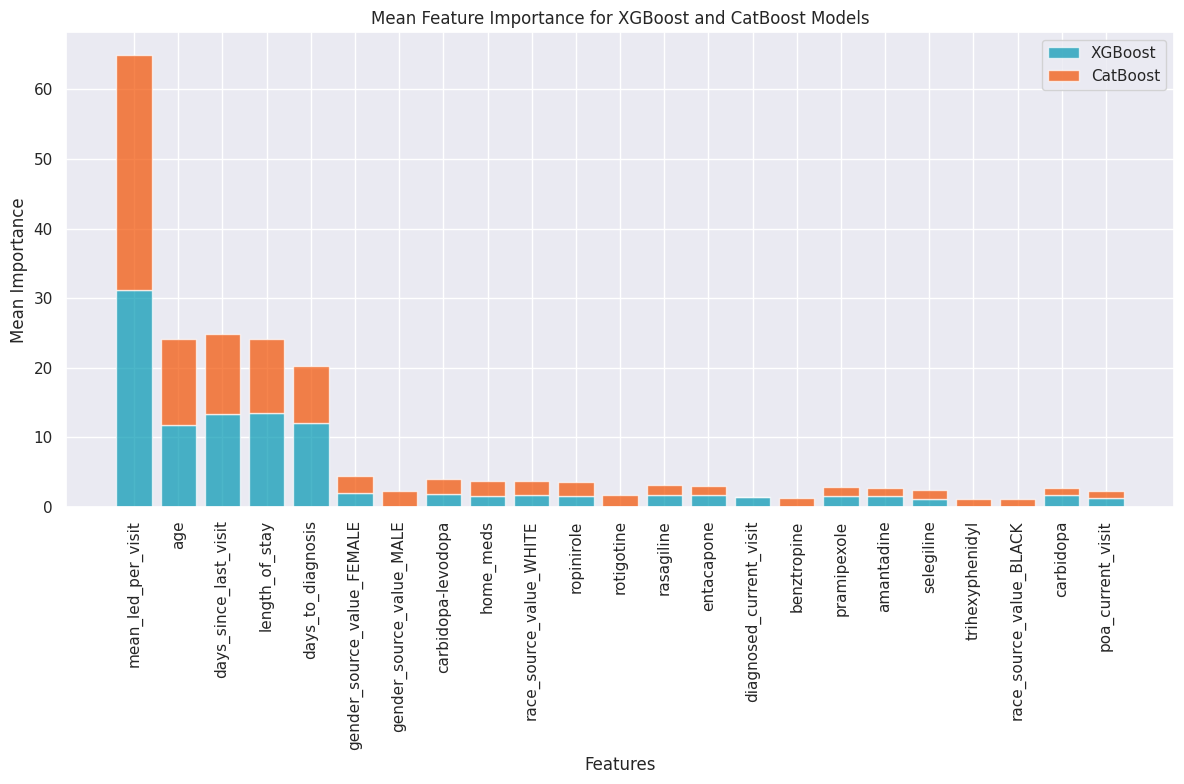

In [328]:
import numpy as np
import matplotlib.pyplot as plt

# Define feature importance data for XGBoost and CatBoost models over different time periods
xgboost_feature_importance = {
    '1M': {
        'mean_led_per_visit': 45.218538,
        'length_of_stay': 10.992800,
        'days_since_last_visit': 10.161241,
        'age': 9.988845,
        'days_to_diagnosis': 9.532502,
        'gender_source_value_FEMALE': 1.440016,
        'poa_current_visit': 1.328466,
        'home_meds': 1.125646,
        'carbidopa-levodopa': 1.064801,
        'ropinirole': 1.054660,
        'diagnosed_current_visit': 1.034378
    },
    '6M': {
        'mean_led_per_visit': 41.679952,
        'length_of_stay': 11.986847,
        'days_since_last_visit': 11.239538,
        'days_to_diagnosis': 10.392587,
        'age': 10.243125,
        'home_meds': 1.414906,
        'rasagiline': 1.315265,
        'ropinirole': 1.255480,
        'diagnosed_current_visit': 1.235552,
        'gender_source_value_FEMALE': 1.086090
    },
    '1Y': {
        'mean_led_per_visit': 36.948991,
        'length_of_stay': 14.024609,
        'days_since_last_visit': 12.997252,
        'age': 11.599570,
        'days_to_diagnosis': 9.556803,
        'diagnosed_current_visit': 1.720225,
        'carbidopa': 1.337952,
        'home_meds': 1.266276,
        'gender_source_value_FEMALE': 1.218492,
        'ropinirole': 1.099032
    },
    '2Y': {
        'mean_led_per_visit': 29.286842,
        'days_to_diagnosis': 13.201320,
        'age': 13.057828,
        'days_since_last_visit': 11.866839,
        'length_of_stay': 11.465060,
        'gender_source_value_FEMALE': 3.027694,
        'ropinirole': 2.640264,
        'carbidopa-levodopa': 2.195437,
        'home_meds': 2.037595,
        'rasagiline': 1.707562,
        'pramipexole': 1.578419,
        'diagnosed_current_visit': 1.234036,
        'amantadine': 1.033147
    },
    '4Y': {
        'mean_led_per_visit': 19.055614,
        'days_since_last_visit': 16.075551,
        'length_of_stay': 15.781742,
        'age': 14.081847,
        'days_to_diagnosis': 13.662120,
        'gender_source_value_FEMALE': 2.056663,
        'carbidopa': 2.035677,
        'home_meds': 1.951731,
        'amantadine': 1.951731,
        'race_source_value_WHITE': 1.867786,
        'diagnosed_current_visit': 1.762854,
        'carbidopa-levodopa': 1.720881,
        'entacapone': 1.678909,
        'ropinirole': 1.511018,
        'rasagiline': 1.469045
    },
    '5Y': {
        'days_since_last_visit': 17.851571,
        'length_of_stay': 16.937820,
        'days_to_diagnosis': 16.447515,
        'mean_led_per_visit': 14.798306,
        'age': 11.767328,
        'gender_source_value_FEMALE': 3.075552,
        'rasagiline': 2.429240,
        'carbidopa-levodopa': 2.384667,
        'ropinirole': 2.362380,
        'home_meds': 1.894361,
        'amantadine': 1.716069,
        'race_source_value_WHITE': 1.582349,
        'poa_current_visit': 1.314910,
        'selegiline': 1.203477
    }
}

catboost_feature_importance = {
    '1M': {
        'days_since_last_visit': 21.193473,
        'age': 16.157322,
        'days_to_diagnosis': 12.583390,
        'length_of_stay': 11.556768,
        'mean_led_per_visit': 7.434156,
        'gender_source_value_MALE': 5.038751,
        'gender_source_value_FEMALE': 3.915041,
        'carbidopa-levodopa': 2.988166,
        'home_meds': 2.922689,
        'entacapone': 2.575359,
        'ropinirole': 2.468838,
        'rasagiline': 1.953130,
        'benztropine': 1.777617,
        'pramipexole': 1.178596,
        'carbidopa': 1.164853,
        'amantadine': 1.089926
    },
    '6M': {
        'mean_led_per_visit': 40.391545,
        'age': 14.659019,
        'length_of_stay': 12.587204,
        'days_since_last_visit': 6.994486,
        'days_to_diagnosis': 5.563192,
        'ropinirole': 1.744425,
        'rotigotine': 1.696847,
        'race_source_value_WHITE': 1.693223,
        'gender_source_value_MALE': 1.297335,
        'rasagiline': 1.262167,
        'amantadine': 1.256931,
        'entacapone': 1.209314,
        'carbidopa': 1.065729
    },
    '1Y': {
        'mean_led_per_visit': 47.312631,
        'length_of_stay': 10.527321,
        'days_since_last_visit': 8.461022,
        'age': 7.707473,
        'days_to_diagnosis': 7.144944,
        'carbidopa-levodopa': 3.532904,
        'ropinirole': 1.909524,
        'benztropine': 1.049725
    },
    '2Y': {
        'mean_led_per_visit': 44.108196,
        'age': 10.368726,
        'length_of_stay': 9.102220,
        'days_since_last_visit': 8.358507,
        'days_to_diagnosis': 5.985106,
        'gender_source_value_MALE': 1.954501,
        'rasagiline': 1.581769,
        'pramipexole': 1.488973,
        'carbidopa-levodopa': 1.447724,
        'home_meds': 1.409368,
        'race_source_value_WHITE': 1.243515,
        'entacapone': 1.132467,
        'gender_source_value_FEMALE': 1.023172,
        'trihexyphenidyl': 1.022439
    },
    '4Y': {
        'mean_led_per_visit': 31.959561,
        'age': 13.272433,
        'length_of_stay': 11.020289,
        'days_since_last_visit': 10.191941,
        'days_to_diagnosis': 7.196420,
        'race_source_value_WHITE': 3.347410,
        'ropinirole': 2.021976,
        'carbidopa-levodopa': 1.817121,
        'pramipexole': 1.426729,
        'trihexyphenidyl': 1.377205,
        'amantadine': 1.325186,
        'gender_source_value_MALE': 1.253141,
        'rasagiline': 1.052979,
        'entacapone': 1.041837
    },
    '5Y': {
        'mean_led_per_visit': 31.458302,
        'days_since_last_visit': 13.555446,
        'age': 11.691598,
        'days_to_diagnosis': 10.233921,
        'length_of_stay': 9.317155,
        'ropinirole': 1.718860,
        'rasagiline': 1.690450,
        'carbidopa-levodopa': 1.423424,
        'selegiline': 1.223740,
        'race_source_value_BLACK': 1.163803,
        'entacapone': 1.160138,
        'benztropine': 1.104930,
        'pramipexole': 1.048241,
        'poa_current_visit': 1.034062
    }
}

# Aggregate feature importance values for both XGBoost and CatBoost models
def aggregate_feature_importance(feature_importance):
    aggregated_importance = {}
    for time_period, features in feature_importance.items():
        for feature, importance in features.items():
            if feature in aggregated_importance:
                aggregated_importance[feature].append(importance)
            else:
                aggregated_importance[feature] = [importance]
    return aggregated_importance

xgboost_aggregated_importance = aggregate_feature_importance(xgboost_feature_importance)
catboost_aggregated_importance = aggregate_feature_importance(catboost_feature_importance)

# Calculate the mean feature importance for both XGBoost and CatBoost models
xgboost_mean_importance = {feature: np.mean(importances) for feature, importances in xgboost_aggregated_importance.items()}
catboost_mean_importance = {feature: np.mean(importances) for feature, importances in catboost_aggregated_importance.items()}

# Merge XGBoost and CatBoost mean importance dictionaries
all_mean_importance = {**xgboost_mean_importance, **catboost_mean_importance}

# Sort the dictionary by values (importance) in descending order
sorted_all_mean_importance = dict(sorted(all_mean_importance.items(), key=lambda item: item[1], reverse=True))

# Extract sorted features and importances
sorted_features = list(sorted_all_mean_importance.keys())
xgboost_importances = [xgboost_mean_importance.get(feature, 0) for feature in sorted_features]
catboost_importances = [catboost_mean_importance.get(feature, 0) for feature in sorted_features]

# Plot stacked bar plot
plt.figure(figsize=(12, 8))
plt.bar(sorted_features, xgboost_importances, color=color_azure, alpha=0.7, label='XGBoost')
plt.bar(sorted_features, catboost_importances, bottom=xgboost_importances, color=color_orange, alpha=0.7, label='CatBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.title('Mean Feature Importance for XGBoost and CatBoost Models')
plt.legend()
plt.tight_layout()
plt.show()

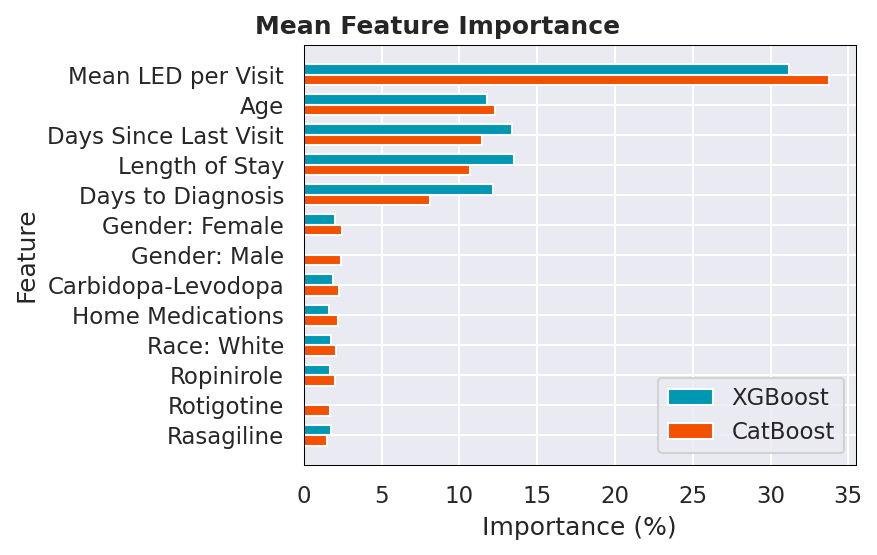

In [329]:

# Aggregate feature importance values for both XGBoost and CatBoost models
def aggregate_feature_importance(feature_importance, custom_labels=None):
    aggregated_importance = {}
    for time_period, features in feature_importance.items():
        for feature, importance in features.items():
            if custom_labels and feature in custom_labels:
                feature_label = custom_labels[feature]
            else:
                feature_label = feature
            if feature_label in aggregated_importance:
                aggregated_importance[feature_label].append(importance)
            else:
                aggregated_importance[feature_label] = [importance]
    return aggregated_importance

# Define custom labels for features
custom_labels = {
    'mean_led_per_visit': 'Mean LED per Visit',
    'length_of_stay': 'Length of Stay',
    'days_since_last_visit': 'Days Since Last Visit',
    'age': 'Age',
    'days_to_diagnosis': 'Days to Diagnosis',
    'gender_source_value_FEMALE': 'Gender: Female',
    'gender_source_value_MALE': 'Gender: Male',
    'race_source_value_WHITE': 'Race: White',
    'poa_current_visit': 'POA Current Visit',
    'home_meds': 'Home Medications',
    'carbidopa-levodopa': 'Carbidopa-Levodopa',
    'ropinirole': 'Ropinirole',
    'rasagiline': 'Rasagiline',
    'rotigotine': 'Rotigotine',
    'diagnosed_current_visit': 'Diagnosed Current Visit'
}

xgboost_aggregated_importance = aggregate_feature_importance(xgboost_feature_importance, custom_labels)
catboost_aggregated_importance = aggregate_feature_importance(catboost_feature_importance, custom_labels)

# Calculate the mean feature importance for both XGBoost and CatBoost models
xgboost_mean_importance = {feature: np.mean(importances) for feature, importances in xgboost_aggregated_importance.items()}
catboost_mean_importance = {feature: np.mean(importances) for feature, importances in catboost_aggregated_importance.items()}

# Merge XGBoost and CatBoost mean importance dictionaries
all_mean_importance = {**xgboost_mean_importance, **catboost_mean_importance}

# Sort the dictionary by values (importance) in descending order
sorted_all_mean_importance = dict(sorted(all_mean_importance.items(), key=lambda item: item[1], reverse=True))

# Set threshold for importance
threshold = 1.5  # Adjust this threshold as needed

# Filter features based on the threshold
sorted_features_filtered = [feature for feature, importance in sorted_all_mean_importance.items() if importance >= threshold]
xgboost_importances_filtered = [xgboost_mean_importance.get(feature, 0) for feature in sorted_features_filtered]
catboost_importances_filtered = [catboost_mean_importance.get(feature, 0) for feature in sorted_features_filtered]

# Plot side-by-side bar plot for filtered features
plt.figure(figsize=(6.0, 4.0),  dpi=150)

# Width of each bar
bar_width = 0.35

# Define index for X axis
x = np.arange(len(sorted_features_filtered))

# Plot XGBoost importances
erre = plt.barh(x - bar_width/2, xgboost_importances_filtered, bar_width, color=color_azure, label='XGBoost')

# Plot CatBoost importances
epa = plt.barh(x + bar_width/2, catboost_importances_filtered, bar_width, color=color_orange, label='CatBoost')
# Set ticks and labels
plt.yticks(x, sorted_features_filtered)
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.suptitle('Mean Feature Importance', weight='bold', fontsize=12, y=0.92, ha='center')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
# Add borders to the plot and set color to black with reduced line width
plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(0.5)  # Reduce line width
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(0.5)  # Reduce line width
plt.savefig('MAAFI.svg', transparent=True)
plt.show()

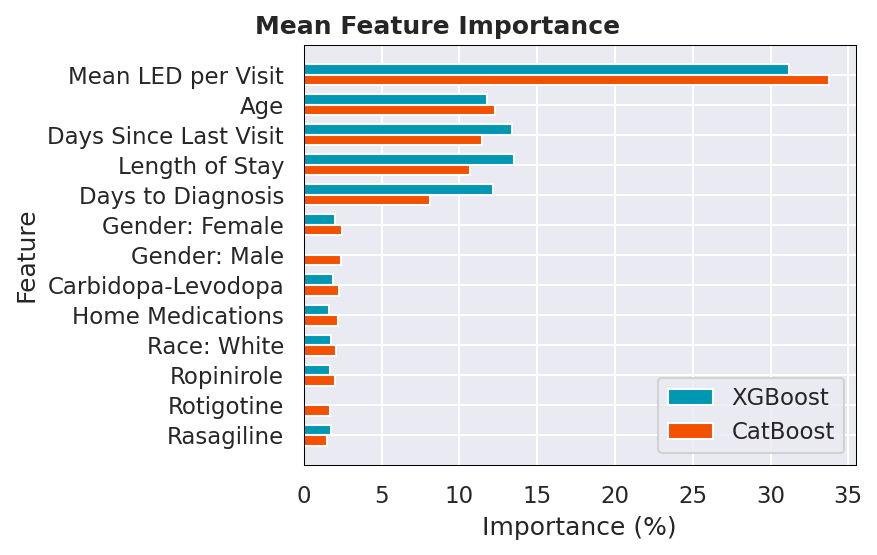

In [330]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate feature importance values for both XGBoost and CatBoost models
def aggregate_feature_importance(feature_importance, custom_labels=None):
    aggregated_importance = {}
    for time_period, features in feature_importance.items():
        for feature, importance in features.items():
            if custom_labels and feature in custom_labels:
                feature_label = custom_labels[feature]
            else:
                feature_label = feature
            if feature_label in aggregated_importance:
                aggregated_importance[feature_label].append(importance)
            else:
                aggregated_importance[feature_label] = [importance]
    return aggregated_importance

# Define custom labels for features
custom_labels = {
    'mean_led_per_visit': 'Mean LED per Visit',
    'length_of_stay': 'Length of Stay',
    'days_since_last_visit': 'Days Since Last Visit',
    'age': 'Age',
    'days_to_diagnosis': 'Days to Diagnosis',
    'gender_source_value_FEMALE': 'Gender: Female',
    'gender_source_value_MALE': 'Gender: Male',
    'race_source_value_WHITE': 'Race: White',
    'poa_current_visit': 'POA Current Visit',
    'home_meds': 'Home Medications',
    'carbidopa-levodopa': 'Carbidopa-Levodopa',
    'ropinirole': 'Ropinirole',
    'rasagiline': 'Rasagiline',
    'rotigotine': 'Rotigotine',
    'diagnosed_current_visit': 'Diagnosed Current Visit'
}

xgboost_aggregated_importance = aggregate_feature_importance(xgboost_feature_importance, custom_labels)
catboost_aggregated_importance = aggregate_feature_importance(catboost_feature_importance, custom_labels)

# Calculate the mean feature importance for both XGBoost and CatBoost models
xgboost_mean_importance = {feature: np.mean(importances) for feature, importances in xgboost_aggregated_importance.items()}
catboost_mean_importance = {feature: np.mean(importances) for feature, importances in catboost_aggregated_importance.items()}

# Merge XGBoost and CatBoost mean importance dictionaries
all_mean_importance = {**xgboost_mean_importance, **catboost_mean_importance}

# Sort the dictionary by values (importance) in descending order
sorted_all_mean_importance = dict(sorted(all_mean_importance.items(), key=lambda item: item[1], reverse=True))

# Set threshold for importance
threshold = 1.5  # Adjust this threshold as needed

# Filter features based on the threshold
sorted_features_filtered = [feature for feature, importance in sorted_all_mean_importance.items() if importance >= threshold]
xgboost_importances_filtered = [xgboost_mean_importance.get(feature, 0) for feature in sorted_features_filtered]
catboost_importances_filtered = [catboost_mean_importance.get(feature, 0) for feature in sorted_features_filtered]

# Plot side-by-side bar plot for filtered features
plt.figure(figsize=(6.0, 4.0),  dpi=150)

# Width of each bar
bar_width = 0.35

# Define index for X axis
x = np.arange(len(sorted_features_filtered))

# Plot XGBoost importances
plt.barh(x, xgboost_importances_filtered, bar_width, color=color_azure, label='XGBoost')

# Plot CatBoost importances
plt.barh(x + bar_width, catboost_importances_filtered, bar_width, color=color_orange, label='CatBoost')

# Set ticks and labels
plt.yticks(x + bar_width / 2, sorted_features_filtered)
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.suptitle('Mean Feature Importance', weight='bold', fontsize=12, y=0.92, ha='center')
plt.legend()
plt.grid(True)

# Add borders to the plot and set color to black with reduced line width
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.5)

plt.gca().invert_yaxis()
plt.tight_layout()

# Save the plot as SVG
plt.savefig('FI.svg', transparent=True)
plt.show()


Hyperparameter tuning for XGBoost and CatBoost

In [331]:
# # Define a parameter grid to search
# param_grid_xgboost = {
#     'max_depth': [4, 5, 6, 7, 8, 9],
#     'learning_rate': [0.1, 0.01, 0.001, 0.0001],
#     'n_estimators': [300, 400, 500, 600, 700, 800],
#     'alpha': [0, 0.01, 0.1, 1, 10],  # L1 regularization (alpha)
#     'lambda': [0, 0.01, 0.1, 1, 10],  # L2 regularization (lambda)
# }

# param_grid_catboost = {
#     'depth': [4, 5, 6, 7, 8, 9],
#     'learning_rate': [.01, 0.001, 0.0001],
#     'iterations': [600, 700, 800],
#     # There's no L1 regularization in catboost
#     'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
#     # 'boosting_type': ['Plain', 'Ordered']
# }

# # Create a classifier
# # model = xgb.XGBClassifier(verbosity=2)
# model = CatBoostClassifier()

# # Perform grid search with cross-validation
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
# grid_search = GridSearchCV(model, param_grid_catboost, cv=kfold, n_jobs=-1, scoring='roc_auc', verbose=2)
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# # Best Hyperparameters: {'depth': 9, 'iterations': 800, 'l2_leaf_reg': 0.01, 'learning_rate': 0.01}
# # Best Model Accuracy: 0.8311688311688312
# # Train a model with the best hyperparameters
# # best_model = xgb.XGBClassifier(**best_params)
# best_model = CatBoostClassifier(**best_params)
# best_model.fit(X_train, y_train)

# # Make predictions and evaluate the best model
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print("Best Hyperparameters:", best_params)
# print("Best Model Accuracy:", accuracy)